In [1]:
import tensorflow as tf

2023-08-04 11:46:37.244440: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-04 11:46:38.716928: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import wrapt
wrapt.__version__   # should be 1.14.1

'1.14.1'

In [3]:
from tensorflow import keras as keras
from keras import layers as layers

In [4]:
import os, timeit
from skimage.filters import threshold_otsu
import numpy as np
from math import inf as inf

In [5]:
import pandas as pd

In [6]:
from spectral.io import envi as envi
from spectral import imshow

In [7]:
from sklearn.decomposition import IncrementalPCA

In [8]:
import sys

In [9]:
from tensorflow.keras.utils import set_random_seed
set_random_seed(42)

In [10]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [11]:
from sys import platform
DATA_DIRECTORY = ""
SLASH = ""
if platform == "linux" or platform == "linux2":
    DATA_DIRECTORY = "/home/tyagi/Desktop/wheat/data/BULK/"
    SLASH = "/"
elif platform == "win32":
    DATA_DIRECTORY = "D:\mvl\wheat\data\BULK\\"
    SLASH="\\"

In [12]:
#Constants
BAND_NUMBER = 60
FILLED_AREA_RATIO = 0.9
TOTAL_IMAGE_COUNT = 2400
IMAGE_COUNT = int(TOTAL_IMAGE_COUNT/4)
NUM_VARIETIES = 4

IMAGE_WIDTH = 30
IMAGE_HEIGHT = 30

In [13]:
ACTIVATION_TYPE =  "relu"
BATCH_SIZE = 2*NUM_VARIETIES

LEARNING_RATE_BASE = 0.0001

In [14]:
from enum import Enum

class filter_method(Enum):
    none = 0
    snv = 1
    msc = 2
    savgol = 3
    
FILTER = filter_method(2).name

# to be set if filter chosen is savgol
WINDOW = 7
ORDER = 2
DERIVATIVE = "none"

In [15]:
from enum import Enum
 
class feature_extraction_method(Enum):
    none = 0
    pca_loading = 1
    lda = 2
    ipca = 3

FEATURE_EXTRACTION = feature_extraction_method(0).name

NUM_OF_BANDS = 3
if FEATURE_EXTRACTION == "pca_loading" or FEATURE_EXTRACTION == "ipca":
    NUM_OF_BANDS = 8
elif FEATURE_EXTRACTION == "lda":
    NUM_OF_BANDS = 3
    assert NUM_OF_BANDS <= min(NUM_VARIETIES-1,168),"NUM_OF_BANDS is greater."


REMOVE_NOISY_BANDS = False
FIRST_BAND = 15
LAST_BAND = 161

In [16]:
def start_timer():
    print("Testing started")
    return timeit.default_timer()

def end_timer():
    return timeit.default_timer()

def show_time(tic,toc): 
    test_time = toc - tic
    print('Testing time (s) = ' + str(test_time) + '\n')

In [17]:
# List for All varieties
VARIETIES = []
VARIETIES_CODE = {}

for name in os.listdir(DATA_DIRECTORY):
    if (name.endswith(".hdr") or name.endswith(".bil")):
        continue
    VARIETIES_CODE[name] = len(VARIETIES)
    VARIETIES.append(name)
    if len(VARIETIES)==NUM_VARIETIES:
        break

In [18]:
def dataset_file_name(variety):
    name = "./dataset/V"+str(variety).zfill(3)+"_IC_"+str(TOTAL_IMAGE_COUNT).zfill(5)+"_FilledArea_"+str(FILLED_AREA_RATIO)+"_NumOfBands_"+str(NUM_OF_BANDS)+"_FB_"+str(FIRST_BAND)+"_LB_"+str(LAST_BAND)+"_BandNo_"+str(BAND_NUMBER)+"_ImageHeight_"+str(IMAGE_HEIGHT)+"_ImageWidth_"+str(IMAGE_WIDTH)+"_FILTER_"+str(FILTER)+"_FeatureExtraction_"+str(FEATURE_EXTRACTION)
    if REMOVE_NOISY_BANDS:
        name+="_REMOVE_NOISY_BANDS_"+str(REMOVE_NOISY_BANDS)
    if FILTER == "savgol":
        name+="_WINDOW_"+str(WINDOW)+"_ORDER_"+str(ORDER)
    return name

In [19]:
train_dataset = []
train_dataset_label = []
test_dataset=[]
test_dataset_label = []

for idx, v in enumerate(VARIETIES):
    print("idx: ",idx)
    if idx >= NUM_VARIETIES:
        break
    train_dataset= train_dataset + np.load(dataset_file_name(v)+"_train_dataset.npy").tolist()
    train_dataset_label = train_dataset_label + np.load(dataset_file_name(v)+"_train_dataset_label.npy").tolist()
    test_dataset = test_dataset + np.load(dataset_file_name(v)+"_test_dataset.npy").tolist()
    test_dataset_label = test_dataset_label + np.load(dataset_file_name(v)+"_test_dataset_label.npy").tolist()
    
train_dataset = np.array(train_dataset)
train_dataset_label = np.array(train_dataset_label)
test_dataset = np.array(test_dataset)
test_dataset_label = np.array(test_dataset_label)

idx:  0
idx:  1
idx:  2
idx:  3


In [20]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses, Model
from keras.layers import Input, Conv2D, MaxPool2D, MaxPooling2D, Activation, Flatten, Dense, AveragePooling2D, GlobalAveragePooling2D
from keras.layers.core import Dropout
from keras.optimizers import Adam

In [21]:
def normalizeDataWholeSeed(data,normalization_type='max'):
    
    if normalization_type == 'max':
        for idx in range(data.shape[0]):
            data[idx,:,:,:] = data[idx,:,:,:]/np.max(abs(data[idx,:,:,:]))
            
    elif normalization_type == 'l2norm':
        from numpy import linalg as LA
        for idx in range(data.shape[0]):
            data[idx,:,:,:] = data[idx,:,:,:]/LA.norm(data[idx,:,:,:])       
        
    return data

In [22]:
def inception(x,filters_1x1,filters_3x3_reduce,filters_3x3,filters_5x5_reduce,filters_5x5,filters_pool,activation_type='relu'):
    path1 = Conv2D(filters_1x1,        (1, 1), padding='same', activation=activation_type)(x)
    
    path2 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation=activation_type)(x)
    path2 = Conv2D(filters_3x3,        (1, 1), padding='same', activation=activation_type)(path2)
    
    path3 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation=activation_type)(x)
    path3 = Conv2D(filters_5x5,        (1, 1), padding='same', activation=activation_type)(path3)
    
    path4 = MaxPool2D((3, 3),  strides=(1, 1), padding='same')(x)
    path4 = Conv2D(filters_pool,       (1, 1), padding='same', activation=activation_type)(path4)
    
    return tf.concat([path1, path2, path3, path4], axis=3)

In [23]:
def auxiliary_classifier(x,num_classes,activation_type='relu'):
    aux = AveragePooling2D((5, 5), strides=3)(x)
    aux = Conv2D(128, 1, padding='same', activation=activation_type)(aux)
    aux = Flatten()(aux)
    aux = Dense(1024, activation=activation_type)(aux)
    aux = Dropout(0.7)(aux)
    aux = Dense(num_classes, activation='softmax')(aux)
    return aux

In [24]:
def GoogleNetModel(data_num_rows, data_num_cols, num_input_chans=1, num_classes=NUM_VARIETIES, activation_type='relu', dropout_rate=0.0):

    inp = Input(shape=(data_num_rows, data_num_cols, num_input_chans))
    input_tensor = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear", input_shape=train_dataset.shape[1:])(inp)
    x = Conv2D(64,  7, strides=2, padding='same', activation=activation_type)(input_tensor)
    x = MaxPooling2D(3, strides=2)(x)
    x = Conv2D(64,  1, strides=1, padding='same', activation=activation_type)(x)
    x = Conv2D(192, 3, strides=1, padding='same', activation=activation_type)(x)
    x = MaxPooling2D(3, strides=2)(x)
    x = inception(x, filters_1x1=64 , filters_3x3_reduce=96 , filters_3x3=128, filters_5x5_reduce=16, filters_5x5=32, filters_pool=32)
    x = inception(x, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=192, filters_5x5_reduce=32, filters_5x5=96, filters_pool=64)
    x = MaxPooling2D(3, strides=2)(x)
    x = inception(x, filters_1x1=192, filters_3x3_reduce=96 , filters_3x3=208, filters_5x5_reduce=16, filters_5x5=48, filters_pool=64)
    5023
    aux1 = auxiliary_classifier(x,num_classes)
    
    x = inception(x, filters_1x1=160, filters_3x3_reduce=112, filters_3x3=224, filters_5x5_reduce=24, filters_5x5=64, filters_pool=64)
    x = inception(x, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=256, filters_5x5_reduce=24, filters_5x5=64, filters_pool=64)
    x = inception(x, filters_1x1=112, filters_3x3_reduce=144, filters_3x3=288, filters_5x5_reduce=32, filters_5x5=64, filters_pool=64)
    
    aux2 = auxiliary_classifier(x,num_classes)
    
    x = inception(x, filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool=128)
    x = MaxPooling2D(3, strides=2)(x)
    x = inception(x, filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool=128)
    x = inception(x, filters_1x1=384, filters_3x3_reduce=192, filters_3x3=384, filters_5x5_reduce=48, filters_5x5=128, filters_pool=128)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    out = Dense(num_classes, activation='softmax')(x)
    
    return Model(inputs = inp, outputs = [out, aux1, aux2])

In [25]:
def getGoogleNetModel():
    learning_rate_base = LEARNING_RATE_BASE
    activation_type = ACTIVATION_TYPE
    wheat_types =  VARIETIES
    num_classes = len(wheat_types)
    dropout_rate = 0.4
    print("--------------Load Data--------------")

    x_training = np.array(train_dataset)
    labels_training = np.array(train_dataset_label)
    
    # Normalize the data
    x_training = normalizeDataWholeSeed(x_training)
    
    # Extract some information
    num_train = x_training.shape[0]
    N_spatial = x_training.shape[1:3]
    N_channel = x_training.shape[3]
    
    print("--------------Done--------------")
    
    ############ Create a model ############
    print("--------------Create a model--------------")
    
    # Generate a model
    model = GoogleNetModel(data_num_rows = N_spatial[0], 
                           data_num_cols = N_spatial[1],
                           num_input_chans = N_channel, 
                           num_classes = num_classes,
                           activation_type = activation_type,
                           dropout_rate = dropout_rate)

    # Compile the model
    adam_opt = Adam(learning_rate=LEARNING_RATE_BASE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.01)
    model.compile(optimizer=adam_opt, loss=[losses.sparse_categorical_crossentropy,losses.sparse_categorical_crossentropy,losses.sparse_categorical_crossentropy],loss_weights=[1, 0.3, 0.3],metrics=['accuracy'])
    print("---------Completed---------")
    return model

In [26]:
def plot_graph(df,title,xlabel,ylabel,values=['loss'],legends=[]):
    
    for value in values:
        epoch_count = range(1, len(df.index) + 1)
        plt.plot(epoch_count, df[value].tolist())
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    if legends==[]:
        legends = values
    plt.legend(legends, loc='upper left')
    plt.show()

In [27]:
x_train = []
y_train = []
x_val = []
y_val = []

for i in range(len(train_dataset)):
    if i%5==0:
        x_val.append(train_dataset[i])
        y_val.append(train_dataset_label[i])
    else:
        x_train.append(train_dataset[i])
        y_train.append(train_dataset_label[i])
        
x_train = np.array(x_train)
y_train = np.array(y_train)
y_train = [y_train,y_train,y_train]

x_val = np.array(x_val)

y_val = np.array(y_val)
y_val = [y_val,y_val,y_val]

In [28]:
import pandas as pd
import os

def save_to_csv(file_path, data_frame, header=False):
    file_exists = os.path.exists(file_path)

    if not file_exists or not header:
        data_frame.to_csv(file_path, index=False, mode='w')
    else:
        data_frame.to_csv(file_path, index=False, mode='a', header=False)

In [29]:
VARIETIES

['PBW 291', 'DBW 187', 'DBW222', 'HD 3086']

In [30]:
model = None

In [31]:
start_epoch = 1

In [32]:
model_name = "GN_"+"_IC_"+str(TOTAL_IMAGE_COUNT).zfill(5)+"_FilledArea_"+str(FILLED_AREA_RATIO)+"_BandNo_"+str(BAND_NUMBER)+"_ImageHeight_"+str(IMAGE_HEIGHT)+"_ImageWidth_"+str(IMAGE_WIDTH)+"_FILTER_"+str(FILTER)+"_FeatureExtraction_"+str(FEATURE_EXTRACTION)
if REMOVE_NOISY_BANDS:
    model_name+="_REMOVE_NOISY_BANDS_"+str(REMOVE_NOISY_BANDS)+"_NumOfBands_"+str(NUM_OF_BANDS)+"_FB_"+str(FIRST_BAND)+"_LB_"+str(LAST_BAND)
if FILTER == "savgol":
    model_name+="_WINDOW_"+str(WINDOW)+"_ORDER_"+str(ORDER)

if start_epoch != 1:
    model = tf.keras.models.load_model('./GNmodels/'+str(start_epoch-1)+model_name)
else:
    model = getGoogleNetModel()

--------------Load Data--------------
--------------Done--------------
--------------Create a model--------------


2023-08-04 11:51:36.760079: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21914 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:9b:00.0, compute capability: 8.6


---------Completed---------


In [33]:
last_epoch = 500

In [34]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30, 30, 168  0           []                               
                                )]                                                                
                                                                                                  
 resizing (Resizing)            (None, 224, 224, 16  0           ['input_1[0][0]']                
                                8)                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  526912      ['resizing[0][0]']               
                                )                                                             

In [35]:
tic = start_timer()
while start_epoch<=last_epoch:
    print("\nEpoch: ",start_epoch)
    history = model.fit(x_train ,y_train ,batch_size=BATCH_SIZE ,epochs=1, verbose=2, validation_data=(x_val, y_val), shuffle=True)
    model.save('./GNmodels/'+str(start_epoch)+model_name)
    print("Model saved on epoch: ",start_epoch)
    
    history_dataframe = pd.DataFrame.from_dict(history.history)
    save_to_csv('../csvs/'+model_name+'.csv', history_dataframe, header=True)
    print("added to csv")
    start_epoch+=1
    
toc = end_timer()
show_time(tic,toc)

Testing started

Epoch:  1


2023-08-04 11:51:51.603391: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-08-04 11:51:53.582960: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


768/768 - 43s - loss: 1.9683 - dense_4_loss: 1.2207 - dense_1_loss: 1.2471 - dense_3_loss: 1.2449 - dense_4_accuracy: 0.4079 - dense_1_accuracy: 0.3901 - dense_3_accuracy: 0.3854 - val_loss: 1.7953 - val_dense_4_loss: 1.1130 - val_dense_1_loss: 1.1399 - val_dense_3_loss: 1.1345 - val_dense_4_accuracy: 0.4766 - val_dense_1_accuracy: 0.4779 - val_dense_3_accuracy: 0.4785 - 43s/epoch - 56ms/step


2023-08-04 11:52:31.622382: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 11:52:31.630646: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 11:52:31.638360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 11

INFO:tensorflow:Assets written to: ./GNmodels/1GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  1
added to csv

Epoch:  2
768/768 - 31s - loss: 1.7972 - dense_4_loss: 1.1056 - dense_1_loss: 1.1585 - dense_3_loss: 1.1469 - dense_4_accuracy: 0.4818 - dense_1_accuracy: 0.4505 - dense_3_accuracy: 0.4549 - val_loss: 1.7461 - val_dense_4_loss: 1.0787 - val_dense_1_loss: 1.1161 - val_dense_3_loss: 1.1085 - val_dense_4_accuracy: 0.4863 - val_dense_1_accuracy: 0.4948 - val_dense_3_accuracy: 0.4974 - 31s/epoch - 40ms/step


2023-08-04 11:53:20.666795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 11:53:20.675012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 11:53:20.682576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 11

INFO:tensorflow:Assets written to: ./GNmodels/2GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  2
added to csv

Epoch:  3
768/768 - 32s - loss: 1.7596 - dense_4_loss: 1.0821 - dense_1_loss: 1.1366 - dense_3_loss: 1.1217 - dense_4_accuracy: 0.4945 - dense_1_accuracy: 0.4657 - dense_3_accuracy: 0.4694 - val_loss: 1.7215 - val_dense_4_loss: 1.0630 - val_dense_1_loss: 1.0996 - val_dense_3_loss: 1.0955 - val_dense_4_accuracy: 0.4935 - val_dense_1_accuracy: 0.4935 - val_dense_3_accuracy: 0.4974 - 32s/epoch - 41ms/step


2023-08-04 11:54:09.022680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 11:54:09.032618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 11:54:09.042663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 11

INFO:tensorflow:Assets written to: ./GNmodels/3GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/3GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  3
added to csv

Epoch:  4
768/768 - 32s - loss: 1.7383 - dense_4_loss: 1.0660 - dense_1_loss: 1.1303 - dense_3_loss: 1.1109 - dense_4_accuracy: 0.5005 - dense_1_accuracy: 0.4665 - dense_3_accuracy: 0.4738 - val_loss: 1.6978 - val_dense_4_loss: 1.0467 - val_dense_1_loss: 1.0894 - val_dense_3_loss: 1.0811 - val_dense_4_accuracy: 0.5091 - val_dense_1_accuracy: 0.4961 - val_dense_3_accuracy: 0.5052 - 32s/epoch - 41ms/step


2023-08-04 11:54:57.464245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 11:54:57.473277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 11:54:57.480889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 11

INFO:tensorflow:Assets written to: ./GNmodels/4GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/4GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  4
added to csv

Epoch:  5
768/768 - 32s - loss: 1.7208 - dense_4_loss: 1.0565 - dense_1_loss: 1.1161 - dense_3_loss: 1.0982 - dense_4_accuracy: 0.5106 - dense_1_accuracy: 0.4715 - dense_3_accuracy: 0.4769 - val_loss: 1.6761 - val_dense_4_loss: 1.0312 - val_dense_1_loss: 1.0815 - val_dense_3_loss: 1.0682 - val_dense_4_accuracy: 0.5104 - val_dense_1_accuracy: 0.5033 - val_dense_3_accuracy: 0.5065 - 32s/epoch - 41ms/step


2023-08-04 11:55:45.888058: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 11:55:45.896261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 11:55:45.903791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 11

INFO:tensorflow:Assets written to: ./GNmodels/5GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/5GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  5
added to csv

Epoch:  6
768/768 - 32s - loss: 1.7017 - dense_4_loss: 1.0400 - dense_1_loss: 1.1159 - dense_3_loss: 1.0898 - dense_4_accuracy: 0.5205 - dense_1_accuracy: 0.4743 - dense_3_accuracy: 0.4824 - val_loss: 1.6538 - val_dense_4_loss: 1.0152 - val_dense_1_loss: 1.0733 - val_dense_3_loss: 1.0556 - val_dense_4_accuracy: 0.5280 - val_dense_1_accuracy: 0.5033 - val_dense_3_accuracy: 0.5111 - 32s/epoch - 41ms/step


2023-08-04 11:56:33.921519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 11:56:33.929457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 11:56:33.936945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 11

INFO:tensorflow:Assets written to: ./GNmodels/6GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/6GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  6
added to csv

Epoch:  7
768/768 - 32s - loss: 1.6900 - dense_4_loss: 1.0336 - dense_1_loss: 1.1113 - dense_3_loss: 1.0768 - dense_4_accuracy: 0.5158 - dense_1_accuracy: 0.4774 - dense_3_accuracy: 0.4938 - val_loss: 1.6430 - val_dense_4_loss: 1.0076 - val_dense_1_loss: 1.0681 - val_dense_3_loss: 1.0499 - val_dense_4_accuracy: 0.5358 - val_dense_1_accuracy: 0.5059 - val_dense_3_accuracy: 0.5130 - 32s/epoch - 41ms/step


2023-08-04 11:57:21.961055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 11:57:21.971188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 11:57:21.981160: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 11

INFO:tensorflow:Assets written to: ./GNmodels/7GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/7GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  7
added to csv

Epoch:  8
768/768 - 31s - loss: 1.6761 - dense_4_loss: 1.0229 - dense_1_loss: 1.1035 - dense_3_loss: 1.0736 - dense_4_accuracy: 0.5234 - dense_1_accuracy: 0.4792 - dense_3_accuracy: 0.4963 - val_loss: 1.6322 - val_dense_4_loss: 0.9997 - val_dense_1_loss: 1.0640 - val_dense_3_loss: 1.0445 - val_dense_4_accuracy: 0.5391 - val_dense_1_accuracy: 0.5111 - val_dense_3_accuracy: 0.5156 - 31s/epoch - 41ms/step


2023-08-04 11:58:10.128902: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 11:58:10.137380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 11:58:10.145054: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 11

INFO:tensorflow:Assets written to: ./GNmodels/8GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/8GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  8
added to csv

Epoch:  9
768/768 - 33s - loss: 1.6615 - dense_4_loss: 1.0137 - dense_1_loss: 1.0981 - dense_3_loss: 1.0613 - dense_4_accuracy: 0.5304 - dense_1_accuracy: 0.4840 - dense_3_accuracy: 0.4889 - val_loss: 1.6218 - val_dense_4_loss: 0.9923 - val_dense_1_loss: 1.0604 - val_dense_3_loss: 1.0379 - val_dense_4_accuracy: 0.5417 - val_dense_1_accuracy: 0.5156 - val_dense_3_accuracy: 0.5156 - 33s/epoch - 42ms/step


2023-08-04 11:58:58.545123: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 11:58:58.553517: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 11:58:58.561088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 11

INFO:tensorflow:Assets written to: ./GNmodels/9GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/9GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  9
added to csv

Epoch:  10
768/768 - 32s - loss: 1.6585 - dense_4_loss: 1.0110 - dense_1_loss: 1.0975 - dense_3_loss: 1.0606 - dense_4_accuracy: 0.5335 - dense_1_accuracy: 0.4824 - dense_3_accuracy: 0.4961 - val_loss: 1.6127 - val_dense_4_loss: 0.9862 - val_dense_1_loss: 1.0565 - val_dense_3_loss: 1.0319 - val_dense_4_accuracy: 0.5423 - val_dense_1_accuracy: 0.5137 - val_dense_3_accuracy: 0.5208 - 32s/epoch - 42ms/step


2023-08-04 11:59:47.373498: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 11:59:47.381728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 11:59:47.389193: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 11

INFO:tensorflow:Assets written to: ./GNmodels/10GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/10GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  10
added to csv

Epoch:  11
768/768 - 32s - loss: 1.6498 - dense_4_loss: 1.0050 - dense_1_loss: 1.0939 - dense_3_loss: 1.0555 - dense_4_accuracy: 0.5278 - dense_1_accuracy: 0.4839 - dense_3_accuracy: 0.4984 - val_loss: 1.5988 - val_dense_4_loss: 0.9756 - val_dense_1_loss: 1.0522 - val_dense_3_loss: 1.0252 - val_dense_4_accuracy: 0.5449 - val_dense_1_accuracy: 0.5078 - val_dense_3_accuracy: 0.5260 - 32s/epoch - 42ms/step


2023-08-04 12:00:35.619095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:00:35.627364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:00:35.634951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/11GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/11GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  11
added to csv

Epoch:  12
768/768 - 31s - loss: 1.6399 - dense_4_loss: 0.9996 - dense_1_loss: 1.0828 - dense_3_loss: 1.0515 - dense_4_accuracy: 0.5348 - dense_1_accuracy: 0.4961 - dense_3_accuracy: 0.4966 - val_loss: 1.5905 - val_dense_4_loss: 0.9699 - val_dense_1_loss: 1.0488 - val_dense_3_loss: 1.0199 - val_dense_4_accuracy: 0.5449 - val_dense_1_accuracy: 0.5104 - val_dense_3_accuracy: 0.5293 - 31s/epoch - 40ms/step


2023-08-04 12:01:22.570964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:01:22.579288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:01:22.586891: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/12GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/12GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  12
added to csv

Epoch:  13
768/768 - 32s - loss: 1.6254 - dense_4_loss: 0.9888 - dense_1_loss: 1.0808 - dense_3_loss: 1.0413 - dense_4_accuracy: 0.5441 - dense_1_accuracy: 0.4951 - dense_3_accuracy: 0.5020 - val_loss: 1.5826 - val_dense_4_loss: 0.9639 - val_dense_1_loss: 1.0457 - val_dense_3_loss: 1.0168 - val_dense_4_accuracy: 0.5527 - val_dense_1_accuracy: 0.5130 - val_dense_3_accuracy: 0.5319 - 32s/epoch - 41ms/step


2023-08-04 12:02:10.660661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:02:10.669319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:02:10.677026: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/13GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/13GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  13
added to csv

Epoch:  14
768/768 - 32s - loss: 1.6264 - dense_4_loss: 0.9889 - dense_1_loss: 1.0801 - dense_3_loss: 1.0450 - dense_4_accuracy: 0.5423 - dense_1_accuracy: 0.4904 - dense_3_accuracy: 0.5078 - val_loss: 1.5756 - val_dense_4_loss: 0.9589 - val_dense_1_loss: 1.0429 - val_dense_3_loss: 1.0128 - val_dense_4_accuracy: 0.5612 - val_dense_1_accuracy: 0.5150 - val_dense_3_accuracy: 0.5352 - 32s/epoch - 41ms/step


2023-08-04 12:02:58.364146: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:02:58.372772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:02:58.380388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/14GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/14GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  14
added to csv

Epoch:  15
768/768 - 32s - loss: 1.6153 - dense_4_loss: 0.9806 - dense_1_loss: 1.0773 - dense_3_loss: 1.0384 - dense_4_accuracy: 0.5405 - dense_1_accuracy: 0.4985 - dense_3_accuracy: 0.5107 - val_loss: 1.5678 - val_dense_4_loss: 0.9531 - val_dense_1_loss: 1.0402 - val_dense_3_loss: 1.0088 - val_dense_4_accuracy: 0.5612 - val_dense_1_accuracy: 0.5163 - val_dense_3_accuracy: 0.5397 - 32s/epoch - 41ms/step


2023-08-04 12:03:46.874700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:03:46.883296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:03:46.890952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/15GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/15GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  15
added to csv

Epoch:  16
768/768 - 32s - loss: 1.6036 - dense_4_loss: 0.9710 - dense_1_loss: 1.0763 - dense_3_loss: 1.0322 - dense_4_accuracy: 0.5472 - dense_1_accuracy: 0.5003 - dense_3_accuracy: 0.5088 - val_loss: 1.5611 - val_dense_4_loss: 0.9481 - val_dense_1_loss: 1.0377 - val_dense_3_loss: 1.0055 - val_dense_4_accuracy: 0.5651 - val_dense_1_accuracy: 0.5208 - val_dense_3_accuracy: 0.5410 - 32s/epoch - 41ms/step


2023-08-04 12:04:35.019899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:04:35.028174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:04:35.035628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/16GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/16GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  16
added to csv

Epoch:  17
768/768 - 32s - loss: 1.6009 - dense_4_loss: 0.9686 - dense_1_loss: 1.0763 - dense_3_loss: 1.0316 - dense_4_accuracy: 0.5635 - dense_1_accuracy: 0.4956 - dense_3_accuracy: 0.5068 - val_loss: 1.5530 - val_dense_4_loss: 0.9422 - val_dense_1_loss: 1.0353 - val_dense_3_loss: 1.0009 - val_dense_4_accuracy: 0.5716 - val_dense_1_accuracy: 0.5195 - val_dense_3_accuracy: 0.5449 - 32s/epoch - 42ms/step


2023-08-04 12:05:23.558760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:05:23.567033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:05:23.574491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/17GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/17GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  17
added to csv

Epoch:  18
768/768 - 31s - loss: 1.5936 - dense_4_loss: 0.9643 - dense_1_loss: 1.0697 - dense_3_loss: 1.0279 - dense_4_accuracy: 0.5526 - dense_1_accuracy: 0.5099 - dense_3_accuracy: 0.5016 - val_loss: 1.5491 - val_dense_4_loss: 0.9392 - val_dense_1_loss: 1.0336 - val_dense_3_loss: 0.9993 - val_dense_4_accuracy: 0.5723 - val_dense_1_accuracy: 0.5195 - val_dense_3_accuracy: 0.5430 - 31s/epoch - 41ms/step


2023-08-04 12:06:11.062264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:06:11.071618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:06:11.079138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/18GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/18GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  18
added to csv

Epoch:  19
768/768 - 31s - loss: 1.5912 - dense_4_loss: 0.9644 - dense_1_loss: 1.0692 - dense_3_loss: 1.0200 - dense_4_accuracy: 0.5560 - dense_1_accuracy: 0.5046 - dense_3_accuracy: 0.5153 - val_loss: 1.5417 - val_dense_4_loss: 0.9337 - val_dense_1_loss: 1.0311 - val_dense_3_loss: 0.9953 - val_dense_4_accuracy: 0.5768 - val_dense_1_accuracy: 0.5286 - val_dense_3_accuracy: 0.5436 - 31s/epoch - 41ms/step


2023-08-04 12:06:58.553753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:06:58.562567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:06:58.570679: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/19GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/19GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  19
added to csv

Epoch:  20
768/768 - 32s - loss: 1.5841 - dense_4_loss: 0.9577 - dense_1_loss: 1.0663 - dense_3_loss: 1.0215 - dense_4_accuracy: 0.5550 - dense_1_accuracy: 0.4972 - dense_3_accuracy: 0.5205 - val_loss: 1.5375 - val_dense_4_loss: 0.9305 - val_dense_1_loss: 1.0295 - val_dense_3_loss: 0.9938 - val_dense_4_accuracy: 0.5781 - val_dense_1_accuracy: 0.5267 - val_dense_3_accuracy: 0.5449 - 32s/epoch - 41ms/step


2023-08-04 12:07:47.385798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:07:47.394074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:07:47.401712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/20GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/20GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  20
added to csv

Epoch:  21
768/768 - 32s - loss: 1.5802 - dense_4_loss: 0.9534 - dense_1_loss: 1.0699 - dense_3_loss: 1.0194 - dense_4_accuracy: 0.5617 - dense_1_accuracy: 0.5008 - dense_3_accuracy: 0.5160 - val_loss: 1.5304 - val_dense_4_loss: 0.9253 - val_dense_1_loss: 1.0272 - val_dense_3_loss: 0.9898 - val_dense_4_accuracy: 0.5827 - val_dense_1_accuracy: 0.5293 - val_dense_3_accuracy: 0.5456 - 32s/epoch - 41ms/step


2023-08-04 12:08:35.660708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:08:35.669279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:08:35.677339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/21GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/21GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  21
added to csv

Epoch:  22
768/768 - 31s - loss: 1.5700 - dense_4_loss: 0.9470 - dense_1_loss: 1.0629 - dense_3_loss: 1.0139 - dense_4_accuracy: 0.5701 - dense_1_accuracy: 0.5103 - dense_3_accuracy: 0.5199 - val_loss: 1.5262 - val_dense_4_loss: 0.9222 - val_dense_1_loss: 1.0255 - val_dense_3_loss: 0.9877 - val_dense_4_accuracy: 0.5820 - val_dense_1_accuracy: 0.5306 - val_dense_3_accuracy: 0.5462 - 31s/epoch - 41ms/step


2023-08-04 12:09:24.098253: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:09:24.106320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:09:24.113889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/22GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/22GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  22
added to csv

Epoch:  23
768/768 - 32s - loss: 1.5678 - dense_4_loss: 0.9444 - dense_1_loss: 1.0641 - dense_3_loss: 1.0137 - dense_4_accuracy: 0.5685 - dense_1_accuracy: 0.4989 - dense_3_accuracy: 0.5199 - val_loss: 1.5224 - val_dense_4_loss: 0.9195 - val_dense_1_loss: 1.0239 - val_dense_3_loss: 0.9857 - val_dense_4_accuracy: 0.5820 - val_dense_1_accuracy: 0.5286 - val_dense_3_accuracy: 0.5469 - 32s/epoch - 41ms/step


2023-08-04 12:10:12.267768: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:10:12.277306: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:10:12.284922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/23GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/23GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  23
added to csv

Epoch:  24
768/768 - 31s - loss: 1.5607 - dense_4_loss: 0.9407 - dense_1_loss: 1.0589 - dense_3_loss: 1.0078 - dense_4_accuracy: 0.5649 - dense_1_accuracy: 0.5103 - dense_3_accuracy: 0.5288 - val_loss: 1.5160 - val_dense_4_loss: 0.9145 - val_dense_1_loss: 1.0221 - val_dense_3_loss: 0.9828 - val_dense_4_accuracy: 0.5827 - val_dense_1_accuracy: 0.5293 - val_dense_3_accuracy: 0.5462 - 31s/epoch - 41ms/step


2023-08-04 12:10:59.520063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:10:59.528876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:10:59.536424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/24GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/24GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  24
added to csv

Epoch:  25
768/768 - 32s - loss: 1.5612 - dense_4_loss: 0.9409 - dense_1_loss: 1.0607 - dense_3_loss: 1.0070 - dense_4_accuracy: 0.5651 - dense_1_accuracy: 0.5129 - dense_3_accuracy: 0.5169 - val_loss: 1.5128 - val_dense_4_loss: 0.9121 - val_dense_1_loss: 1.0206 - val_dense_3_loss: 0.9815 - val_dense_4_accuracy: 0.5814 - val_dense_1_accuracy: 0.5306 - val_dense_3_accuracy: 0.5469 - 32s/epoch - 41ms/step


2023-08-04 12:11:48.000986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:11:48.009152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:11:48.016649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/25GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/25GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  25
added to csv

Epoch:  26
768/768 - 31s - loss: 1.5533 - dense_4_loss: 0.9348 - dense_1_loss: 1.0568 - dense_3_loss: 1.0048 - dense_4_accuracy: 0.5736 - dense_1_accuracy: 0.5133 - dense_3_accuracy: 0.5319 - val_loss: 1.5077 - val_dense_4_loss: 0.9084 - val_dense_1_loss: 1.0191 - val_dense_3_loss: 0.9785 - val_dense_4_accuracy: 0.5840 - val_dense_1_accuracy: 0.5306 - val_dense_3_accuracy: 0.5501 - 31s/epoch - 41ms/step


2023-08-04 12:12:35.631912: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:12:35.640267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:12:35.647750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/26GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/26GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  26
added to csv

Epoch:  27
768/768 - 32s - loss: 1.5458 - dense_4_loss: 0.9290 - dense_1_loss: 1.0560 - dense_3_loss: 1.0003 - dense_4_accuracy: 0.5825 - dense_1_accuracy: 0.5145 - dense_3_accuracy: 0.5295 - val_loss: 1.5035 - val_dense_4_loss: 0.9052 - val_dense_1_loss: 1.0176 - val_dense_3_loss: 0.9765 - val_dense_4_accuracy: 0.5898 - val_dense_1_accuracy: 0.5332 - val_dense_3_accuracy: 0.5514 - 32s/epoch - 41ms/step


2023-08-04 12:13:23.680256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:13:23.688873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:13:23.696897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/27GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/27GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  27
added to csv

Epoch:  28
768/768 - 31s - loss: 1.5431 - dense_4_loss: 0.9269 - dense_1_loss: 1.0542 - dense_3_loss: 0.9998 - dense_4_accuracy: 0.5775 - dense_1_accuracy: 0.5150 - dense_3_accuracy: 0.5273 - val_loss: 1.5004 - val_dense_4_loss: 0.9030 - val_dense_1_loss: 1.0162 - val_dense_3_loss: 0.9752 - val_dense_4_accuracy: 0.5905 - val_dense_1_accuracy: 0.5319 - val_dense_3_accuracy: 0.5501 - 31s/epoch - 41ms/step


2023-08-04 12:14:11.662439: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:14:11.670690: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:14:11.678312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/28GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/28GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  28
added to csv

Epoch:  29
768/768 - 30s - loss: 1.5432 - dense_4_loss: 0.9262 - dense_1_loss: 1.0525 - dense_3_loss: 1.0043 - dense_4_accuracy: 0.5780 - dense_1_accuracy: 0.5063 - dense_3_accuracy: 0.5221 - val_loss: 1.4950 - val_dense_4_loss: 0.8988 - val_dense_1_loss: 1.0147 - val_dense_3_loss: 0.9725 - val_dense_4_accuracy: 0.5977 - val_dense_1_accuracy: 0.5339 - val_dense_3_accuracy: 0.5508 - 30s/epoch - 39ms/step


2023-08-04 12:14:58.437834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:14:58.446242: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:14:58.453885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/29GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/29GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  29
added to csv

Epoch:  30
768/768 - 32s - loss: 1.5368 - dense_4_loss: 0.9245 - dense_1_loss: 1.0485 - dense_3_loss: 0.9926 - dense_4_accuracy: 0.5843 - dense_1_accuracy: 0.5213 - dense_3_accuracy: 0.5319 - val_loss: 1.4916 - val_dense_4_loss: 0.8963 - val_dense_1_loss: 1.0135 - val_dense_3_loss: 0.9707 - val_dense_4_accuracy: 0.5983 - val_dense_1_accuracy: 0.5352 - val_dense_3_accuracy: 0.5514 - 32s/epoch - 42ms/step


2023-08-04 12:15:46.672705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:15:46.681983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:15:46.689707: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/30GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/30GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  30
added to csv

Epoch:  31
768/768 - 31s - loss: 1.5349 - dense_4_loss: 0.9226 - dense_1_loss: 1.0454 - dense_3_loss: 0.9954 - dense_4_accuracy: 0.5729 - dense_1_accuracy: 0.5164 - dense_3_accuracy: 0.5304 - val_loss: 1.4879 - val_dense_4_loss: 0.8936 - val_dense_1_loss: 1.0121 - val_dense_3_loss: 0.9691 - val_dense_4_accuracy: 0.6009 - val_dense_1_accuracy: 0.5345 - val_dense_3_accuracy: 0.5534 - 31s/epoch - 40ms/step


2023-08-04 12:16:34.482205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:16:34.490738: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:16:34.498373: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/31GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/31GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  31
added to csv

Epoch:  32
768/768 - 31s - loss: 1.5328 - dense_4_loss: 0.9196 - dense_1_loss: 1.0520 - dense_3_loss: 0.9919 - dense_4_accuracy: 0.5851 - dense_1_accuracy: 0.5119 - dense_3_accuracy: 0.5394 - val_loss: 1.4854 - val_dense_4_loss: 0.8918 - val_dense_1_loss: 1.0108 - val_dense_3_loss: 0.9680 - val_dense_4_accuracy: 0.6022 - val_dense_1_accuracy: 0.5339 - val_dense_3_accuracy: 0.5534 - 31s/epoch - 40ms/step


2023-08-04 12:17:22.864077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:17:22.872620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:17:22.880152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/32GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/32GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  32
added to csv

Epoch:  33
768/768 - 32s - loss: 1.5275 - dense_4_loss: 0.9179 - dense_1_loss: 1.0436 - dense_3_loss: 0.9886 - dense_4_accuracy: 0.5848 - dense_1_accuracy: 0.5213 - dense_3_accuracy: 0.5379 - val_loss: 1.4818 - val_dense_4_loss: 0.8891 - val_dense_1_loss: 1.0096 - val_dense_3_loss: 0.9662 - val_dense_4_accuracy: 0.6055 - val_dense_1_accuracy: 0.5345 - val_dense_3_accuracy: 0.5547 - 32s/epoch - 42ms/step


2023-08-04 12:18:11.859533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:18:11.867754: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:18:11.875330: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/33GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/33GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  33
added to csv

Epoch:  34
768/768 - 31s - loss: 1.5216 - dense_4_loss: 0.9099 - dense_1_loss: 1.0463 - dense_3_loss: 0.9928 - dense_4_accuracy: 0.5814 - dense_1_accuracy: 0.5169 - dense_3_accuracy: 0.5342 - val_loss: 1.4784 - val_dense_4_loss: 0.8865 - val_dense_1_loss: 1.0083 - val_dense_3_loss: 0.9646 - val_dense_4_accuracy: 0.6100 - val_dense_1_accuracy: 0.5352 - val_dense_3_accuracy: 0.5566 - 31s/epoch - 41ms/step


2023-08-04 12:19:00.428516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:19:00.437133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:19:00.445228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/34GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/34GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  34
added to csv

Epoch:  35
768/768 - 31s - loss: 1.5162 - dense_4_loss: 0.9068 - dense_1_loss: 1.0428 - dense_3_loss: 0.9884 - dense_4_accuracy: 0.5929 - dense_1_accuracy: 0.5241 - dense_3_accuracy: 0.5342 - val_loss: 1.4744 - val_dense_4_loss: 0.8835 - val_dense_1_loss: 1.0072 - val_dense_3_loss: 0.9625 - val_dense_4_accuracy: 0.6126 - val_dense_1_accuracy: 0.5352 - val_dense_3_accuracy: 0.5599 - 31s/epoch - 41ms/step


2023-08-04 12:19:49.305005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:19:49.313560: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:19:49.321199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/35GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/35GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  35
added to csv

Epoch:  36
768/768 - 31s - loss: 1.5199 - dense_4_loss: 0.9108 - dense_1_loss: 1.0416 - dense_3_loss: 0.9885 - dense_4_accuracy: 0.5874 - dense_1_accuracy: 0.5192 - dense_3_accuracy: 0.5330 - val_loss: 1.4704 - val_dense_4_loss: 0.8804 - val_dense_1_loss: 1.0060 - val_dense_3_loss: 0.9606 - val_dense_4_accuracy: 0.6139 - val_dense_1_accuracy: 0.5352 - val_dense_3_accuracy: 0.5592 - 31s/epoch - 41ms/step


2023-08-04 12:20:37.351161: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:20:37.359536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:20:37.367164: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/36GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/36GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  36
added to csv

Epoch:  37
768/768 - 31s - loss: 1.5117 - dense_4_loss: 0.9031 - dense_1_loss: 1.0422 - dense_3_loss: 0.9866 - dense_4_accuracy: 0.5939 - dense_1_accuracy: 0.5249 - dense_3_accuracy: 0.5369 - val_loss: 1.4676 - val_dense_4_loss: 0.8783 - val_dense_1_loss: 1.0049 - val_dense_3_loss: 0.9594 - val_dense_4_accuracy: 0.6152 - val_dense_1_accuracy: 0.5345 - val_dense_3_accuracy: 0.5645 - 31s/epoch - 40ms/step


2023-08-04 12:21:25.016952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:21:25.026472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:21:25.034670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/37GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/37GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  37
added to csv

Epoch:  38
768/768 - 32s - loss: 1.5081 - dense_4_loss: 0.9028 - dense_1_loss: 1.0374 - dense_3_loss: 0.9804 - dense_4_accuracy: 0.5955 - dense_1_accuracy: 0.5233 - dense_3_accuracy: 0.5371 - val_loss: 1.4646 - val_dense_4_loss: 0.8761 - val_dense_1_loss: 1.0038 - val_dense_3_loss: 0.9578 - val_dense_4_accuracy: 0.6178 - val_dense_1_accuracy: 0.5365 - val_dense_3_accuracy: 0.5658 - 32s/epoch - 42ms/step


2023-08-04 12:22:15.380760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:22:15.388970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:22:15.396618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/38GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/38GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  38
added to csv

Epoch:  39
768/768 - 31s - loss: 1.5089 - dense_4_loss: 0.9024 - dense_1_loss: 1.0415 - dense_3_loss: 0.9801 - dense_4_accuracy: 0.5924 - dense_1_accuracy: 0.5187 - dense_3_accuracy: 0.5422 - val_loss: 1.4617 - val_dense_4_loss: 0.8740 - val_dense_1_loss: 1.0027 - val_dense_3_loss: 0.9564 - val_dense_4_accuracy: 0.6191 - val_dense_1_accuracy: 0.5384 - val_dense_3_accuracy: 0.5651 - 31s/epoch - 41ms/step


2023-08-04 12:23:03.950107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:23:03.958268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:23:03.965763: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/39GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/39GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  39
added to csv

Epoch:  40
768/768 - 31s - loss: 1.5001 - dense_4_loss: 0.8930 - dense_1_loss: 1.0409 - dense_3_loss: 0.9829 - dense_4_accuracy: 0.5986 - dense_1_accuracy: 0.5249 - dense_3_accuracy: 0.5314 - val_loss: 1.4590 - val_dense_4_loss: 0.8720 - val_dense_1_loss: 1.0017 - val_dense_3_loss: 0.9551 - val_dense_4_accuracy: 0.6211 - val_dense_1_accuracy: 0.5397 - val_dense_3_accuracy: 0.5671 - 31s/epoch - 41ms/step


2023-08-04 12:23:52.810150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:23:52.819326: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:23:52.827682: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/40GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/40GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  40
added to csv

Epoch:  41
768/768 - 32s - loss: 1.5001 - dense_4_loss: 0.8937 - dense_1_loss: 1.0433 - dense_3_loss: 0.9779 - dense_4_accuracy: 0.6055 - dense_1_accuracy: 0.5257 - dense_3_accuracy: 0.5384 - val_loss: 1.4553 - val_dense_4_loss: 0.8691 - val_dense_1_loss: 1.0007 - val_dense_3_loss: 0.9532 - val_dense_4_accuracy: 0.6237 - val_dense_1_accuracy: 0.5378 - val_dense_3_accuracy: 0.5677 - 32s/epoch - 41ms/step


2023-08-04 12:24:42.107226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:24:42.117520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:24:42.125459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/41GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/41GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  41
added to csv

Epoch:  42
768/768 - 32s - loss: 1.4955 - dense_4_loss: 0.8928 - dense_1_loss: 1.0395 - dense_3_loss: 0.9694 - dense_4_accuracy: 0.5944 - dense_1_accuracy: 0.5174 - dense_3_accuracy: 0.5477 - val_loss: 1.4531 - val_dense_4_loss: 0.8675 - val_dense_1_loss: 0.9998 - val_dense_3_loss: 0.9520 - val_dense_4_accuracy: 0.6250 - val_dense_1_accuracy: 0.5371 - val_dense_3_accuracy: 0.5684 - 32s/epoch - 42ms/step


2023-08-04 12:25:31.653859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:25:31.662204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:25:31.669791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/42GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/42GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  42
added to csv

Epoch:  43
768/768 - 32s - loss: 1.4943 - dense_4_loss: 0.8911 - dense_1_loss: 1.0353 - dense_3_loss: 0.9755 - dense_4_accuracy: 0.6016 - dense_1_accuracy: 0.5317 - dense_3_accuracy: 0.5449 - val_loss: 1.4499 - val_dense_4_loss: 0.8651 - val_dense_1_loss: 0.9987 - val_dense_3_loss: 0.9506 - val_dense_4_accuracy: 0.6263 - val_dense_1_accuracy: 0.5397 - val_dense_3_accuracy: 0.5697 - 32s/epoch - 41ms/step


2023-08-04 12:26:20.520974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:26:20.529667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:26:20.537867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/43GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/43GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  43
added to csv

Epoch:  44
768/768 - 32s - loss: 1.4906 - dense_4_loss: 0.8881 - dense_1_loss: 1.0326 - dense_3_loss: 0.9755 - dense_4_accuracy: 0.5951 - dense_1_accuracy: 0.5236 - dense_3_accuracy: 0.5435 - val_loss: 1.4471 - val_dense_4_loss: 0.8630 - val_dense_1_loss: 0.9978 - val_dense_3_loss: 0.9493 - val_dense_4_accuracy: 0.6283 - val_dense_1_accuracy: 0.5417 - val_dense_3_accuracy: 0.5703 - 32s/epoch - 42ms/step


2023-08-04 12:27:09.885704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:27:09.893898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:27:09.903385: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/44GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/44GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  44
added to csv

Epoch:  45
768/768 - 31s - loss: 1.4873 - dense_4_loss: 0.8861 - dense_1_loss: 1.0304 - dense_3_loss: 0.9736 - dense_4_accuracy: 0.6040 - dense_1_accuracy: 0.5277 - dense_3_accuracy: 0.5519 - val_loss: 1.4441 - val_dense_4_loss: 0.8607 - val_dense_1_loss: 0.9968 - val_dense_3_loss: 0.9479 - val_dense_4_accuracy: 0.6283 - val_dense_1_accuracy: 0.5417 - val_dense_3_accuracy: 0.5742 - 31s/epoch - 40ms/step


2023-08-04 12:27:57.664467: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:27:57.672775: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:27:57.680502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/45GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/45GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  45
added to csv

Epoch:  46
768/768 - 32s - loss: 1.4850 - dense_4_loss: 0.8839 - dense_1_loss: 1.0289 - dense_3_loss: 0.9750 - dense_4_accuracy: 0.6034 - dense_1_accuracy: 0.5296 - dense_3_accuracy: 0.5457 - val_loss: 1.4415 - val_dense_4_loss: 0.8588 - val_dense_1_loss: 0.9959 - val_dense_3_loss: 0.9466 - val_dense_4_accuracy: 0.6315 - val_dense_1_accuracy: 0.5423 - val_dense_3_accuracy: 0.5736 - 32s/epoch - 42ms/step


2023-08-04 12:28:46.967796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:28:46.976327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:28:46.983868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/46GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/46GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  46
added to csv

Epoch:  47
768/768 - 30s - loss: 1.4833 - dense_4_loss: 0.8825 - dense_1_loss: 1.0308 - dense_3_loss: 0.9721 - dense_4_accuracy: 0.6094 - dense_1_accuracy: 0.5282 - dense_3_accuracy: 0.5477 - val_loss: 1.4391 - val_dense_4_loss: 0.8570 - val_dense_1_loss: 0.9949 - val_dense_3_loss: 0.9456 - val_dense_4_accuracy: 0.6341 - val_dense_1_accuracy: 0.5430 - val_dense_3_accuracy: 0.5729 - 30s/epoch - 40ms/step


2023-08-04 12:29:34.550150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:29:34.558769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:29:34.566398: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/47GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/47GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  47
added to csv

Epoch:  48
768/768 - 32s - loss: 1.4806 - dense_4_loss: 0.8797 - dense_1_loss: 1.0314 - dense_3_loss: 0.9715 - dense_4_accuracy: 0.5999 - dense_1_accuracy: 0.5330 - dense_3_accuracy: 0.5430 - val_loss: 1.4364 - val_dense_4_loss: 0.8549 - val_dense_1_loss: 0.9940 - val_dense_3_loss: 0.9443 - val_dense_4_accuracy: 0.6341 - val_dense_1_accuracy: 0.5423 - val_dense_3_accuracy: 0.5762 - 32s/epoch - 41ms/step


2023-08-04 12:30:24.354069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:30:24.362362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:30:24.370139: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/48GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/48GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  48
added to csv

Epoch:  49
768/768 - 31s - loss: 1.4769 - dense_4_loss: 0.8773 - dense_1_loss: 1.0281 - dense_3_loss: 0.9705 - dense_4_accuracy: 0.6123 - dense_1_accuracy: 0.5269 - dense_3_accuracy: 0.5474 - val_loss: 1.4337 - val_dense_4_loss: 0.8529 - val_dense_1_loss: 0.9931 - val_dense_3_loss: 0.9429 - val_dense_4_accuracy: 0.6315 - val_dense_1_accuracy: 0.5436 - val_dense_3_accuracy: 0.5768 - 31s/epoch - 41ms/step


2023-08-04 12:31:13.499477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:31:13.507788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:31:13.516110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/49GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/49GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  49
added to csv

Epoch:  50
768/768 - 31s - loss: 1.4738 - dense_4_loss: 0.8777 - dense_1_loss: 1.0250 - dense_3_loss: 0.9620 - dense_4_accuracy: 0.6092 - dense_1_accuracy: 0.5378 - dense_3_accuracy: 0.5560 - val_loss: 1.4309 - val_dense_4_loss: 0.8507 - val_dense_1_loss: 0.9922 - val_dense_3_loss: 0.9416 - val_dense_4_accuracy: 0.6367 - val_dense_1_accuracy: 0.5469 - val_dense_3_accuracy: 0.5762 - 31s/epoch - 40ms/step


2023-08-04 12:32:01.999035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:32:02.007626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:32:02.015432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/50GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/50GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  50
added to csv

Epoch:  51
768/768 - 32s - loss: 1.4684 - dense_4_loss: 0.8712 - dense_1_loss: 1.0251 - dense_3_loss: 0.9656 - dense_4_accuracy: 0.6125 - dense_1_accuracy: 0.5340 - dense_3_accuracy: 0.5492 - val_loss: 1.4286 - val_dense_4_loss: 0.8490 - val_dense_1_loss: 0.9913 - val_dense_3_loss: 0.9406 - val_dense_4_accuracy: 0.6393 - val_dense_1_accuracy: 0.5462 - val_dense_3_accuracy: 0.5775 - 32s/epoch - 42ms/step


2023-08-04 12:32:52.866414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:32:52.874609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:32:52.882256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/51GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/51GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  51
added to csv

Epoch:  52
768/768 - 32s - loss: 1.4697 - dense_4_loss: 0.8728 - dense_1_loss: 1.0219 - dense_3_loss: 0.9678 - dense_4_accuracy: 0.6058 - dense_1_accuracy: 0.5321 - dense_3_accuracy: 0.5488 - val_loss: 1.4264 - val_dense_4_loss: 0.8474 - val_dense_1_loss: 0.9904 - val_dense_3_loss: 0.9395 - val_dense_4_accuracy: 0.6406 - val_dense_1_accuracy: 0.5488 - val_dense_3_accuracy: 0.5768 - 32s/epoch - 41ms/step


2023-08-04 12:33:42.230038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:33:42.238620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:33:42.246332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/52GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/52GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  52
added to csv

Epoch:  53
768/768 - 31s - loss: 1.4699 - dense_4_loss: 0.8722 - dense_1_loss: 1.0267 - dense_3_loss: 0.9656 - dense_4_accuracy: 0.6118 - dense_1_accuracy: 0.5260 - dense_3_accuracy: 0.5464 - val_loss: 1.4237 - val_dense_4_loss: 0.8454 - val_dense_1_loss: 0.9896 - val_dense_3_loss: 0.9382 - val_dense_4_accuracy: 0.6439 - val_dense_1_accuracy: 0.5482 - val_dense_3_accuracy: 0.5775 - 31s/epoch - 41ms/step


2023-08-04 12:34:32.283563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:34:32.291953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:34:32.299539: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/53GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/53GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  53
added to csv

Epoch:  54
768/768 - 31s - loss: 1.4634 - dense_4_loss: 0.8687 - dense_1_loss: 1.0213 - dense_3_loss: 0.9610 - dense_4_accuracy: 0.6165 - dense_1_accuracy: 0.5337 - dense_3_accuracy: 0.5513 - val_loss: 1.4213 - val_dense_4_loss: 0.8436 - val_dense_1_loss: 0.9888 - val_dense_3_loss: 0.9371 - val_dense_4_accuracy: 0.6445 - val_dense_1_accuracy: 0.5482 - val_dense_3_accuracy: 0.5788 - 31s/epoch - 41ms/step


2023-08-04 12:35:21.624270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:35:21.632975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:35:21.640625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/54GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/54GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  54
added to csv

Epoch:  55
768/768 - 32s - loss: 1.4640 - dense_4_loss: 0.8668 - dense_1_loss: 1.0264 - dense_3_loss: 0.9641 - dense_4_accuracy: 0.6165 - dense_1_accuracy: 0.5293 - dense_3_accuracy: 0.5542 - val_loss: 1.4190 - val_dense_4_loss: 0.8418 - val_dense_1_loss: 0.9880 - val_dense_3_loss: 0.9359 - val_dense_4_accuracy: 0.6432 - val_dense_1_accuracy: 0.5482 - val_dense_3_accuracy: 0.5781 - 32s/epoch - 41ms/step


2023-08-04 12:36:11.103380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:36:11.111891: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:36:11.119643: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/55GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/55GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  55
added to csv

Epoch:  56
768/768 - 31s - loss: 1.4615 - dense_4_loss: 0.8667 - dense_1_loss: 1.0259 - dense_3_loss: 0.9570 - dense_4_accuracy: 0.6118 - dense_1_accuracy: 0.5355 - dense_3_accuracy: 0.5568 - val_loss: 1.4169 - val_dense_4_loss: 0.8403 - val_dense_1_loss: 0.9872 - val_dense_3_loss: 0.9348 - val_dense_4_accuracy: 0.6445 - val_dense_1_accuracy: 0.5495 - val_dense_3_accuracy: 0.5775 - 31s/epoch - 41ms/step


2023-08-04 12:37:01.484469: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:37:01.492619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:37:01.500223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/56GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/56GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  56
added to csv

Epoch:  57
768/768 - 31s - loss: 1.4549 - dense_4_loss: 0.8592 - dense_1_loss: 1.0243 - dense_3_loss: 0.9613 - dense_4_accuracy: 0.6217 - dense_1_accuracy: 0.5322 - dense_3_accuracy: 0.5542 - val_loss: 1.4145 - val_dense_4_loss: 0.8385 - val_dense_1_loss: 0.9864 - val_dense_3_loss: 0.9337 - val_dense_4_accuracy: 0.6452 - val_dense_1_accuracy: 0.5488 - val_dense_3_accuracy: 0.5775 - 31s/epoch - 41ms/step


2023-08-04 12:37:51.308237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:37:51.316496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:37:51.324034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/57GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/57GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  57
added to csv

Epoch:  58
768/768 - 32s - loss: 1.4567 - dense_4_loss: 0.8616 - dense_1_loss: 1.0239 - dense_3_loss: 0.9601 - dense_4_accuracy: 0.6143 - dense_1_accuracy: 0.5343 - dense_3_accuracy: 0.5571 - val_loss: 1.4123 - val_dense_4_loss: 0.8368 - val_dense_1_loss: 0.9857 - val_dense_3_loss: 0.9326 - val_dense_4_accuracy: 0.6452 - val_dense_1_accuracy: 0.5501 - val_dense_3_accuracy: 0.5781 - 32s/epoch - 41ms/step


2023-08-04 12:38:41.379001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:38:41.389903: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:38:41.397564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/58GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/58GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  58
added to csv

Epoch:  59
768/768 - 32s - loss: 1.4543 - dense_4_loss: 0.8594 - dense_1_loss: 1.0216 - dense_3_loss: 0.9615 - dense_4_accuracy: 0.6201 - dense_1_accuracy: 0.5369 - dense_3_accuracy: 0.5560 - val_loss: 1.4103 - val_dense_4_loss: 0.8354 - val_dense_1_loss: 0.9849 - val_dense_3_loss: 0.9317 - val_dense_4_accuracy: 0.6497 - val_dense_1_accuracy: 0.5514 - val_dense_3_accuracy: 0.5814 - 32s/epoch - 42ms/step


2023-08-04 12:39:32.477150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:39:32.485267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:39:32.492835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/59GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/59GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  59
added to csv

Epoch:  60
768/768 - 32s - loss: 1.4476 - dense_4_loss: 0.8559 - dense_1_loss: 1.0186 - dense_3_loss: 0.9537 - dense_4_accuracy: 0.6214 - dense_1_accuracy: 0.5374 - dense_3_accuracy: 0.5575 - val_loss: 1.4079 - val_dense_4_loss: 0.8335 - val_dense_1_loss: 0.9841 - val_dense_3_loss: 0.9304 - val_dense_4_accuracy: 0.6478 - val_dense_1_accuracy: 0.5508 - val_dense_3_accuracy: 0.5781 - 32s/epoch - 41ms/step


2023-08-04 12:40:22.233972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:40:22.242577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:40:22.251225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/60GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/60GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  60
added to csv

Epoch:  61
768/768 - 33s - loss: 1.4444 - dense_4_loss: 0.8524 - dense_1_loss: 1.0150 - dense_3_loss: 0.9583 - dense_4_accuracy: 0.6284 - dense_1_accuracy: 0.5382 - dense_3_accuracy: 0.5488 - val_loss: 1.4058 - val_dense_4_loss: 0.8320 - val_dense_1_loss: 0.9833 - val_dense_3_loss: 0.9294 - val_dense_4_accuracy: 0.6491 - val_dense_1_accuracy: 0.5508 - val_dense_3_accuracy: 0.5794 - 33s/epoch - 43ms/step


2023-08-04 12:41:13.238667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:41:13.247144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:41:13.254833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/61GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/61GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  61
added to csv

Epoch:  62
768/768 - 31s - loss: 1.4520 - dense_4_loss: 0.8583 - dense_1_loss: 1.0221 - dense_3_loss: 0.9571 - dense_4_accuracy: 0.6211 - dense_1_accuracy: 0.5339 - dense_3_accuracy: 0.5622 - val_loss: 1.4035 - val_dense_4_loss: 0.8302 - val_dense_1_loss: 0.9826 - val_dense_3_loss: 0.9284 - val_dense_4_accuracy: 0.6523 - val_dense_1_accuracy: 0.5501 - val_dense_3_accuracy: 0.5827 - 31s/epoch - 41ms/step


2023-08-04 12:42:03.286755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:42:03.295225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:42:03.302742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/62GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/62GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  62
added to csv

Epoch:  63
768/768 - 31s - loss: 1.4467 - dense_4_loss: 0.8554 - dense_1_loss: 1.0192 - dense_3_loss: 0.9518 - dense_4_accuracy: 0.6208 - dense_1_accuracy: 0.5356 - dense_3_accuracy: 0.5553 - val_loss: 1.4016 - val_dense_4_loss: 0.8288 - val_dense_1_loss: 0.9819 - val_dense_3_loss: 0.9275 - val_dense_4_accuracy: 0.6523 - val_dense_1_accuracy: 0.5508 - val_dense_3_accuracy: 0.5820 - 31s/epoch - 41ms/step


2023-08-04 12:42:52.857713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:42:52.866305: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:42:52.873954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/63GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/63GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  63
added to csv

Epoch:  64
768/768 - 31s - loss: 1.4474 - dense_4_loss: 0.8566 - dense_1_loss: 1.0181 - dense_3_loss: 0.9514 - dense_4_accuracy: 0.6167 - dense_1_accuracy: 0.5361 - dense_3_accuracy: 0.5628 - val_loss: 1.3997 - val_dense_4_loss: 0.8274 - val_dense_1_loss: 0.9812 - val_dense_3_loss: 0.9265 - val_dense_4_accuracy: 0.6576 - val_dense_1_accuracy: 0.5514 - val_dense_3_accuracy: 0.5833 - 31s/epoch - 41ms/step


2023-08-04 12:43:43.066346: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:43:43.074500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:43:43.082121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/64GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/64GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  64
added to csv

Epoch:  65
768/768 - 32s - loss: 1.4389 - dense_4_loss: 0.8496 - dense_1_loss: 1.0158 - dense_3_loss: 0.9485 - dense_4_accuracy: 0.6268 - dense_1_accuracy: 0.5433 - dense_3_accuracy: 0.5623 - val_loss: 1.3976 - val_dense_4_loss: 0.8259 - val_dense_1_loss: 0.9804 - val_dense_3_loss: 0.9254 - val_dense_4_accuracy: 0.6569 - val_dense_1_accuracy: 0.5521 - val_dense_3_accuracy: 0.5853 - 32s/epoch - 41ms/step


2023-08-04 12:44:33.279657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:44:33.288223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:44:33.295938: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/65GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/65GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  65
added to csv

Epoch:  66
768/768 - 31s - loss: 1.4409 - dense_4_loss: 0.8508 - dense_1_loss: 1.0168 - dense_3_loss: 0.9504 - dense_4_accuracy: 0.6206 - dense_1_accuracy: 0.5386 - dense_3_accuracy: 0.5617 - val_loss: 1.3957 - val_dense_4_loss: 0.8244 - val_dense_1_loss: 0.9798 - val_dense_3_loss: 0.9245 - val_dense_4_accuracy: 0.6569 - val_dense_1_accuracy: 0.5521 - val_dense_3_accuracy: 0.5859 - 31s/epoch - 41ms/step


2023-08-04 12:45:22.715809: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:45:22.726623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:45:22.734293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/66GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/66GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  66
added to csv

Epoch:  67
768/768 - 31s - loss: 1.4320 - dense_4_loss: 0.8457 - dense_1_loss: 1.0120 - dense_3_loss: 0.9423 - dense_4_accuracy: 0.6255 - dense_1_accuracy: 0.5441 - dense_3_accuracy: 0.5713 - val_loss: 1.3936 - val_dense_4_loss: 0.8228 - val_dense_1_loss: 0.9791 - val_dense_3_loss: 0.9234 - val_dense_4_accuracy: 0.6543 - val_dense_1_accuracy: 0.5521 - val_dense_3_accuracy: 0.5872 - 31s/epoch - 40ms/step


2023-08-04 12:46:12.075935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:46:12.084613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:46:12.092762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/67GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/67GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  67
added to csv

Epoch:  68
768/768 - 32s - loss: 1.4335 - dense_4_loss: 0.8446 - dense_1_loss: 1.0155 - dense_3_loss: 0.9475 - dense_4_accuracy: 0.6174 - dense_1_accuracy: 0.5330 - dense_3_accuracy: 0.5627 - val_loss: 1.3916 - val_dense_4_loss: 0.8214 - val_dense_1_loss: 0.9784 - val_dense_3_loss: 0.9224 - val_dense_4_accuracy: 0.6549 - val_dense_1_accuracy: 0.5527 - val_dense_3_accuracy: 0.5879 - 32s/epoch - 41ms/step


2023-08-04 12:47:02.041267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:47:02.049635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:47:02.057234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/68GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/68GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  68
added to csv

Epoch:  69
768/768 - 32s - loss: 1.4332 - dense_4_loss: 0.8464 - dense_1_loss: 1.0156 - dense_3_loss: 0.9403 - dense_4_accuracy: 0.6245 - dense_1_accuracy: 0.5443 - dense_3_accuracy: 0.5674 - val_loss: 1.3897 - val_dense_4_loss: 0.8200 - val_dense_1_loss: 0.9778 - val_dense_3_loss: 0.9214 - val_dense_4_accuracy: 0.6569 - val_dense_1_accuracy: 0.5534 - val_dense_3_accuracy: 0.5898 - 32s/epoch - 41ms/step


2023-08-04 12:47:52.699667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:47:52.709298: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:47:52.717650: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/69GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/69GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  69
added to csv

Epoch:  70
768/768 - 31s - loss: 1.4298 - dense_4_loss: 0.8437 - dense_1_loss: 1.0112 - dense_3_loss: 0.9424 - dense_4_accuracy: 0.6167 - dense_1_accuracy: 0.5420 - dense_3_accuracy: 0.5744 - val_loss: 1.3879 - val_dense_4_loss: 0.8187 - val_dense_1_loss: 0.9771 - val_dense_3_loss: 0.9205 - val_dense_4_accuracy: 0.6576 - val_dense_1_accuracy: 0.5547 - val_dense_3_accuracy: 0.5892 - 31s/epoch - 41ms/step


2023-08-04 12:48:42.886370: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:48:42.895232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:48:42.902988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/70GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/70GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  70
added to csv

Epoch:  71
768/768 - 31s - loss: 1.4298 - dense_4_loss: 0.8431 - dense_1_loss: 1.0101 - dense_3_loss: 0.9456 - dense_4_accuracy: 0.6258 - dense_1_accuracy: 0.5430 - dense_3_accuracy: 0.5661 - val_loss: 1.3859 - val_dense_4_loss: 0.8172 - val_dense_1_loss: 0.9764 - val_dense_3_loss: 0.9195 - val_dense_4_accuracy: 0.6589 - val_dense_1_accuracy: 0.5540 - val_dense_3_accuracy: 0.5892 - 31s/epoch - 41ms/step


2023-08-04 12:49:32.228205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:49:32.236877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:49:32.244542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/71GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/71GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  71
added to csv

Epoch:  72
768/768 - 32s - loss: 1.4304 - dense_4_loss: 0.8452 - dense_1_loss: 1.0094 - dense_3_loss: 0.9414 - dense_4_accuracy: 0.6245 - dense_1_accuracy: 0.5410 - dense_3_accuracy: 0.5677 - val_loss: 1.3842 - val_dense_4_loss: 0.8159 - val_dense_1_loss: 0.9758 - val_dense_3_loss: 0.9186 - val_dense_4_accuracy: 0.6608 - val_dense_1_accuracy: 0.5540 - val_dense_3_accuracy: 0.5898 - 32s/epoch - 41ms/step


2023-08-04 12:50:22.672203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:50:22.680320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:50:22.687863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/72GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/72GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  72
added to csv

Epoch:  73
768/768 - 32s - loss: 1.4225 - dense_4_loss: 0.8385 - dense_1_loss: 1.0049 - dense_3_loss: 0.9420 - dense_4_accuracy: 0.6323 - dense_1_accuracy: 0.5413 - dense_3_accuracy: 0.5706 - val_loss: 1.3823 - val_dense_4_loss: 0.8145 - val_dense_1_loss: 0.9750 - val_dense_3_loss: 0.9176 - val_dense_4_accuracy: 0.6628 - val_dense_1_accuracy: 0.5566 - val_dense_3_accuracy: 0.5911 - 32s/epoch - 42ms/step


2023-08-04 12:51:13.003885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:51:13.012257: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:51:13.019841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/73GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/73GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  73
added to csv

Epoch:  74
768/768 - 31s - loss: 1.4243 - dense_4_loss: 0.8390 - dense_1_loss: 1.0056 - dense_3_loss: 0.9454 - dense_4_accuracy: 0.6331 - dense_1_accuracy: 0.5511 - dense_3_accuracy: 0.5615 - val_loss: 1.3805 - val_dense_4_loss: 0.8131 - val_dense_1_loss: 0.9744 - val_dense_3_loss: 0.9167 - val_dense_4_accuracy: 0.6641 - val_dense_1_accuracy: 0.5566 - val_dense_3_accuracy: 0.5911 - 31s/epoch - 41ms/step


2023-08-04 12:52:03.348449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:52:03.356978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:52:03.364508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/74GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/74GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  74
added to csv

Epoch:  75
768/768 - 31s - loss: 1.4242 - dense_4_loss: 0.8400 - dense_1_loss: 1.0094 - dense_3_loss: 0.9378 - dense_4_accuracy: 0.6266 - dense_1_accuracy: 0.5412 - dense_3_accuracy: 0.5679 - val_loss: 1.3787 - val_dense_4_loss: 0.8118 - val_dense_1_loss: 0.9738 - val_dense_3_loss: 0.9158 - val_dense_4_accuracy: 0.6628 - val_dense_1_accuracy: 0.5573 - val_dense_3_accuracy: 0.5924 - 31s/epoch - 41ms/step


2023-08-04 12:52:53.561012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:52:53.571801: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:52:53.579681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/75GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/75GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  75
added to csv

Epoch:  76
768/768 - 32s - loss: 1.4222 - dense_4_loss: 0.8374 - dense_1_loss: 1.0061 - dense_3_loss: 0.9433 - dense_4_accuracy: 0.6299 - dense_1_accuracy: 0.5545 - dense_3_accuracy: 0.5609 - val_loss: 1.3769 - val_dense_4_loss: 0.8105 - val_dense_1_loss: 0.9731 - val_dense_3_loss: 0.9150 - val_dense_4_accuracy: 0.6654 - val_dense_1_accuracy: 0.5586 - val_dense_3_accuracy: 0.5938 - 32s/epoch - 41ms/step


2023-08-04 12:53:43.304292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:53:43.312822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:53:43.320365: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/76GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/76GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  76
added to csv

Epoch:  77
768/768 - 32s - loss: 1.4148 - dense_4_loss: 0.8302 - dense_1_loss: 1.0102 - dense_3_loss: 0.9381 - dense_4_accuracy: 0.6372 - dense_1_accuracy: 0.5435 - dense_3_accuracy: 0.5749 - val_loss: 1.3751 - val_dense_4_loss: 0.8091 - val_dense_1_loss: 0.9725 - val_dense_3_loss: 0.9141 - val_dense_4_accuracy: 0.6667 - val_dense_1_accuracy: 0.5573 - val_dense_3_accuracy: 0.5931 - 32s/epoch - 42ms/step


2023-08-04 12:54:34.857248: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:54:34.866659: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:54:34.874316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/77GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/77GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  77
added to csv

Epoch:  78
768/768 - 32s - loss: 1.4128 - dense_4_loss: 0.8289 - dense_1_loss: 1.0077 - dense_3_loss: 0.9386 - dense_4_accuracy: 0.6380 - dense_1_accuracy: 0.5412 - dense_3_accuracy: 0.5675 - val_loss: 1.3734 - val_dense_4_loss: 0.8079 - val_dense_1_loss: 0.9719 - val_dense_3_loss: 0.9132 - val_dense_4_accuracy: 0.6693 - val_dense_1_accuracy: 0.5592 - val_dense_3_accuracy: 0.5924 - 32s/epoch - 42ms/step


2023-08-04 12:55:25.819431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:55:25.827905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:55:25.835664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/78GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/78GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  78
added to csv

Epoch:  79
768/768 - 31s - loss: 1.4118 - dense_4_loss: 0.8292 - dense_1_loss: 1.0085 - dense_3_loss: 0.9337 - dense_4_accuracy: 0.6302 - dense_1_accuracy: 0.5503 - dense_3_accuracy: 0.5742 - val_loss: 1.3716 - val_dense_4_loss: 0.8066 - val_dense_1_loss: 0.9712 - val_dense_3_loss: 0.9122 - val_dense_4_accuracy: 0.6667 - val_dense_1_accuracy: 0.5599 - val_dense_3_accuracy: 0.5931 - 31s/epoch - 40ms/step


2023-08-04 12:56:16.064720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:56:16.075001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:56:16.084267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/79GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/79GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  79
added to csv

Epoch:  80
768/768 - 31s - loss: 1.4130 - dense_4_loss: 0.8312 - dense_1_loss: 1.0073 - dense_3_loss: 0.9320 - dense_4_accuracy: 0.6361 - dense_1_accuracy: 0.5475 - dense_3_accuracy: 0.5745 - val_loss: 1.3698 - val_dense_4_loss: 0.8052 - val_dense_1_loss: 0.9706 - val_dense_3_loss: 0.9113 - val_dense_4_accuracy: 0.6680 - val_dense_1_accuracy: 0.5612 - val_dense_3_accuracy: 0.5924 - 31s/epoch - 40ms/step


2023-08-04 12:57:06.662759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:57:06.672043: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:57:06.679727: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/80GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/80GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  80
added to csv

Epoch:  81
768/768 - 31s - loss: 1.4078 - dense_4_loss: 0.8248 - dense_1_loss: 1.0108 - dense_3_loss: 0.9325 - dense_4_accuracy: 0.6398 - dense_1_accuracy: 0.5399 - dense_3_accuracy: 0.5747 - val_loss: 1.3683 - val_dense_4_loss: 0.8041 - val_dense_1_loss: 0.9701 - val_dense_3_loss: 0.9105 - val_dense_4_accuracy: 0.6673 - val_dense_1_accuracy: 0.5612 - val_dense_3_accuracy: 0.5931 - 31s/epoch - 40ms/step


2023-08-04 12:57:56.617649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:57:56.626014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:57:56.633648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/81GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/81GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  81
added to csv

Epoch:  82
768/768 - 31s - loss: 1.4098 - dense_4_loss: 0.8279 - dense_1_loss: 1.0064 - dense_3_loss: 0.9331 - dense_4_accuracy: 0.6351 - dense_1_accuracy: 0.5438 - dense_3_accuracy: 0.5758 - val_loss: 1.3666 - val_dense_4_loss: 0.8028 - val_dense_1_loss: 0.9695 - val_dense_3_loss: 0.9097 - val_dense_4_accuracy: 0.6680 - val_dense_1_accuracy: 0.5605 - val_dense_3_accuracy: 0.5938 - 31s/epoch - 41ms/step


2023-08-04 12:58:47.662579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:58:47.671224: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:58:47.679040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/82GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/82GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  82
added to csv

Epoch:  83
768/768 - 31s - loss: 1.4084 - dense_4_loss: 0.8287 - dense_1_loss: 0.9994 - dense_3_loss: 0.9329 - dense_4_accuracy: 0.6388 - dense_1_accuracy: 0.5501 - dense_3_accuracy: 0.5705 - val_loss: 1.3650 - val_dense_4_loss: 0.8017 - val_dense_1_loss: 0.9688 - val_dense_3_loss: 0.9088 - val_dense_4_accuracy: 0.6699 - val_dense_1_accuracy: 0.5618 - val_dense_3_accuracy: 0.5918 - 31s/epoch - 41ms/step


2023-08-04 12:59:38.223859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:59:38.231976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12:59:38.239553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 12

INFO:tensorflow:Assets written to: ./GNmodels/83GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/83GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  83
added to csv

Epoch:  84
768/768 - 32s - loss: 1.4035 - dense_4_loss: 0.8223 - dense_1_loss: 1.0055 - dense_3_loss: 0.9319 - dense_4_accuracy: 0.6408 - dense_1_accuracy: 0.5521 - dense_3_accuracy: 0.5734 - val_loss: 1.3633 - val_dense_4_loss: 0.8004 - val_dense_1_loss: 0.9683 - val_dense_3_loss: 0.9079 - val_dense_4_accuracy: 0.6712 - val_dense_1_accuracy: 0.5612 - val_dense_3_accuracy: 0.5951 - 32s/epoch - 42ms/step


2023-08-04 13:00:29.573009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:00:29.581289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:00:29.588989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/84GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/84GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  84
added to csv

Epoch:  85
768/768 - 31s - loss: 1.4064 - dense_4_loss: 0.8255 - dense_1_loss: 1.0042 - dense_3_loss: 0.9322 - dense_4_accuracy: 0.6362 - dense_1_accuracy: 0.5493 - dense_3_accuracy: 0.5710 - val_loss: 1.3619 - val_dense_4_loss: 0.7994 - val_dense_1_loss: 0.9677 - val_dense_3_loss: 0.9071 - val_dense_4_accuracy: 0.6706 - val_dense_1_accuracy: 0.5645 - val_dense_3_accuracy: 0.5944 - 31s/epoch - 41ms/step


2023-08-04 13:01:20.317950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:01:20.326303: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:01:20.334681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/85GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/85GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  85
added to csv

Epoch:  86
768/768 - 31s - loss: 1.4009 - dense_4_loss: 0.8226 - dense_1_loss: 0.9966 - dense_3_loss: 0.9310 - dense_4_accuracy: 0.6413 - dense_1_accuracy: 0.5560 - dense_3_accuracy: 0.5692 - val_loss: 1.3602 - val_dense_4_loss: 0.7982 - val_dense_1_loss: 0.9672 - val_dense_3_loss: 0.9063 - val_dense_4_accuracy: 0.6712 - val_dense_1_accuracy: 0.5638 - val_dense_3_accuracy: 0.5957 - 31s/epoch - 41ms/step


2023-08-04 13:02:11.024691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:02:11.033426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:02:11.041178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/86GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/86GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  86
added to csv

Epoch:  87
768/768 - 31s - loss: 1.4021 - dense_4_loss: 0.8226 - dense_1_loss: 1.0037 - dense_3_loss: 0.9277 - dense_4_accuracy: 0.6346 - dense_1_accuracy: 0.5506 - dense_3_accuracy: 0.5767 - val_loss: 1.3586 - val_dense_4_loss: 0.7970 - val_dense_1_loss: 0.9666 - val_dense_3_loss: 0.9055 - val_dense_4_accuracy: 0.6725 - val_dense_1_accuracy: 0.5645 - val_dense_3_accuracy: 0.5957 - 31s/epoch - 41ms/step


2023-08-04 13:03:01.293401: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:03:01.302300: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:03:01.310508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/87GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/87GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  87
added to csv

Epoch:  88
768/768 - 31s - loss: 1.3991 - dense_4_loss: 0.8227 - dense_1_loss: 0.9988 - dense_3_loss: 0.9225 - dense_4_accuracy: 0.6374 - dense_1_accuracy: 0.5568 - dense_3_accuracy: 0.5811 - val_loss: 1.3568 - val_dense_4_loss: 0.7956 - val_dense_1_loss: 0.9660 - val_dense_3_loss: 0.9046 - val_dense_4_accuracy: 0.6745 - val_dense_1_accuracy: 0.5638 - val_dense_3_accuracy: 0.5983 - 31s/epoch - 41ms/step


2023-08-04 13:03:53.089629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:03:53.097976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:03:53.105711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/88GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/88GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  88
added to csv

Epoch:  89
768/768 - 31s - loss: 1.3995 - dense_4_loss: 0.8219 - dense_1_loss: 0.9960 - dense_3_loss: 0.9292 - dense_4_accuracy: 0.6328 - dense_1_accuracy: 0.5505 - dense_3_accuracy: 0.5762 - val_loss: 1.3555 - val_dense_4_loss: 0.7947 - val_dense_1_loss: 0.9654 - val_dense_3_loss: 0.9039 - val_dense_4_accuracy: 0.6725 - val_dense_1_accuracy: 0.5651 - val_dense_3_accuracy: 0.5977 - 31s/epoch - 41ms/step


2023-08-04 13:04:44.217525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:04:44.225565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:04:44.236220: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/89GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/89GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  89
added to csv

Epoch:  90
768/768 - 32s - loss: 1.3941 - dense_4_loss: 0.8159 - dense_1_loss: 1.0028 - dense_3_loss: 0.9247 - dense_4_accuracy: 0.6484 - dense_1_accuracy: 0.5425 - dense_3_accuracy: 0.5791 - val_loss: 1.3539 - val_dense_4_loss: 0.7935 - val_dense_1_loss: 0.9649 - val_dense_3_loss: 0.9031 - val_dense_4_accuracy: 0.6738 - val_dense_1_accuracy: 0.5677 - val_dense_3_accuracy: 0.5996 - 32s/epoch - 42ms/step


2023-08-04 13:05:35.696750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:05:35.706410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:05:35.713992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/90GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/90GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  90
added to csv

Epoch:  91
768/768 - 31s - loss: 1.3904 - dense_4_loss: 0.8129 - dense_1_loss: 0.9999 - dense_3_loss: 0.9250 - dense_4_accuracy: 0.6387 - dense_1_accuracy: 0.5537 - dense_3_accuracy: 0.5791 - val_loss: 1.3524 - val_dense_4_loss: 0.7924 - val_dense_1_loss: 0.9644 - val_dense_3_loss: 0.9023 - val_dense_4_accuracy: 0.6751 - val_dense_1_accuracy: 0.5677 - val_dense_3_accuracy: 0.6029 - 31s/epoch - 41ms/step


2023-08-04 13:06:26.588060: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:06:26.596567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:06:26.604512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/91GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/91GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  91
added to csv

Epoch:  92
768/768 - 30s - loss: 1.3912 - dense_4_loss: 0.8146 - dense_1_loss: 0.9966 - dense_3_loss: 0.9255 - dense_4_accuracy: 0.6455 - dense_1_accuracy: 0.5526 - dense_3_accuracy: 0.5726 - val_loss: 1.3508 - val_dense_4_loss: 0.7912 - val_dense_1_loss: 0.9638 - val_dense_3_loss: 0.9015 - val_dense_4_accuracy: 0.6758 - val_dense_1_accuracy: 0.5690 - val_dense_3_accuracy: 0.6016 - 30s/epoch - 39ms/step


2023-08-04 13:07:15.945177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:07:15.953664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:07:15.961466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/92GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/92GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  92
added to csv

Epoch:  93
768/768 - 31s - loss: 1.3886 - dense_4_loss: 0.8128 - dense_1_loss: 0.9962 - dense_3_loss: 0.9230 - dense_4_accuracy: 0.6442 - dense_1_accuracy: 0.5490 - dense_3_accuracy: 0.5765 - val_loss: 1.3493 - val_dense_4_loss: 0.7901 - val_dense_1_loss: 0.9633 - val_dense_3_loss: 0.9007 - val_dense_4_accuracy: 0.6751 - val_dense_1_accuracy: 0.5710 - val_dense_3_accuracy: 0.6035 - 31s/epoch - 41ms/step


2023-08-04 13:08:07.267606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:08:07.276148: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:08:07.284852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/93GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/93GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  93
added to csv

Epoch:  94
768/768 - 31s - loss: 1.3915 - dense_4_loss: 0.8142 - dense_1_loss: 0.9995 - dense_3_loss: 0.9248 - dense_4_accuracy: 0.6400 - dense_1_accuracy: 0.5575 - dense_3_accuracy: 0.5747 - val_loss: 1.3477 - val_dense_4_loss: 0.7890 - val_dense_1_loss: 0.9627 - val_dense_3_loss: 0.8999 - val_dense_4_accuracy: 0.6790 - val_dense_1_accuracy: 0.5703 - val_dense_3_accuracy: 0.6055 - 31s/epoch - 40ms/step


2023-08-04 13:08:58.210810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:08:58.219053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:08:58.226780: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/94GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/94GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  94
added to csv

Epoch:  95
768/768 - 32s - loss: 1.3875 - dense_4_loss: 0.8134 - dense_1_loss: 0.9936 - dense_3_loss: 0.9201 - dense_4_accuracy: 0.6377 - dense_1_accuracy: 0.5549 - dense_3_accuracy: 0.5785 - val_loss: 1.3463 - val_dense_4_loss: 0.7879 - val_dense_1_loss: 0.9622 - val_dense_3_loss: 0.8991 - val_dense_4_accuracy: 0.6784 - val_dense_1_accuracy: 0.5729 - val_dense_3_accuracy: 0.6061 - 32s/epoch - 42ms/step


2023-08-04 13:09:50.282484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:09:50.290774: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:09:50.298354: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/95GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/95GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  95
added to csv

Epoch:  96
768/768 - 32s - loss: 1.3874 - dense_4_loss: 0.8109 - dense_1_loss: 0.9983 - dense_3_loss: 0.9232 - dense_4_accuracy: 0.6453 - dense_1_accuracy: 0.5492 - dense_3_accuracy: 0.5848 - val_loss: 1.3449 - val_dense_4_loss: 0.7869 - val_dense_1_loss: 0.9616 - val_dense_3_loss: 0.8983 - val_dense_4_accuracy: 0.6797 - val_dense_1_accuracy: 0.5710 - val_dense_3_accuracy: 0.6035 - 32s/epoch - 42ms/step


2023-08-04 13:10:42.858725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:10:42.868236: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:10:42.875951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/96GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/96GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  96
added to csv

Epoch:  97
768/768 - 32s - loss: 1.3844 - dense_4_loss: 0.8094 - dense_1_loss: 0.9978 - dense_3_loss: 0.9190 - dense_4_accuracy: 0.6436 - dense_1_accuracy: 0.5519 - dense_3_accuracy: 0.5824 - val_loss: 1.3435 - val_dense_4_loss: 0.7859 - val_dense_1_loss: 0.9611 - val_dense_3_loss: 0.8975 - val_dense_4_accuracy: 0.6810 - val_dense_1_accuracy: 0.5716 - val_dense_3_accuracy: 0.6081 - 32s/epoch - 42ms/step


2023-08-04 13:11:34.831329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:11:34.839894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:11:34.847471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/97GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/97GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  97
added to csv

Epoch:  98
768/768 - 32s - loss: 1.3843 - dense_4_loss: 0.8081 - dense_1_loss: 0.9958 - dense_3_loss: 0.9247 - dense_4_accuracy: 0.6470 - dense_1_accuracy: 0.5509 - dense_3_accuracy: 0.5706 - val_loss: 1.3421 - val_dense_4_loss: 0.7848 - val_dense_1_loss: 0.9606 - val_dense_3_loss: 0.8968 - val_dense_4_accuracy: 0.6803 - val_dense_1_accuracy: 0.5710 - val_dense_3_accuracy: 0.6081 - 32s/epoch - 41ms/step


2023-08-04 13:12:26.784265: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:12:26.792797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:12:26.800295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/98GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/98GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  98
added to csv

Epoch:  99
768/768 - 32s - loss: 1.3776 - dense_4_loss: 0.8053 - dense_1_loss: 0.9932 - dense_3_loss: 0.9148 - dense_4_accuracy: 0.6463 - dense_1_accuracy: 0.5607 - dense_3_accuracy: 0.5864 - val_loss: 1.3408 - val_dense_4_loss: 0.7839 - val_dense_1_loss: 0.9601 - val_dense_3_loss: 0.8961 - val_dense_4_accuracy: 0.6810 - val_dense_1_accuracy: 0.5736 - val_dense_3_accuracy: 0.6081 - 32s/epoch - 42ms/step


2023-08-04 13:13:18.839625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:13:18.847933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:13:18.855475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/99GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/99GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  99
added to csv

Epoch:  100
768/768 - 31s - loss: 1.3811 - dense_4_loss: 0.8083 - dense_1_loss: 0.9923 - dense_3_loss: 0.9171 - dense_4_accuracy: 0.6532 - dense_1_accuracy: 0.5562 - dense_3_accuracy: 0.5837 - val_loss: 1.3391 - val_dense_4_loss: 0.7826 - val_dense_1_loss: 0.9596 - val_dense_3_loss: 0.8953 - val_dense_4_accuracy: 0.6810 - val_dense_1_accuracy: 0.5736 - val_dense_3_accuracy: 0.6087 - 31s/epoch - 41ms/step


2023-08-04 13:14:10.059005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:14:10.068916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:14:10.076489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/100GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/100GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  100
added to csv

Epoch:  101
768/768 - 32s - loss: 1.3733 - dense_4_loss: 0.8004 - dense_1_loss: 0.9941 - dense_3_loss: 0.9157 - dense_4_accuracy: 0.6523 - dense_1_accuracy: 0.5514 - dense_3_accuracy: 0.5864 - val_loss: 1.3378 - val_dense_4_loss: 0.7818 - val_dense_1_loss: 0.9590 - val_dense_3_loss: 0.8945 - val_dense_4_accuracy: 0.6816 - val_dense_1_accuracy: 0.5736 - val_dense_3_accuracy: 0.6120 - 32s/epoch - 41ms/step


2023-08-04 13:15:02.018644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:15:02.026857: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:15:02.035279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/101GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/101GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  101
added to csv

Epoch:  102
768/768 - 31s - loss: 1.3751 - dense_4_loss: 0.8021 - dense_1_loss: 0.9915 - dense_3_loss: 0.9185 - dense_4_accuracy: 0.6520 - dense_1_accuracy: 0.5614 - dense_3_accuracy: 0.5853 - val_loss: 1.3364 - val_dense_4_loss: 0.7807 - val_dense_1_loss: 0.9585 - val_dense_3_loss: 0.8938 - val_dense_4_accuracy: 0.6836 - val_dense_1_accuracy: 0.5729 - val_dense_3_accuracy: 0.6139 - 31s/epoch - 41ms/step


2023-08-04 13:15:53.423073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:15:53.431466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:15:53.439205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/102GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/102GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  102
added to csv

Epoch:  103
768/768 - 31s - loss: 1.3770 - dense_4_loss: 0.8055 - dense_1_loss: 0.9915 - dense_3_loss: 0.9134 - dense_4_accuracy: 0.6434 - dense_1_accuracy: 0.5549 - dense_3_accuracy: 0.5885 - val_loss: 1.3352 - val_dense_4_loss: 0.7798 - val_dense_1_loss: 0.9581 - val_dense_3_loss: 0.8931 - val_dense_4_accuracy: 0.6836 - val_dense_1_accuracy: 0.5742 - val_dense_3_accuracy: 0.6139 - 31s/epoch - 41ms/step


2023-08-04 13:16:44.049829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:16:44.058251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:16:44.065881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/103GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/103GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  103
added to csv

Epoch:  104
768/768 - 32s - loss: 1.3745 - dense_4_loss: 0.8024 - dense_1_loss: 0.9933 - dense_3_loss: 0.9137 - dense_4_accuracy: 0.6502 - dense_1_accuracy: 0.5605 - dense_3_accuracy: 0.5871 - val_loss: 1.3340 - val_dense_4_loss: 0.7789 - val_dense_1_loss: 0.9576 - val_dense_3_loss: 0.8924 - val_dense_4_accuracy: 0.6829 - val_dense_1_accuracy: 0.5755 - val_dense_3_accuracy: 0.6152 - 32s/epoch - 41ms/step


2023-08-04 13:17:37.975609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:17:37.984156: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:17:37.991695: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/104GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/104GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  104
added to csv

Epoch:  105
768/768 - 32s - loss: 1.3676 - dense_4_loss: 0.7969 - dense_1_loss: 0.9917 - dense_3_loss: 0.9106 - dense_4_accuracy: 0.6545 - dense_1_accuracy: 0.5540 - dense_3_accuracy: 0.5921 - val_loss: 1.3324 - val_dense_4_loss: 0.7778 - val_dense_1_loss: 0.9571 - val_dense_3_loss: 0.8917 - val_dense_4_accuracy: 0.6842 - val_dense_1_accuracy: 0.5762 - val_dense_3_accuracy: 0.6120 - 32s/epoch - 42ms/step


2023-08-04 13:18:30.233938: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:18:30.242463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:18:30.250078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/105GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/105GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  105
added to csv

Epoch:  106
768/768 - 32s - loss: 1.3671 - dense_4_loss: 0.7964 - dense_1_loss: 0.9911 - dense_3_loss: 0.9111 - dense_4_accuracy: 0.6538 - dense_1_accuracy: 0.5566 - dense_3_accuracy: 0.5936 - val_loss: 1.3310 - val_dense_4_loss: 0.7767 - val_dense_1_loss: 0.9566 - val_dense_3_loss: 0.8909 - val_dense_4_accuracy: 0.6849 - val_dense_1_accuracy: 0.5768 - val_dense_3_accuracy: 0.6139 - 32s/epoch - 42ms/step


2023-08-04 13:19:22.844872: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:19:22.853034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:19:22.860626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/106GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/106GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  106
added to csv

Epoch:  107
768/768 - 32s - loss: 1.3726 - dense_4_loss: 0.8019 - dense_1_loss: 0.9869 - dense_3_loss: 0.9153 - dense_4_accuracy: 0.6499 - dense_1_accuracy: 0.5703 - dense_3_accuracy: 0.5856 - val_loss: 1.3299 - val_dense_4_loss: 0.7760 - val_dense_1_loss: 0.9561 - val_dense_3_loss: 0.8903 - val_dense_4_accuracy: 0.6842 - val_dense_1_accuracy: 0.5775 - val_dense_3_accuracy: 0.6152 - 32s/epoch - 42ms/step


2023-08-04 13:20:15.662151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:20:15.670816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:20:15.678589: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/107GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/107GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  107
added to csv

Epoch:  108
768/768 - 32s - loss: 1.3647 - dense_4_loss: 0.7948 - dense_1_loss: 0.9901 - dense_3_loss: 0.9095 - dense_4_accuracy: 0.6536 - dense_1_accuracy: 0.5609 - dense_3_accuracy: 0.5924 - val_loss: 1.3285 - val_dense_4_loss: 0.7749 - val_dense_1_loss: 0.9557 - val_dense_3_loss: 0.8896 - val_dense_4_accuracy: 0.6842 - val_dense_1_accuracy: 0.5807 - val_dense_3_accuracy: 0.6159 - 32s/epoch - 41ms/step


2023-08-04 13:21:07.387142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:21:07.396054: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:21:07.404066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/108GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/108GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  108
added to csv

Epoch:  109
768/768 - 32s - loss: 1.3666 - dense_4_loss: 0.7971 - dense_1_loss: 0.9877 - dense_3_loss: 0.9107 - dense_4_accuracy: 0.6457 - dense_1_accuracy: 0.5550 - dense_3_accuracy: 0.5970 - val_loss: 1.3272 - val_dense_4_loss: 0.7740 - val_dense_1_loss: 0.9552 - val_dense_3_loss: 0.8888 - val_dense_4_accuracy: 0.6862 - val_dense_1_accuracy: 0.5794 - val_dense_3_accuracy: 0.6165 - 32s/epoch - 42ms/step


2023-08-04 13:22:00.681384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:22:00.690726: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:22:00.698950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/109GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/109GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  109
added to csv

Epoch:  110
768/768 - 32s - loss: 1.3650 - dense_4_loss: 0.7964 - dense_1_loss: 0.9858 - dense_3_loss: 0.9093 - dense_4_accuracy: 0.6540 - dense_1_accuracy: 0.5641 - dense_3_accuracy: 0.5929 - val_loss: 1.3259 - val_dense_4_loss: 0.7731 - val_dense_1_loss: 0.9546 - val_dense_3_loss: 0.8881 - val_dense_4_accuracy: 0.6862 - val_dense_1_accuracy: 0.5788 - val_dense_3_accuracy: 0.6146 - 32s/epoch - 41ms/step


2023-08-04 13:22:53.433701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:22:53.441906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:22:53.449564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/110GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/110GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  110
added to csv

Epoch:  111
768/768 - 33s - loss: 1.3673 - dense_4_loss: 0.7971 - dense_1_loss: 0.9888 - dense_3_loss: 0.9121 - dense_4_accuracy: 0.6471 - dense_1_accuracy: 0.5641 - dense_3_accuracy: 0.5894 - val_loss: 1.3250 - val_dense_4_loss: 0.7725 - val_dense_1_loss: 0.9543 - val_dense_3_loss: 0.8875 - val_dense_4_accuracy: 0.6849 - val_dense_1_accuracy: 0.5807 - val_dense_3_accuracy: 0.6178 - 33s/epoch - 43ms/step


2023-08-04 13:23:48.657470: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:23:48.666105: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:23:48.673729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/111GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/111GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  111
added to csv

Epoch:  112
768/768 - 32s - loss: 1.3627 - dense_4_loss: 0.7925 - dense_1_loss: 0.9899 - dense_3_loss: 0.9108 - dense_4_accuracy: 0.6567 - dense_1_accuracy: 0.5588 - dense_3_accuracy: 0.5942 - val_loss: 1.3235 - val_dense_4_loss: 0.7714 - val_dense_1_loss: 0.9538 - val_dense_3_loss: 0.8867 - val_dense_4_accuracy: 0.6849 - val_dense_1_accuracy: 0.5820 - val_dense_3_accuracy: 0.6172 - 32s/epoch - 42ms/step


2023-08-04 13:24:41.474672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:24:41.483681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:24:41.491974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/112GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/112GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  112
added to csv

Epoch:  113
768/768 - 32s - loss: 1.3589 - dense_4_loss: 0.7918 - dense_1_loss: 0.9836 - dense_3_loss: 0.9067 - dense_4_accuracy: 0.6561 - dense_1_accuracy: 0.5640 - dense_3_accuracy: 0.5905 - val_loss: 1.3222 - val_dense_4_loss: 0.7704 - val_dense_1_loss: 0.9533 - val_dense_3_loss: 0.8861 - val_dense_4_accuracy: 0.6855 - val_dense_1_accuracy: 0.5820 - val_dense_3_accuracy: 0.6191 - 32s/epoch - 42ms/step


2023-08-04 13:25:33.610552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:25:33.620818: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:25:33.628539: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/113GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/113GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  113
added to csv

Epoch:  114
768/768 - 32s - loss: 1.3600 - dense_4_loss: 0.7915 - dense_1_loss: 0.9863 - dense_3_loss: 0.9087 - dense_4_accuracy: 0.6587 - dense_1_accuracy: 0.5627 - dense_3_accuracy: 0.5907 - val_loss: 1.3210 - val_dense_4_loss: 0.7695 - val_dense_1_loss: 0.9529 - val_dense_3_loss: 0.8854 - val_dense_4_accuracy: 0.6875 - val_dense_1_accuracy: 0.5820 - val_dense_3_accuracy: 0.6191 - 32s/epoch - 42ms/step


2023-08-04 13:26:27.132786: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:26:27.141179: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:26:27.148795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/114GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/114GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  114
added to csv

Epoch:  115
768/768 - 33s - loss: 1.3630 - dense_4_loss: 0.7950 - dense_1_loss: 0.9872 - dense_3_loss: 0.9064 - dense_4_accuracy: 0.6535 - dense_1_accuracy: 0.5672 - dense_3_accuracy: 0.5949 - val_loss: 1.3197 - val_dense_4_loss: 0.7686 - val_dense_1_loss: 0.9523 - val_dense_3_loss: 0.8847 - val_dense_4_accuracy: 0.6868 - val_dense_1_accuracy: 0.5820 - val_dense_3_accuracy: 0.6191 - 33s/epoch - 43ms/step


2023-08-04 13:27:20.419526: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:27:20.427859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:27:20.435431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/115GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/115GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  115
added to csv

Epoch:  116
768/768 - 32s - loss: 1.3603 - dense_4_loss: 0.7923 - dense_1_loss: 0.9825 - dense_3_loss: 0.9107 - dense_4_accuracy: 0.6576 - dense_1_accuracy: 0.5620 - dense_3_accuracy: 0.5913 - val_loss: 1.3186 - val_dense_4_loss: 0.7678 - val_dense_1_loss: 0.9519 - val_dense_3_loss: 0.8840 - val_dense_4_accuracy: 0.6868 - val_dense_1_accuracy: 0.5820 - val_dense_3_accuracy: 0.6185 - 32s/epoch - 42ms/step


2023-08-04 13:28:13.293649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:28:13.302426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:28:13.310199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/116GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/116GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  116
added to csv

Epoch:  117
768/768 - 32s - loss: 1.3554 - dense_4_loss: 0.7884 - dense_1_loss: 0.9869 - dense_3_loss: 0.9030 - dense_4_accuracy: 0.6561 - dense_1_accuracy: 0.5609 - dense_3_accuracy: 0.5975 - val_loss: 1.3172 - val_dense_4_loss: 0.7668 - val_dense_1_loss: 0.9515 - val_dense_3_loss: 0.8833 - val_dense_4_accuracy: 0.6888 - val_dense_1_accuracy: 0.5820 - val_dense_3_accuracy: 0.6211 - 32s/epoch - 42ms/step


2023-08-04 13:29:05.616758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:29:05.625722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:29:05.633397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/117GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/117GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  117
added to csv

Epoch:  118
768/768 - 31s - loss: 1.3576 - dense_4_loss: 0.7906 - dense_1_loss: 0.9855 - dense_3_loss: 0.9046 - dense_4_accuracy: 0.6561 - dense_1_accuracy: 0.5630 - dense_3_accuracy: 0.5933 - val_loss: 1.3162 - val_dense_4_loss: 0.7661 - val_dense_1_loss: 0.9511 - val_dense_3_loss: 0.8827 - val_dense_4_accuracy: 0.6875 - val_dense_1_accuracy: 0.5827 - val_dense_3_accuracy: 0.6230 - 31s/epoch - 41ms/step


2023-08-04 13:29:56.627867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:29:56.636385: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:29:56.644016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/118GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/118GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  118
added to csv

Epoch:  119
768/768 - 32s - loss: 1.3550 - dense_4_loss: 0.7875 - dense_1_loss: 0.9851 - dense_3_loss: 0.9067 - dense_4_accuracy: 0.6543 - dense_1_accuracy: 0.5638 - dense_3_accuracy: 0.5941 - val_loss: 1.3150 - val_dense_4_loss: 0.7652 - val_dense_1_loss: 0.9506 - val_dense_3_loss: 0.8821 - val_dense_4_accuracy: 0.6875 - val_dense_1_accuracy: 0.5840 - val_dense_3_accuracy: 0.6224 - 32s/epoch - 42ms/step


2023-08-04 13:30:49.161168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:30:49.169254: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:30:49.176814: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/119GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/119GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  119
added to csv

Epoch:  120
768/768 - 32s - loss: 1.3542 - dense_4_loss: 0.7865 - dense_1_loss: 0.9854 - dense_3_loss: 0.9068 - dense_4_accuracy: 0.6574 - dense_1_accuracy: 0.5597 - dense_3_accuracy: 0.5830 - val_loss: 1.3139 - val_dense_4_loss: 0.7644 - val_dense_1_loss: 0.9502 - val_dense_3_loss: 0.8814 - val_dense_4_accuracy: 0.6882 - val_dense_1_accuracy: 0.5846 - val_dense_3_accuracy: 0.6211 - 32s/epoch - 42ms/step


2023-08-04 13:31:41.620537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:31:41.628876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:31:41.636503: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/120GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/120GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  120
added to csv

Epoch:  121
768/768 - 32s - loss: 1.3507 - dense_4_loss: 0.7871 - dense_1_loss: 0.9787 - dense_3_loss: 0.8999 - dense_4_accuracy: 0.6501 - dense_1_accuracy: 0.5726 - dense_3_accuracy: 0.6004 - val_loss: 1.3127 - val_dense_4_loss: 0.7635 - val_dense_1_loss: 0.9498 - val_dense_3_loss: 0.8808 - val_dense_4_accuracy: 0.6875 - val_dense_1_accuracy: 0.5859 - val_dense_3_accuracy: 0.6243 - 32s/epoch - 41ms/step


2023-08-04 13:32:33.828319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:32:33.836571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:32:33.844229: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/121GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/121GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  121
added to csv

Epoch:  122
768/768 - 32s - loss: 1.3457 - dense_4_loss: 0.7806 - dense_1_loss: 0.9822 - dense_3_loss: 0.9012 - dense_4_accuracy: 0.6676 - dense_1_accuracy: 0.5651 - dense_3_accuracy: 0.5983 - val_loss: 1.3118 - val_dense_4_loss: 0.7629 - val_dense_1_loss: 0.9494 - val_dense_3_loss: 0.8802 - val_dense_4_accuracy: 0.6888 - val_dense_1_accuracy: 0.5840 - val_dense_3_accuracy: 0.6237 - 32s/epoch - 42ms/step


2023-08-04 13:33:26.405629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:33:26.415312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:33:26.423740: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/122GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/122GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  122
added to csv

Epoch:  123
768/768 - 32s - loss: 1.3496 - dense_4_loss: 0.7832 - dense_1_loss: 0.9883 - dense_3_loss: 0.8998 - dense_4_accuracy: 0.6590 - dense_1_accuracy: 0.5575 - dense_3_accuracy: 0.5885 - val_loss: 1.3106 - val_dense_4_loss: 0.7620 - val_dense_1_loss: 0.9490 - val_dense_3_loss: 0.8797 - val_dense_4_accuracy: 0.6914 - val_dense_1_accuracy: 0.5892 - val_dense_3_accuracy: 0.6224 - 32s/epoch - 41ms/step


2023-08-04 13:34:18.868975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:34:18.877718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:34:18.885528: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/123GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/123GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  123
added to csv

Epoch:  124
768/768 - 33s - loss: 1.3495 - dense_4_loss: 0.7850 - dense_1_loss: 0.9822 - dense_3_loss: 0.8995 - dense_4_accuracy: 0.6585 - dense_1_accuracy: 0.5602 - dense_3_accuracy: 0.5993 - val_loss: 1.3093 - val_dense_4_loss: 0.7611 - val_dense_1_loss: 0.9485 - val_dense_3_loss: 0.8788 - val_dense_4_accuracy: 0.6895 - val_dense_1_accuracy: 0.5859 - val_dense_3_accuracy: 0.6243 - 33s/epoch - 42ms/step


2023-08-04 13:35:14.159457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:35:14.167720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:35:14.175246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/124GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/124GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  124
added to csv

Epoch:  125
768/768 - 33s - loss: 1.3438 - dense_4_loss: 0.7808 - dense_1_loss: 0.9795 - dense_3_loss: 0.8974 - dense_4_accuracy: 0.6637 - dense_1_accuracy: 0.5628 - dense_3_accuracy: 0.6014 - val_loss: 1.3080 - val_dense_4_loss: 0.7601 - val_dense_1_loss: 0.9479 - val_dense_3_loss: 0.8782 - val_dense_4_accuracy: 0.6908 - val_dense_1_accuracy: 0.5853 - val_dense_3_accuracy: 0.6237 - 33s/epoch - 43ms/step


2023-08-04 13:36:07.562840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:36:07.570984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:36:07.578592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/125GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/125GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  125
added to csv

Epoch:  126
768/768 - 32s - loss: 1.3505 - dense_4_loss: 0.7841 - dense_1_loss: 0.9841 - dense_3_loss: 0.9039 - dense_4_accuracy: 0.6608 - dense_1_accuracy: 0.5591 - dense_3_accuracy: 0.5949 - val_loss: 1.3071 - val_dense_4_loss: 0.7595 - val_dense_1_loss: 0.9476 - val_dense_3_loss: 0.8777 - val_dense_4_accuracy: 0.6901 - val_dense_1_accuracy: 0.5866 - val_dense_3_accuracy: 0.6243 - 32s/epoch - 42ms/step


2023-08-04 13:37:00.544997: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:37:00.553619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:37:00.561258: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/126GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/126GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  126
added to csv

Epoch:  127
768/768 - 32s - loss: 1.3453 - dense_4_loss: 0.7836 - dense_1_loss: 0.9775 - dense_3_loss: 0.8948 - dense_4_accuracy: 0.6545 - dense_1_accuracy: 0.5680 - dense_3_accuracy: 0.5983 - val_loss: 1.3060 - val_dense_4_loss: 0.7588 - val_dense_1_loss: 0.9472 - val_dense_3_loss: 0.8770 - val_dense_4_accuracy: 0.6914 - val_dense_1_accuracy: 0.5885 - val_dense_3_accuracy: 0.6237 - 32s/epoch - 42ms/step


2023-08-04 13:37:53.609709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:37:53.618422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:37:53.627453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/127GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/127GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  127
added to csv

Epoch:  128
768/768 - 33s - loss: 1.3389 - dense_4_loss: 0.7756 - dense_1_loss: 0.9792 - dense_3_loss: 0.8982 - dense_4_accuracy: 0.6649 - dense_1_accuracy: 0.5718 - dense_3_accuracy: 0.5978 - val_loss: 1.3048 - val_dense_4_loss: 0.7579 - val_dense_1_loss: 0.9467 - val_dense_3_loss: 0.8762 - val_dense_4_accuracy: 0.6888 - val_dense_1_accuracy: 0.5872 - val_dense_3_accuracy: 0.6243 - 33s/epoch - 43ms/step


2023-08-04 13:38:46.784561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:38:46.792959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:38:46.800691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/128GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/128GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  128
added to csv

Epoch:  129
768/768 - 32s - loss: 1.3448 - dense_4_loss: 0.7815 - dense_1_loss: 0.9800 - dense_3_loss: 0.8976 - dense_4_accuracy: 0.6647 - dense_1_accuracy: 0.5675 - dense_3_accuracy: 0.5970 - val_loss: 1.3038 - val_dense_4_loss: 0.7572 - val_dense_1_loss: 0.9464 - val_dense_3_loss: 0.8756 - val_dense_4_accuracy: 0.6901 - val_dense_1_accuracy: 0.5872 - val_dense_3_accuracy: 0.6250 - 32s/epoch - 41ms/step


2023-08-04 13:39:39.207699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:39:39.215995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:39:39.223530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/129GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/129GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  129
added to csv

Epoch:  130
768/768 - 33s - loss: 1.3433 - dense_4_loss: 0.7800 - dense_1_loss: 0.9811 - dense_3_loss: 0.8964 - dense_4_accuracy: 0.6587 - dense_1_accuracy: 0.5688 - dense_3_accuracy: 0.6001 - val_loss: 1.3029 - val_dense_4_loss: 0.7565 - val_dense_1_loss: 0.9460 - val_dense_3_loss: 0.8751 - val_dense_4_accuracy: 0.6914 - val_dense_1_accuracy: 0.5892 - val_dense_3_accuracy: 0.6243 - 33s/epoch - 43ms/step


2023-08-04 13:40:32.269631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:40:32.277794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:40:32.285352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/130GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/130GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  130
added to csv

Epoch:  131
768/768 - 32s - loss: 1.3393 - dense_4_loss: 0.7789 - dense_1_loss: 0.9769 - dense_3_loss: 0.8913 - dense_4_accuracy: 0.6605 - dense_1_accuracy: 0.5713 - dense_3_accuracy: 0.6032 - val_loss: 1.3017 - val_dense_4_loss: 0.7556 - val_dense_1_loss: 0.9456 - val_dense_3_loss: 0.8745 - val_dense_4_accuracy: 0.6914 - val_dense_1_accuracy: 0.5892 - val_dense_3_accuracy: 0.6243 - 32s/epoch - 41ms/step


2023-08-04 13:41:24.412220: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:41:24.420553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:41:24.428201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/131GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/131GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  131
added to csv

Epoch:  132
768/768 - 33s - loss: 1.3360 - dense_4_loss: 0.7744 - dense_1_loss: 0.9751 - dense_3_loss: 0.8967 - dense_4_accuracy: 0.6639 - dense_1_accuracy: 0.5731 - dense_3_accuracy: 0.5929 - val_loss: 1.3005 - val_dense_4_loss: 0.7549 - val_dense_1_loss: 0.9451 - val_dense_3_loss: 0.8738 - val_dense_4_accuracy: 0.6921 - val_dense_1_accuracy: 0.5892 - val_dense_3_accuracy: 0.6263 - 33s/epoch - 43ms/step


2023-08-04 13:42:17.651191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:42:17.659571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:42:17.668663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/132GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/132GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  132
added to csv

Epoch:  133
768/768 - 33s - loss: 1.3406 - dense_4_loss: 0.7790 - dense_1_loss: 0.9788 - dense_3_loss: 0.8933 - dense_4_accuracy: 0.6644 - dense_1_accuracy: 0.5706 - dense_3_accuracy: 0.6077 - val_loss: 1.2996 - val_dense_4_loss: 0.7542 - val_dense_1_loss: 0.9448 - val_dense_3_loss: 0.8733 - val_dense_4_accuracy: 0.6940 - val_dense_1_accuracy: 0.5898 - val_dense_3_accuracy: 0.6276 - 33s/epoch - 42ms/step


2023-08-04 13:43:10.420925: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:43:10.429278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:43:10.437016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/133GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/133GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  133
added to csv

Epoch:  134
768/768 - 33s - loss: 1.3318 - dense_4_loss: 0.7736 - dense_1_loss: 0.9690 - dense_3_loss: 0.8917 - dense_4_accuracy: 0.6641 - dense_1_accuracy: 0.5767 - dense_3_accuracy: 0.6108 - val_loss: 1.2985 - val_dense_4_loss: 0.7535 - val_dense_1_loss: 0.9443 - val_dense_3_loss: 0.8725 - val_dense_4_accuracy: 0.6934 - val_dense_1_accuracy: 0.5905 - val_dense_3_accuracy: 0.6276 - 33s/epoch - 42ms/step


2023-08-04 13:44:03.739346: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:44:03.747482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:44:03.755105: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/134GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/134GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  134
added to csv

Epoch:  135
768/768 - 32s - loss: 1.3380 - dense_4_loss: 0.7772 - dense_1_loss: 0.9801 - dense_3_loss: 0.8895 - dense_4_accuracy: 0.6647 - dense_1_accuracy: 0.5703 - dense_3_accuracy: 0.6050 - val_loss: 1.2974 - val_dense_4_loss: 0.7526 - val_dense_1_loss: 0.9439 - val_dense_3_loss: 0.8719 - val_dense_4_accuracy: 0.6934 - val_dense_1_accuracy: 0.5905 - val_dense_3_accuracy: 0.6276 - 32s/epoch - 41ms/step


2023-08-04 13:44:55.726449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:44:55.734783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:44:55.743130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/135GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/135GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  135
added to csv

Epoch:  136
768/768 - 33s - loss: 1.3313 - dense_4_loss: 0.7722 - dense_1_loss: 0.9736 - dense_3_loss: 0.8900 - dense_4_accuracy: 0.6654 - dense_1_accuracy: 0.5703 - dense_3_accuracy: 0.5999 - val_loss: 1.2964 - val_dense_4_loss: 0.7519 - val_dense_1_loss: 0.9436 - val_dense_3_loss: 0.8714 - val_dense_4_accuracy: 0.6934 - val_dense_1_accuracy: 0.5911 - val_dense_3_accuracy: 0.6283 - 33s/epoch - 42ms/step


2023-08-04 13:45:50.268321: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:45:50.276485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:45:50.284016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/136GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/136GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  136
added to csv

Epoch:  137
768/768 - 32s - loss: 1.3392 - dense_4_loss: 0.7774 - dense_1_loss: 0.9768 - dense_3_loss: 0.8960 - dense_4_accuracy: 0.6670 - dense_1_accuracy: 0.5701 - dense_3_accuracy: 0.6024 - val_loss: 1.2956 - val_dense_4_loss: 0.7513 - val_dense_1_loss: 0.9433 - val_dense_3_loss: 0.8708 - val_dense_4_accuracy: 0.6953 - val_dense_1_accuracy: 0.5911 - val_dense_3_accuracy: 0.6289 - 32s/epoch - 41ms/step


2023-08-04 13:46:42.024621: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:46:42.032930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:46:42.040686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/137GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/137GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  137
added to csv

Epoch:  138
768/768 - 32s - loss: 1.3312 - dense_4_loss: 0.7715 - dense_1_loss: 0.9786 - dense_3_loss: 0.8869 - dense_4_accuracy: 0.6668 - dense_1_accuracy: 0.5643 - dense_3_accuracy: 0.6055 - val_loss: 1.2944 - val_dense_4_loss: 0.7505 - val_dense_1_loss: 0.9428 - val_dense_3_loss: 0.8701 - val_dense_4_accuracy: 0.6960 - val_dense_1_accuracy: 0.5905 - val_dense_3_accuracy: 0.6289 - 32s/epoch - 41ms/step


2023-08-04 13:47:34.100567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:47:34.109073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:47:34.116921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/138GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/138GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  138
added to csv

Epoch:  139
768/768 - 34s - loss: 1.3309 - dense_4_loss: 0.7725 - dense_1_loss: 0.9729 - dense_3_loss: 0.8885 - dense_4_accuracy: 0.6683 - dense_1_accuracy: 0.5713 - dense_3_accuracy: 0.6024 - val_loss: 1.2934 - val_dense_4_loss: 0.7498 - val_dense_1_loss: 0.9424 - val_dense_3_loss: 0.8695 - val_dense_4_accuracy: 0.6940 - val_dense_1_accuracy: 0.5918 - val_dense_3_accuracy: 0.6315 - 34s/epoch - 44ms/step


2023-08-04 13:48:28.091230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:48:28.099840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:48:28.107707: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/139GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/139GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  139
added to csv

Epoch:  140
768/768 - 32s - loss: 1.3293 - dense_4_loss: 0.7695 - dense_1_loss: 0.9754 - dense_3_loss: 0.8906 - dense_4_accuracy: 0.6667 - dense_1_accuracy: 0.5758 - dense_3_accuracy: 0.6012 - val_loss: 1.2924 - val_dense_4_loss: 0.7491 - val_dense_1_loss: 0.9420 - val_dense_3_loss: 0.8689 - val_dense_4_accuracy: 0.6953 - val_dense_1_accuracy: 0.5918 - val_dense_3_accuracy: 0.6315 - 32s/epoch - 42ms/step


2023-08-04 13:49:20.652674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:49:20.661008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:49:20.668669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/140GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/140GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  140
added to csv

Epoch:  141
768/768 - 31s - loss: 1.3248 - dense_4_loss: 0.7681 - dense_1_loss: 0.9722 - dense_3_loss: 0.8832 - dense_4_accuracy: 0.6672 - dense_1_accuracy: 0.5728 - dense_3_accuracy: 0.6061 - val_loss: 1.2913 - val_dense_4_loss: 0.7483 - val_dense_1_loss: 0.9416 - val_dense_3_loss: 0.8683 - val_dense_4_accuracy: 0.6973 - val_dense_1_accuracy: 0.5918 - val_dense_3_accuracy: 0.6335 - 31s/epoch - 41ms/step


2023-08-04 13:50:10.525211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:50:10.533398: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:50:10.540996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/141GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/141GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  141
added to csv

Epoch:  142
768/768 - 32s - loss: 1.3312 - dense_4_loss: 0.7711 - dense_1_loss: 0.9747 - dense_3_loss: 0.8924 - dense_4_accuracy: 0.6655 - dense_1_accuracy: 0.5716 - dense_3_accuracy: 0.6094 - val_loss: 1.2904 - val_dense_4_loss: 0.7476 - val_dense_1_loss: 0.9412 - val_dense_3_loss: 0.8679 - val_dense_4_accuracy: 0.6979 - val_dense_1_accuracy: 0.5944 - val_dense_3_accuracy: 0.6315 - 32s/epoch - 41ms/step


2023-08-04 13:51:00.652274: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:51:00.662531: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:51:00.670203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/142GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/142GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  142
added to csv

Epoch:  143
768/768 - 32s - loss: 1.3231 - dense_4_loss: 0.7643 - dense_1_loss: 0.9725 - dense_3_loss: 0.8899 - dense_4_accuracy: 0.6776 - dense_1_accuracy: 0.5719 - dense_3_accuracy: 0.6076 - val_loss: 1.2895 - val_dense_4_loss: 0.7471 - val_dense_1_loss: 0.9408 - val_dense_3_loss: 0.8674 - val_dense_4_accuracy: 0.6966 - val_dense_1_accuracy: 0.5944 - val_dense_3_accuracy: 0.6335 - 32s/epoch - 42ms/step


2023-08-04 13:51:51.772384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:51:51.781397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:51:51.789660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/143GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/143GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  143
added to csv

Epoch:  144
768/768 - 32s - loss: 1.3184 - dense_4_loss: 0.7598 - dense_1_loss: 0.9746 - dense_3_loss: 0.8874 - dense_4_accuracy: 0.6742 - dense_1_accuracy: 0.5757 - dense_3_accuracy: 0.6045 - val_loss: 1.2887 - val_dense_4_loss: 0.7465 - val_dense_1_loss: 0.9404 - val_dense_3_loss: 0.8669 - val_dense_4_accuracy: 0.6986 - val_dense_1_accuracy: 0.5938 - val_dense_3_accuracy: 0.6354 - 32s/epoch - 41ms/step


2023-08-04 13:52:42.819460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:52:42.827840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:52:42.836333: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/144GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/144GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  144
added to csv

Epoch:  145
768/768 - 31s - loss: 1.3241 - dense_4_loss: 0.7670 - dense_1_loss: 0.9686 - dense_3_loss: 0.8885 - dense_4_accuracy: 0.6725 - dense_1_accuracy: 0.5814 - dense_3_accuracy: 0.6051 - val_loss: 1.2873 - val_dense_4_loss: 0.7455 - val_dense_1_loss: 0.9400 - val_dense_3_loss: 0.8660 - val_dense_4_accuracy: 0.7005 - val_dense_1_accuracy: 0.5951 - val_dense_3_accuracy: 0.6354 - 31s/epoch - 41ms/step


2023-08-04 13:53:31.977019: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:53:31.987144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:53:31.995047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/145GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/145GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  145
added to csv

Epoch:  146
768/768 - 32s - loss: 1.3215 - dense_4_loss: 0.7645 - dense_1_loss: 0.9736 - dense_3_loss: 0.8830 - dense_4_accuracy: 0.6639 - dense_1_accuracy: 0.5739 - dense_3_accuracy: 0.6107 - val_loss: 1.2863 - val_dense_4_loss: 0.7448 - val_dense_1_loss: 0.9396 - val_dense_3_loss: 0.8654 - val_dense_4_accuracy: 0.7005 - val_dense_1_accuracy: 0.5951 - val_dense_3_accuracy: 0.6367 - 32s/epoch - 41ms/step


2023-08-04 13:54:22.893559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:54:22.901951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:54:22.909550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/146GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/146GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  146
added to csv

Epoch:  147
768/768 - 31s - loss: 1.3223 - dense_4_loss: 0.7657 - dense_1_loss: 0.9682 - dense_3_loss: 0.8872 - dense_4_accuracy: 0.6675 - dense_1_accuracy: 0.5781 - dense_3_accuracy: 0.6035 - val_loss: 1.2855 - val_dense_4_loss: 0.7442 - val_dense_1_loss: 0.9393 - val_dense_3_loss: 0.8649 - val_dense_4_accuracy: 0.7005 - val_dense_1_accuracy: 0.5944 - val_dense_3_accuracy: 0.6348 - 31s/epoch - 41ms/step


2023-08-04 13:55:12.628235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:55:12.636651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:55:12.646662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/147GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/147GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  147
added to csv

Epoch:  148
768/768 - 31s - loss: 1.3247 - dense_4_loss: 0.7666 - dense_1_loss: 0.9729 - dense_3_loss: 0.8875 - dense_4_accuracy: 0.6659 - dense_1_accuracy: 0.5701 - dense_3_accuracy: 0.6042 - val_loss: 1.2845 - val_dense_4_loss: 0.7435 - val_dense_1_loss: 0.9389 - val_dense_3_loss: 0.8644 - val_dense_4_accuracy: 0.7005 - val_dense_1_accuracy: 0.5970 - val_dense_3_accuracy: 0.6380 - 31s/epoch - 40ms/step


2023-08-04 13:56:03.139079: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:56:03.147778: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:56:03.155936: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/148GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/148GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  148
added to csv

Epoch:  149
768/768 - 32s - loss: 1.3233 - dense_4_loss: 0.7668 - dense_1_loss: 0.9691 - dense_3_loss: 0.8860 - dense_4_accuracy: 0.6719 - dense_1_accuracy: 0.5757 - dense_3_accuracy: 0.6035 - val_loss: 1.2839 - val_dense_4_loss: 0.7432 - val_dense_1_loss: 0.9385 - val_dense_3_loss: 0.8639 - val_dense_4_accuracy: 0.6999 - val_dense_1_accuracy: 0.5970 - val_dense_3_accuracy: 0.6387 - 32s/epoch - 42ms/step


2023-08-04 13:56:54.479215: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:56:54.488452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:56:54.496250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/149GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/149GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  149
added to csv

Epoch:  150
768/768 - 32s - loss: 1.3199 - dense_4_loss: 0.7639 - dense_1_loss: 0.9713 - dense_3_loss: 0.8822 - dense_4_accuracy: 0.6709 - dense_1_accuracy: 0.5658 - dense_3_accuracy: 0.6090 - val_loss: 1.2828 - val_dense_4_loss: 0.7424 - val_dense_1_loss: 0.9381 - val_dense_3_loss: 0.8632 - val_dense_4_accuracy: 0.7025 - val_dense_1_accuracy: 0.5977 - val_dense_3_accuracy: 0.6374 - 32s/epoch - 41ms/step


2023-08-04 13:57:44.809933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:57:44.818450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:57:44.826175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/150GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/150GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  150
added to csv

Epoch:  151
768/768 - 31s - loss: 1.3173 - dense_4_loss: 0.7613 - dense_1_loss: 0.9689 - dense_3_loss: 0.8847 - dense_4_accuracy: 0.6702 - dense_1_accuracy: 0.5762 - dense_3_accuracy: 0.6045 - val_loss: 1.2818 - val_dense_4_loss: 0.7416 - val_dense_1_loss: 0.9378 - val_dense_3_loss: 0.8627 - val_dense_4_accuracy: 0.7018 - val_dense_1_accuracy: 0.5977 - val_dense_3_accuracy: 0.6400 - 31s/epoch - 41ms/step


2023-08-04 13:58:35.018212: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:58:35.026648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:58:35.034337: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/151GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/151GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  151
added to csv

Epoch:  152
768/768 - 32s - loss: 1.3199 - dense_4_loss: 0.7618 - dense_1_loss: 0.9731 - dense_3_loss: 0.8871 - dense_4_accuracy: 0.6665 - dense_1_accuracy: 0.5671 - dense_3_accuracy: 0.6081 - val_loss: 1.2809 - val_dense_4_loss: 0.7410 - val_dense_1_loss: 0.9374 - val_dense_3_loss: 0.8622 - val_dense_4_accuracy: 0.7025 - val_dense_1_accuracy: 0.5977 - val_dense_3_accuracy: 0.6393 - 32s/epoch - 41ms/step


2023-08-04 13:59:25.770501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:59:25.779167: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13:59:25.788335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 13

INFO:tensorflow:Assets written to: ./GNmodels/152GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/152GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  152
added to csv

Epoch:  153
768/768 - 32s - loss: 1.3137 - dense_4_loss: 0.7580 - dense_1_loss: 0.9718 - dense_3_loss: 0.8803 - dense_4_accuracy: 0.6696 - dense_1_accuracy: 0.5701 - dense_3_accuracy: 0.6099 - val_loss: 1.2800 - val_dense_4_loss: 0.7404 - val_dense_1_loss: 0.9371 - val_dense_3_loss: 0.8617 - val_dense_4_accuracy: 0.7018 - val_dense_1_accuracy: 0.5996 - val_dense_3_accuracy: 0.6406 - 32s/epoch - 41ms/step


2023-08-04 14:00:16.147543: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:00:16.156270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:00:16.163853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/153GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/153GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  153
added to csv

Epoch:  154
768/768 - 33s - loss: 1.3179 - dense_4_loss: 0.7617 - dense_1_loss: 0.9692 - dense_3_loss: 0.8848 - dense_4_accuracy: 0.6753 - dense_1_accuracy: 0.5762 - dense_3_accuracy: 0.6081 - val_loss: 1.2792 - val_dense_4_loss: 0.7399 - val_dense_1_loss: 0.9367 - val_dense_3_loss: 0.8610 - val_dense_4_accuracy: 0.7025 - val_dense_1_accuracy: 0.5996 - val_dense_3_accuracy: 0.6413 - 33s/epoch - 42ms/step


2023-08-04 14:01:07.218833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:01:07.227154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:01:07.234891: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/154GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/154GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  154
added to csv

Epoch:  155
768/768 - 31s - loss: 1.3182 - dense_4_loss: 0.7634 - dense_1_loss: 0.9675 - dense_3_loss: 0.8818 - dense_4_accuracy: 0.6711 - dense_1_accuracy: 0.5785 - dense_3_accuracy: 0.6032 - val_loss: 1.2781 - val_dense_4_loss: 0.7390 - val_dense_1_loss: 0.9363 - val_dense_3_loss: 0.8605 - val_dense_4_accuracy: 0.7044 - val_dense_1_accuracy: 0.6003 - val_dense_3_accuracy: 0.6413 - 31s/epoch - 41ms/step


2023-08-04 14:01:57.414243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:01:57.423743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:01:57.431614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/155GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/155GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  155
added to csv

Epoch:  156
768/768 - 32s - loss: 1.3125 - dense_4_loss: 0.7572 - dense_1_loss: 0.9676 - dense_3_loss: 0.8832 - dense_4_accuracy: 0.6719 - dense_1_accuracy: 0.5723 - dense_3_accuracy: 0.6073 - val_loss: 1.2773 - val_dense_4_loss: 0.7385 - val_dense_1_loss: 0.9359 - val_dense_3_loss: 0.8600 - val_dense_4_accuracy: 0.7031 - val_dense_1_accuracy: 0.6009 - val_dense_3_accuracy: 0.6426 - 32s/epoch - 42ms/step


2023-08-04 14:02:47.900980: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:02:47.909450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:02:47.917123: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/156GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/156GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  156
added to csv

Epoch:  157
768/768 - 32s - loss: 1.3121 - dense_4_loss: 0.7586 - dense_1_loss: 0.9639 - dense_3_loss: 0.8812 - dense_4_accuracy: 0.6722 - dense_1_accuracy: 0.5820 - dense_3_accuracy: 0.6100 - val_loss: 1.2765 - val_dense_4_loss: 0.7379 - val_dense_1_loss: 0.9356 - val_dense_3_loss: 0.8595 - val_dense_4_accuracy: 0.7031 - val_dense_1_accuracy: 0.6003 - val_dense_3_accuracy: 0.6419 - 32s/epoch - 42ms/step


2023-08-04 14:03:40.027466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:03:40.035654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:03:40.043652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/157GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/157GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  157
added to csv

Epoch:  158
768/768 - 32s - loss: 1.3094 - dense_4_loss: 0.7551 - dense_1_loss: 0.9672 - dense_3_loss: 0.8804 - dense_4_accuracy: 0.6763 - dense_1_accuracy: 0.5775 - dense_3_accuracy: 0.6151 - val_loss: 1.2758 - val_dense_4_loss: 0.7375 - val_dense_1_loss: 0.9353 - val_dense_3_loss: 0.8590 - val_dense_4_accuracy: 0.7025 - val_dense_1_accuracy: 0.5996 - val_dense_3_accuracy: 0.6419 - 32s/epoch - 42ms/step


2023-08-04 14:04:30.347269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:04:30.355760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:04:30.363520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/158GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/158GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  158
added to csv

Epoch:  159
768/768 - 32s - loss: 1.3087 - dense_4_loss: 0.7543 - dense_1_loss: 0.9718 - dense_3_loss: 0.8763 - dense_4_accuracy: 0.6820 - dense_1_accuracy: 0.5724 - dense_3_accuracy: 0.6107 - val_loss: 1.2748 - val_dense_4_loss: 0.7367 - val_dense_1_loss: 0.9350 - val_dense_3_loss: 0.8585 - val_dense_4_accuracy: 0.7038 - val_dense_1_accuracy: 0.5996 - val_dense_3_accuracy: 0.6413 - 32s/epoch - 41ms/step


2023-08-04 14:05:21.148297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:05:21.156654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:05:21.164426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/159GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/159GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  159
added to csv

Epoch:  160
768/768 - 32s - loss: 1.3097 - dense_4_loss: 0.7564 - dense_1_loss: 0.9688 - dense_3_loss: 0.8755 - dense_4_accuracy: 0.6698 - dense_1_accuracy: 0.5801 - dense_3_accuracy: 0.6187 - val_loss: 1.2738 - val_dense_4_loss: 0.7360 - val_dense_1_loss: 0.9346 - val_dense_3_loss: 0.8580 - val_dense_4_accuracy: 0.7070 - val_dense_1_accuracy: 0.6003 - val_dense_3_accuracy: 0.6426 - 32s/epoch - 41ms/step


2023-08-04 14:06:12.068244: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:06:12.076808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:06:12.085245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/160GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/160GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  160
added to csv

Epoch:  161
768/768 - 33s - loss: 1.3065 - dense_4_loss: 0.7562 - dense_1_loss: 0.9601 - dense_3_loss: 0.8743 - dense_4_accuracy: 0.6732 - dense_1_accuracy: 0.5871 - dense_3_accuracy: 0.6182 - val_loss: 1.2730 - val_dense_4_loss: 0.7355 - val_dense_1_loss: 0.9342 - val_dense_3_loss: 0.8574 - val_dense_4_accuracy: 0.7057 - val_dense_1_accuracy: 0.6009 - val_dense_3_accuracy: 0.6432 - 33s/epoch - 42ms/step


2023-08-04 14:07:03.925849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:07:03.934496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:07:03.942410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/161GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/161GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  161
added to csv

Epoch:  162
768/768 - 32s - loss: 1.3082 - dense_4_loss: 0.7548 - dense_1_loss: 0.9697 - dense_3_loss: 0.8748 - dense_4_accuracy: 0.6725 - dense_1_accuracy: 0.5723 - dense_3_accuracy: 0.6139 - val_loss: 1.2721 - val_dense_4_loss: 0.7349 - val_dense_1_loss: 0.9339 - val_dense_3_loss: 0.8570 - val_dense_4_accuracy: 0.7070 - val_dense_1_accuracy: 0.5996 - val_dense_3_accuracy: 0.6432 - 32s/epoch - 41ms/step


2023-08-04 14:07:54.336157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:07:54.344456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:07:54.353238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/162GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/162GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  162
added to csv

Epoch:  163
768/768 - 30s - loss: 1.3083 - dense_4_loss: 0.7565 - dense_1_loss: 0.9627 - dense_3_loss: 0.8763 - dense_4_accuracy: 0.6689 - dense_1_accuracy: 0.5832 - dense_3_accuracy: 0.6139 - val_loss: 1.2712 - val_dense_4_loss: 0.7342 - val_dense_1_loss: 0.9336 - val_dense_3_loss: 0.8564 - val_dense_4_accuracy: 0.7077 - val_dense_1_accuracy: 0.6003 - val_dense_3_accuracy: 0.6458 - 30s/epoch - 39ms/step


2023-08-04 14:08:44.292906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:08:44.301503: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:08:44.309100: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/163GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/163GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  163
added to csv

Epoch:  164
768/768 - 31s - loss: 1.3058 - dense_4_loss: 0.7530 - dense_1_loss: 0.9708 - dense_3_loss: 0.8718 - dense_4_accuracy: 0.6740 - dense_1_accuracy: 0.5781 - dense_3_accuracy: 0.6154 - val_loss: 1.2702 - val_dense_4_loss: 0.7335 - val_dense_1_loss: 0.9331 - val_dense_3_loss: 0.8558 - val_dense_4_accuracy: 0.7064 - val_dense_1_accuracy: 0.6022 - val_dense_3_accuracy: 0.6432 - 31s/epoch - 40ms/step


2023-08-04 14:09:34.368458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:09:34.376849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:09:34.384458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/164GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/164GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  164
added to csv

Epoch:  165
768/768 - 31s - loss: 1.3099 - dense_4_loss: 0.7558 - dense_1_loss: 0.9693 - dense_3_loss: 0.8774 - dense_4_accuracy: 0.6737 - dense_1_accuracy: 0.5809 - dense_3_accuracy: 0.6134 - val_loss: 1.2698 - val_dense_4_loss: 0.7333 - val_dense_1_loss: 0.9329 - val_dense_3_loss: 0.8554 - val_dense_4_accuracy: 0.7077 - val_dense_1_accuracy: 0.6003 - val_dense_3_accuracy: 0.6471 - 31s/epoch - 40ms/step


2023-08-04 14:10:24.720156: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:10:24.728448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:10:24.737003: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/165GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/165GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  165
added to csv

Epoch:  166
768/768 - 31s - loss: 1.3011 - dense_4_loss: 0.7493 - dense_1_loss: 0.9678 - dense_3_loss: 0.8717 - dense_4_accuracy: 0.6795 - dense_1_accuracy: 0.5767 - dense_3_accuracy: 0.6237 - val_loss: 1.2689 - val_dense_4_loss: 0.7326 - val_dense_1_loss: 0.9326 - val_dense_3_loss: 0.8549 - val_dense_4_accuracy: 0.7077 - val_dense_1_accuracy: 0.6022 - val_dense_3_accuracy: 0.6491 - 31s/epoch - 40ms/step


2023-08-04 14:11:14.593412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:11:14.602197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:11:14.609992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/166GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/166GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  166
added to csv

Epoch:  167
768/768 - 31s - loss: 1.3054 - dense_4_loss: 0.7532 - dense_1_loss: 0.9648 - dense_3_loss: 0.8758 - dense_4_accuracy: 0.6787 - dense_1_accuracy: 0.5841 - dense_3_accuracy: 0.6133 - val_loss: 1.2680 - val_dense_4_loss: 0.7320 - val_dense_1_loss: 0.9322 - val_dense_3_loss: 0.8543 - val_dense_4_accuracy: 0.7077 - val_dense_1_accuracy: 0.5996 - val_dense_3_accuracy: 0.6452 - 31s/epoch - 41ms/step


2023-08-04 14:12:05.719402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:12:05.728329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:12:05.736323: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/167GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/167GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  167
added to csv

Epoch:  168
768/768 - 32s - loss: 1.3033 - dense_4_loss: 0.7479 - dense_1_loss: 0.9687 - dense_3_loss: 0.8826 - dense_4_accuracy: 0.6805 - dense_1_accuracy: 0.5693 - dense_3_accuracy: 0.6063 - val_loss: 1.2670 - val_dense_4_loss: 0.7314 - val_dense_1_loss: 0.9319 - val_dense_3_loss: 0.8538 - val_dense_4_accuracy: 0.7116 - val_dense_1_accuracy: 0.6009 - val_dense_3_accuracy: 0.6452 - 32s/epoch - 41ms/step


2023-08-04 14:12:58.200447: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:12:58.208989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:12:58.216488: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/168GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/168GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  168
added to csv

Epoch:  169
768/768 - 32s - loss: 1.3030 - dense_4_loss: 0.7506 - dense_1_loss: 0.9664 - dense_3_loss: 0.8749 - dense_4_accuracy: 0.6758 - dense_1_accuracy: 0.5778 - dense_3_accuracy: 0.6178 - val_loss: 1.2663 - val_dense_4_loss: 0.7308 - val_dense_1_loss: 0.9316 - val_dense_3_loss: 0.8532 - val_dense_4_accuracy: 0.7064 - val_dense_1_accuracy: 0.6003 - val_dense_3_accuracy: 0.6452 - 32s/epoch - 41ms/step


2023-08-04 14:13:49.189292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:13:49.197915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:13:49.205574: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/169GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/169GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  169
added to csv

Epoch:  170
768/768 - 32s - loss: 1.3008 - dense_4_loss: 0.7505 - dense_1_loss: 0.9635 - dense_3_loss: 0.8711 - dense_4_accuracy: 0.6807 - dense_1_accuracy: 0.5749 - dense_3_accuracy: 0.6121 - val_loss: 1.2655 - val_dense_4_loss: 0.7303 - val_dense_1_loss: 0.9313 - val_dense_3_loss: 0.8528 - val_dense_4_accuracy: 0.7096 - val_dense_1_accuracy: 0.6022 - val_dense_3_accuracy: 0.6497 - 32s/epoch - 41ms/step


2023-08-04 14:14:40.683348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:14:40.691669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:14:40.699454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/170GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/170GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  170
added to csv

Epoch:  171
768/768 - 32s - loss: 1.3026 - dense_4_loss: 0.7522 - dense_1_loss: 0.9587 - dense_3_loss: 0.8761 - dense_4_accuracy: 0.6707 - dense_1_accuracy: 0.5814 - dense_3_accuracy: 0.6143 - val_loss: 1.2646 - val_dense_4_loss: 0.7296 - val_dense_1_loss: 0.9309 - val_dense_3_loss: 0.8523 - val_dense_4_accuracy: 0.7116 - val_dense_1_accuracy: 0.6035 - val_dense_3_accuracy: 0.6491 - 32s/epoch - 41ms/step


2023-08-04 14:15:31.692212: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:15:31.700508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:15:31.708178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/171GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/171GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  171
added to csv

Epoch:  172
768/768 - 31s - loss: 1.2967 - dense_4_loss: 0.7469 - dense_1_loss: 0.9614 - dense_3_loss: 0.8711 - dense_4_accuracy: 0.6789 - dense_1_accuracy: 0.5851 - dense_3_accuracy: 0.6117 - val_loss: 1.2641 - val_dense_4_loss: 0.7293 - val_dense_1_loss: 0.9306 - val_dense_3_loss: 0.8519 - val_dense_4_accuracy: 0.7096 - val_dense_1_accuracy: 0.6016 - val_dense_3_accuracy: 0.6497 - 31s/epoch - 40ms/step


2023-08-04 14:16:22.491997: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:16:22.500262: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:16:22.507965: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/172GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/172GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  172
added to csv

Epoch:  173
768/768 - 31s - loss: 1.3001 - dense_4_loss: 0.7475 - dense_1_loss: 0.9657 - dense_3_loss: 0.8763 - dense_4_accuracy: 0.6779 - dense_1_accuracy: 0.5734 - dense_3_accuracy: 0.6209 - val_loss: 1.2631 - val_dense_4_loss: 0.7286 - val_dense_1_loss: 0.9302 - val_dense_3_loss: 0.8513 - val_dense_4_accuracy: 0.7109 - val_dense_1_accuracy: 0.6042 - val_dense_3_accuracy: 0.6497 - 31s/epoch - 41ms/step


2023-08-04 14:17:13.187511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:17:13.198582: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:17:13.209368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/173GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/173GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  173
added to csv

Epoch:  174
768/768 - 33s - loss: 1.2964 - dense_4_loss: 0.7471 - dense_1_loss: 0.9631 - dense_3_loss: 0.8681 - dense_4_accuracy: 0.6792 - dense_1_accuracy: 0.5820 - dense_3_accuracy: 0.6204 - val_loss: 1.2622 - val_dense_4_loss: 0.7280 - val_dense_1_loss: 0.9298 - val_dense_3_loss: 0.8508 - val_dense_4_accuracy: 0.7116 - val_dense_1_accuracy: 0.6035 - val_dense_3_accuracy: 0.6497 - 33s/epoch - 42ms/step


2023-08-04 14:18:05.216711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:18:05.225249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:18:05.232799: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/174GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/174GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  174
added to csv

Epoch:  175
768/768 - 31s - loss: 1.3010 - dense_4_loss: 0.7518 - dense_1_loss: 0.9618 - dense_3_loss: 0.8687 - dense_4_accuracy: 0.6771 - dense_1_accuracy: 0.5824 - dense_3_accuracy: 0.6201 - val_loss: 1.2615 - val_dense_4_loss: 0.7276 - val_dense_1_loss: 0.9295 - val_dense_3_loss: 0.8503 - val_dense_4_accuracy: 0.7096 - val_dense_1_accuracy: 0.6055 - val_dense_3_accuracy: 0.6478 - 31s/epoch - 41ms/step


2023-08-04 14:18:56.044134: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:18:56.052452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:18:56.060136: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/175GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/175GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  175
added to csv

Epoch:  176
768/768 - 32s - loss: 1.2903 - dense_4_loss: 0.7443 - dense_1_loss: 0.9567 - dense_3_loss: 0.8633 - dense_4_accuracy: 0.6794 - dense_1_accuracy: 0.5900 - dense_3_accuracy: 0.6216 - val_loss: 1.2606 - val_dense_4_loss: 0.7269 - val_dense_1_loss: 0.9292 - val_dense_3_loss: 0.8499 - val_dense_4_accuracy: 0.7129 - val_dense_1_accuracy: 0.6029 - val_dense_3_accuracy: 0.6530 - 32s/epoch - 41ms/step


2023-08-04 14:19:47.632725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:19:47.641148: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:19:47.648833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/176GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/176GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  176
added to csv

Epoch:  177
768/768 - 32s - loss: 1.3007 - dense_4_loss: 0.7496 - dense_1_loss: 0.9641 - dense_3_loss: 0.8728 - dense_4_accuracy: 0.6761 - dense_1_accuracy: 0.5811 - dense_3_accuracy: 0.6090 - val_loss: 1.2597 - val_dense_4_loss: 0.7263 - val_dense_1_loss: 0.9289 - val_dense_3_loss: 0.8492 - val_dense_4_accuracy: 0.7109 - val_dense_1_accuracy: 0.6035 - val_dense_3_accuracy: 0.6517 - 32s/epoch - 41ms/step


2023-08-04 14:20:39.040371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:20:39.048877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:20:39.056524: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/177GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/177GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  177
added to csv

Epoch:  178
768/768 - 31s - loss: 1.2960 - dense_4_loss: 0.7464 - dense_1_loss: 0.9622 - dense_3_loss: 0.8698 - dense_4_accuracy: 0.6815 - dense_1_accuracy: 0.5890 - dense_3_accuracy: 0.6165 - val_loss: 1.2591 - val_dense_4_loss: 0.7258 - val_dense_1_loss: 0.9286 - val_dense_3_loss: 0.8488 - val_dense_4_accuracy: 0.7116 - val_dense_1_accuracy: 0.6035 - val_dense_3_accuracy: 0.6523 - 31s/epoch - 41ms/step


2023-08-04 14:21:29.575201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:21:29.583861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:21:29.591607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/178GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/178GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  178
added to csv

Epoch:  179
768/768 - 31s - loss: 1.2920 - dense_4_loss: 0.7419 - dense_1_loss: 0.9610 - dense_3_loss: 0.8724 - dense_4_accuracy: 0.6831 - dense_1_accuracy: 0.5794 - dense_3_accuracy: 0.6152 - val_loss: 1.2582 - val_dense_4_loss: 0.7253 - val_dense_1_loss: 0.9283 - val_dense_3_loss: 0.8483 - val_dense_4_accuracy: 0.7103 - val_dense_1_accuracy: 0.6029 - val_dense_3_accuracy: 0.6523 - 31s/epoch - 40ms/step


2023-08-04 14:22:20.728056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:22:20.736184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:22:20.743802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/179GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/179GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  179
added to csv

Epoch:  180
768/768 - 31s - loss: 1.2887 - dense_4_loss: 0.7406 - dense_1_loss: 0.9636 - dense_3_loss: 0.8637 - dense_4_accuracy: 0.6776 - dense_1_accuracy: 0.5807 - dense_3_accuracy: 0.6159 - val_loss: 1.2574 - val_dense_4_loss: 0.7247 - val_dense_1_loss: 0.9279 - val_dense_3_loss: 0.8478 - val_dense_4_accuracy: 0.7116 - val_dense_1_accuracy: 0.6035 - val_dense_3_accuracy: 0.6523 - 31s/epoch - 40ms/step


2023-08-04 14:23:11.566867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:23:11.575159: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:23:11.582872: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/180GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/180GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  180
added to csv

Epoch:  181
768/768 - 31s - loss: 1.2937 - dense_4_loss: 0.7446 - dense_1_loss: 0.9596 - dense_3_loss: 0.8709 - dense_4_accuracy: 0.6825 - dense_1_accuracy: 0.5830 - dense_3_accuracy: 0.6160 - val_loss: 1.2571 - val_dense_4_loss: 0.7245 - val_dense_1_loss: 0.9277 - val_dense_3_loss: 0.8476 - val_dense_4_accuracy: 0.7116 - val_dense_1_accuracy: 0.6042 - val_dense_3_accuracy: 0.6517 - 31s/epoch - 40ms/step


2023-08-04 14:24:02.451982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:24:02.460350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:24:02.468072: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/181GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/181GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  181
added to csv

Epoch:  182
768/768 - 32s - loss: 1.2917 - dense_4_loss: 0.7432 - dense_1_loss: 0.9622 - dense_3_loss: 0.8661 - dense_4_accuracy: 0.6803 - dense_1_accuracy: 0.5778 - dense_3_accuracy: 0.6188 - val_loss: 1.2560 - val_dense_4_loss: 0.7238 - val_dense_1_loss: 0.9273 - val_dense_3_loss: 0.8469 - val_dense_4_accuracy: 0.7116 - val_dense_1_accuracy: 0.6035 - val_dense_3_accuracy: 0.6510 - 32s/epoch - 41ms/step


2023-08-04 14:24:53.986580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:24:53.994988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:24:54.002662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/182GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/182GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  182
added to csv

Epoch:  183
768/768 - 30s - loss: 1.2893 - dense_4_loss: 0.7404 - dense_1_loss: 0.9621 - dense_3_loss: 0.8676 - dense_4_accuracy: 0.6862 - dense_1_accuracy: 0.5820 - dense_3_accuracy: 0.6195 - val_loss: 1.2555 - val_dense_4_loss: 0.7234 - val_dense_1_loss: 0.9271 - val_dense_3_loss: 0.8466 - val_dense_4_accuracy: 0.7135 - val_dense_1_accuracy: 0.6042 - val_dense_3_accuracy: 0.6530 - 30s/epoch - 40ms/step


2023-08-04 14:25:43.714714: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:25:43.723598: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:25:43.732378: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/183GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/183GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  183
added to csv

Epoch:  184
768/768 - 32s - loss: 1.2915 - dense_4_loss: 0.7440 - dense_1_loss: 0.9578 - dense_3_loss: 0.8674 - dense_4_accuracy: 0.6750 - dense_1_accuracy: 0.5788 - dense_3_accuracy: 0.6200 - val_loss: 1.2544 - val_dense_4_loss: 0.7226 - val_dense_1_loss: 0.9267 - val_dense_3_loss: 0.8459 - val_dense_4_accuracy: 0.7116 - val_dense_1_accuracy: 0.6029 - val_dense_3_accuracy: 0.6543 - 32s/epoch - 41ms/step


2023-08-04 14:26:36.202703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:26:36.211014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:26:36.218644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/184GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/184GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  184
added to csv

Epoch:  185
768/768 - 32s - loss: 1.2868 - dense_4_loss: 0.7402 - dense_1_loss: 0.9547 - dense_3_loss: 0.8672 - dense_4_accuracy: 0.6797 - dense_1_accuracy: 0.5879 - dense_3_accuracy: 0.6203 - val_loss: 1.2539 - val_dense_4_loss: 0.7223 - val_dense_1_loss: 0.9265 - val_dense_3_loss: 0.8456 - val_dense_4_accuracy: 0.7122 - val_dense_1_accuracy: 0.6042 - val_dense_3_accuracy: 0.6530 - 32s/epoch - 42ms/step


2023-08-04 14:27:28.983499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:27:28.991911: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:27:28.999507: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/185GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/185GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  185
added to csv

Epoch:  186
768/768 - 32s - loss: 1.2902 - dense_4_loss: 0.7413 - dense_1_loss: 0.9614 - dense_3_loss: 0.8686 - dense_4_accuracy: 0.6792 - dense_1_accuracy: 0.5783 - dense_3_accuracy: 0.6221 - val_loss: 1.2531 - val_dense_4_loss: 0.7217 - val_dense_1_loss: 0.9261 - val_dense_3_loss: 0.8451 - val_dense_4_accuracy: 0.7122 - val_dense_1_accuracy: 0.6042 - val_dense_3_accuracy: 0.6543 - 32s/epoch - 42ms/step


2023-08-04 14:28:21.320038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:28:21.328700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:28:21.336882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/186GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/186GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  186
added to csv

Epoch:  187
768/768 - 31s - loss: 1.2863 - dense_4_loss: 0.7405 - dense_1_loss: 0.9550 - dense_3_loss: 0.8643 - dense_4_accuracy: 0.6857 - dense_1_accuracy: 0.5918 - dense_3_accuracy: 0.6214 - val_loss: 1.2523 - val_dense_4_loss: 0.7212 - val_dense_1_loss: 0.9258 - val_dense_3_loss: 0.8446 - val_dense_4_accuracy: 0.7116 - val_dense_1_accuracy: 0.6035 - val_dense_3_accuracy: 0.6536 - 31s/epoch - 40ms/step


2023-08-04 14:29:12.778682: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:29:12.787693: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:29:12.796112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/187GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/187GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  187
added to csv

Epoch:  188
768/768 - 32s - loss: 1.2829 - dense_4_loss: 0.7367 - dense_1_loss: 0.9565 - dense_3_loss: 0.8639 - dense_4_accuracy: 0.6828 - dense_1_accuracy: 0.5796 - dense_3_accuracy: 0.6257 - val_loss: 1.2516 - val_dense_4_loss: 0.7207 - val_dense_1_loss: 0.9255 - val_dense_3_loss: 0.8442 - val_dense_4_accuracy: 0.7116 - val_dense_1_accuracy: 0.6035 - val_dense_3_accuracy: 0.6530 - 32s/epoch - 42ms/step


2023-08-04 14:30:05.215325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:30:05.223858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:30:05.231568: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/188GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/188GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  188
added to csv

Epoch:  189
768/768 - 31s - loss: 1.2803 - dense_4_loss: 0.7357 - dense_1_loss: 0.9543 - dense_3_loss: 0.8609 - dense_4_accuracy: 0.6862 - dense_1_accuracy: 0.5877 - dense_3_accuracy: 0.6296 - val_loss: 1.2512 - val_dense_4_loss: 0.7204 - val_dense_1_loss: 0.9253 - val_dense_3_loss: 0.8439 - val_dense_4_accuracy: 0.7116 - val_dense_1_accuracy: 0.6055 - val_dense_3_accuracy: 0.6536 - 31s/epoch - 41ms/step


2023-08-04 14:30:57.591811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:30:57.600087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:30:57.607877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/189GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/189GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  189
added to csv

Epoch:  190
768/768 - 34s - loss: 1.2847 - dense_4_loss: 0.7390 - dense_1_loss: 0.9565 - dense_3_loss: 0.8625 - dense_4_accuracy: 0.6877 - dense_1_accuracy: 0.5801 - dense_3_accuracy: 0.6198 - val_loss: 1.2502 - val_dense_4_loss: 0.7197 - val_dense_1_loss: 0.9249 - val_dense_3_loss: 0.8433 - val_dense_4_accuracy: 0.7135 - val_dense_1_accuracy: 0.6048 - val_dense_3_accuracy: 0.6517 - 34s/epoch - 44ms/step


2023-08-04 14:31:51.470072: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:31:51.482058: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:31:51.489879: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/190GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/190GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  190
added to csv

Epoch:  191
768/768 - 31s - loss: 1.2827 - dense_4_loss: 0.7374 - dense_1_loss: 0.9561 - dense_3_loss: 0.8613 - dense_4_accuracy: 0.6867 - dense_1_accuracy: 0.5841 - dense_3_accuracy: 0.6268 - val_loss: 1.2493 - val_dense_4_loss: 0.7191 - val_dense_1_loss: 0.9246 - val_dense_3_loss: 0.8428 - val_dense_4_accuracy: 0.7129 - val_dense_1_accuracy: 0.6048 - val_dense_3_accuracy: 0.6517 - 31s/epoch - 41ms/step


2023-08-04 14:32:43.043140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:32:43.051345: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:32:43.059029: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/191GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/191GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  191
added to csv

Epoch:  192
768/768 - 32s - loss: 1.2836 - dense_4_loss: 0.7376 - dense_1_loss: 0.9590 - dense_3_loss: 0.8611 - dense_4_accuracy: 0.6842 - dense_1_accuracy: 0.5812 - dense_3_accuracy: 0.6222 - val_loss: 1.2485 - val_dense_4_loss: 0.7186 - val_dense_1_loss: 0.9243 - val_dense_3_loss: 0.8423 - val_dense_4_accuracy: 0.7103 - val_dense_1_accuracy: 0.6055 - val_dense_3_accuracy: 0.6523 - 32s/epoch - 42ms/step


2023-08-04 14:33:35.097718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:33:35.106422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:33:35.114245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/192GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/192GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  192
added to csv

Epoch:  193
768/768 - 31s - loss: 1.2840 - dense_4_loss: 0.7374 - dense_1_loss: 0.9596 - dense_3_loss: 0.8623 - dense_4_accuracy: 0.6831 - dense_1_accuracy: 0.5749 - dense_3_accuracy: 0.6240 - val_loss: 1.2479 - val_dense_4_loss: 0.7182 - val_dense_1_loss: 0.9240 - val_dense_3_loss: 0.8418 - val_dense_4_accuracy: 0.7116 - val_dense_1_accuracy: 0.6055 - val_dense_3_accuracy: 0.6523 - 31s/epoch - 40ms/step


2023-08-04 14:34:26.259023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:34:26.267403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:34:26.275176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/193GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/193GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  193
added to csv

Epoch:  194
768/768 - 31s - loss: 1.2819 - dense_4_loss: 0.7369 - dense_1_loss: 0.9531 - dense_3_loss: 0.8634 - dense_4_accuracy: 0.6828 - dense_1_accuracy: 0.5804 - dense_3_accuracy: 0.6219 - val_loss: 1.2470 - val_dense_4_loss: 0.7175 - val_dense_1_loss: 0.9236 - val_dense_3_loss: 0.8414 - val_dense_4_accuracy: 0.7103 - val_dense_1_accuracy: 0.6061 - val_dense_3_accuracy: 0.6517 - 31s/epoch - 41ms/step


2023-08-04 14:35:17.315011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:35:17.323400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:35:17.331049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/194GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/194GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  194
added to csv

Epoch:  195
768/768 - 32s - loss: 1.2859 - dense_4_loss: 0.7399 - dense_1_loss: 0.9596 - dense_3_loss: 0.8606 - dense_4_accuracy: 0.6813 - dense_1_accuracy: 0.5837 - dense_3_accuracy: 0.6243 - val_loss: 1.2465 - val_dense_4_loss: 0.7172 - val_dense_1_loss: 0.9234 - val_dense_3_loss: 0.8411 - val_dense_4_accuracy: 0.7122 - val_dense_1_accuracy: 0.6055 - val_dense_3_accuracy: 0.6523 - 32s/epoch - 41ms/step


2023-08-04 14:36:09.512342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:36:09.520759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:36:09.528449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/195GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/195GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  195
added to csv

Epoch:  196
768/768 - 31s - loss: 1.2795 - dense_4_loss: 0.7347 - dense_1_loss: 0.9571 - dense_3_loss: 0.8590 - dense_4_accuracy: 0.6862 - dense_1_accuracy: 0.5835 - dense_3_accuracy: 0.6247 - val_loss: 1.2461 - val_dense_4_loss: 0.7169 - val_dense_1_loss: 0.9231 - val_dense_3_loss: 0.8408 - val_dense_4_accuracy: 0.7135 - val_dense_1_accuracy: 0.6055 - val_dense_3_accuracy: 0.6536 - 31s/epoch - 40ms/step


2023-08-04 14:37:00.554477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:37:00.562705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:37:00.571127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/196GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/196GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  196
added to csv

Epoch:  197
768/768 - 31s - loss: 1.2818 - dense_4_loss: 0.7373 - dense_1_loss: 0.9557 - dense_3_loss: 0.8591 - dense_4_accuracy: 0.6836 - dense_1_accuracy: 0.5872 - dense_3_accuracy: 0.6297 - val_loss: 1.2455 - val_dense_4_loss: 0.7165 - val_dense_1_loss: 0.9228 - val_dense_3_loss: 0.8403 - val_dense_4_accuracy: 0.7142 - val_dense_1_accuracy: 0.6055 - val_dense_3_accuracy: 0.6543 - 31s/epoch - 40ms/step


2023-08-04 14:37:51.585731: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:37:51.593893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:37:51.601470: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/197GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/197GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  197
added to csv

Epoch:  198
768/768 - 33s - loss: 1.2783 - dense_4_loss: 0.7348 - dense_1_loss: 0.9520 - dense_3_loss: 0.8597 - dense_4_accuracy: 0.6873 - dense_1_accuracy: 0.5900 - dense_3_accuracy: 0.6268 - val_loss: 1.2447 - val_dense_4_loss: 0.7159 - val_dense_1_loss: 0.9225 - val_dense_3_loss: 0.8400 - val_dense_4_accuracy: 0.7129 - val_dense_1_accuracy: 0.6055 - val_dense_3_accuracy: 0.6562 - 33s/epoch - 42ms/step


2023-08-04 14:38:44.339444: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:38:44.347692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:38:44.355255: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/198GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/198GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  198
added to csv

Epoch:  199
768/768 - 32s - loss: 1.2751 - dense_4_loss: 0.7314 - dense_1_loss: 0.9531 - dense_3_loss: 0.8591 - dense_4_accuracy: 0.6886 - dense_1_accuracy: 0.5926 - dense_3_accuracy: 0.6234 - val_loss: 1.2438 - val_dense_4_loss: 0.7153 - val_dense_1_loss: 0.9222 - val_dense_3_loss: 0.8394 - val_dense_4_accuracy: 0.7122 - val_dense_1_accuracy: 0.6068 - val_dense_3_accuracy: 0.6549 - 32s/epoch - 42ms/step


2023-08-04 14:39:37.046475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:39:37.054964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:39:37.062871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/199GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/199GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  199
added to csv

Epoch:  200
768/768 - 31s - loss: 1.2801 - dense_4_loss: 0.7368 - dense_1_loss: 0.9534 - dense_3_loss: 0.8577 - dense_4_accuracy: 0.6859 - dense_1_accuracy: 0.5934 - dense_3_accuracy: 0.6283 - val_loss: 1.2433 - val_dense_4_loss: 0.7150 - val_dense_1_loss: 0.9220 - val_dense_3_loss: 0.8390 - val_dense_4_accuracy: 0.7129 - val_dense_1_accuracy: 0.6061 - val_dense_3_accuracy: 0.6556 - 31s/epoch - 41ms/step


2023-08-04 14:40:28.159984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:40:28.168395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:40:28.176016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/200GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/200GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  200
added to csv

Epoch:  201
768/768 - 32s - loss: 1.2769 - dense_4_loss: 0.7330 - dense_1_loss: 0.9490 - dense_3_loss: 0.8641 - dense_4_accuracy: 0.6864 - dense_1_accuracy: 0.5947 - dense_3_accuracy: 0.6240 - val_loss: 1.2424 - val_dense_4_loss: 0.7144 - val_dense_1_loss: 0.9217 - val_dense_3_loss: 0.8384 - val_dense_4_accuracy: 0.7116 - val_dense_1_accuracy: 0.6068 - val_dense_3_accuracy: 0.6536 - 32s/epoch - 41ms/step


2023-08-04 14:41:20.602885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:41:20.611074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:41:20.618802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/201GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/201GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  201
added to csv

Epoch:  202
768/768 - 32s - loss: 1.2668 - dense_4_loss: 0.7248 - dense_1_loss: 0.9507 - dense_3_loss: 0.8561 - dense_4_accuracy: 0.6882 - dense_1_accuracy: 0.5977 - dense_3_accuracy: 0.6252 - val_loss: 1.2417 - val_dense_4_loss: 0.7139 - val_dense_1_loss: 0.9214 - val_dense_3_loss: 0.8380 - val_dense_4_accuracy: 0.7122 - val_dense_1_accuracy: 0.6061 - val_dense_3_accuracy: 0.6536 - 32s/epoch - 41ms/step


2023-08-04 14:42:12.359146: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:42:12.368654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:42:12.378605: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/202GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/202GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  202
added to csv

Epoch:  203
768/768 - 31s - loss: 1.2742 - dense_4_loss: 0.7309 - dense_1_loss: 0.9513 - dense_3_loss: 0.8597 - dense_4_accuracy: 0.6893 - dense_1_accuracy: 0.5928 - dense_3_accuracy: 0.6252 - val_loss: 1.2411 - val_dense_4_loss: 0.7135 - val_dense_1_loss: 0.9211 - val_dense_3_loss: 0.8376 - val_dense_4_accuracy: 0.7122 - val_dense_1_accuracy: 0.6061 - val_dense_3_accuracy: 0.6543 - 31s/epoch - 41ms/step


2023-08-04 14:43:04.268785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:43:04.277177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:43:04.284882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/203GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/203GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  203
added to csv

Epoch:  204
768/768 - 32s - loss: 1.2752 - dense_4_loss: 0.7319 - dense_1_loss: 0.9540 - dense_3_loss: 0.8570 - dense_4_accuracy: 0.6851 - dense_1_accuracy: 0.5908 - dense_3_accuracy: 0.6248 - val_loss: 1.2403 - val_dense_4_loss: 0.7130 - val_dense_1_loss: 0.9207 - val_dense_3_loss: 0.8370 - val_dense_4_accuracy: 0.7135 - val_dense_1_accuracy: 0.6074 - val_dense_3_accuracy: 0.6536 - 32s/epoch - 42ms/step


2023-08-04 14:43:56.763227: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:43:56.771566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:43:56.779258: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/204GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/204GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  204
added to csv

Epoch:  205
768/768 - 32s - loss: 1.2760 - dense_4_loss: 0.7301 - dense_1_loss: 0.9576 - dense_3_loss: 0.8621 - dense_4_accuracy: 0.6878 - dense_1_accuracy: 0.5858 - dense_3_accuracy: 0.6167 - val_loss: 1.2396 - val_dense_4_loss: 0.7125 - val_dense_1_loss: 0.9204 - val_dense_3_loss: 0.8366 - val_dense_4_accuracy: 0.7142 - val_dense_1_accuracy: 0.6074 - val_dense_3_accuracy: 0.6556 - 32s/epoch - 42ms/step


2023-08-04 14:44:49.434161: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:44:49.442530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:44:49.450392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/205GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/205GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  205
added to csv

Epoch:  206
768/768 - 32s - loss: 1.2730 - dense_4_loss: 0.7305 - dense_1_loss: 0.9494 - dense_3_loss: 0.8589 - dense_4_accuracy: 0.6906 - dense_1_accuracy: 0.5939 - dense_3_accuracy: 0.6304 - val_loss: 1.2391 - val_dense_4_loss: 0.7121 - val_dense_1_loss: 0.9202 - val_dense_3_loss: 0.8363 - val_dense_4_accuracy: 0.7122 - val_dense_1_accuracy: 0.6068 - val_dense_3_accuracy: 0.6549 - 32s/epoch - 42ms/step


2023-08-04 14:45:41.969367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:45:41.978238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:45:41.986399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/206GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/206GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  206
added to csv

Epoch:  207
768/768 - 33s - loss: 1.2739 - dense_4_loss: 0.7315 - dense_1_loss: 0.9504 - dense_3_loss: 0.8577 - dense_4_accuracy: 0.6914 - dense_1_accuracy: 0.5814 - dense_3_accuracy: 0.6224 - val_loss: 1.2384 - val_dense_4_loss: 0.7117 - val_dense_1_loss: 0.9199 - val_dense_3_loss: 0.8359 - val_dense_4_accuracy: 0.7116 - val_dense_1_accuracy: 0.6068 - val_dense_3_accuracy: 0.6549 - 33s/epoch - 43ms/step


2023-08-04 14:46:36.560563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:46:36.568706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:46:36.576384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/207GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/207GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  207
added to csv

Epoch:  208
768/768 - 32s - loss: 1.2725 - dense_4_loss: 0.7301 - dense_1_loss: 0.9516 - dense_3_loss: 0.8563 - dense_4_accuracy: 0.6878 - dense_1_accuracy: 0.5894 - dense_3_accuracy: 0.6310 - val_loss: 1.2377 - val_dense_4_loss: 0.7112 - val_dense_1_loss: 0.9196 - val_dense_3_loss: 0.8354 - val_dense_4_accuracy: 0.7122 - val_dense_1_accuracy: 0.6081 - val_dense_3_accuracy: 0.6562 - 32s/epoch - 41ms/step


2023-08-04 14:47:28.825734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:47:28.834582: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:47:28.843426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/208GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/208GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  208
added to csv

Epoch:  209
768/768 - 32s - loss: 1.2700 - dense_4_loss: 0.7272 - dense_1_loss: 0.9515 - dense_3_loss: 0.8580 - dense_4_accuracy: 0.6878 - dense_1_accuracy: 0.5923 - dense_3_accuracy: 0.6242 - val_loss: 1.2372 - val_dense_4_loss: 0.7109 - val_dense_1_loss: 0.9193 - val_dense_3_loss: 0.8351 - val_dense_4_accuracy: 0.7129 - val_dense_1_accuracy: 0.6081 - val_dense_3_accuracy: 0.6562 - 32s/epoch - 42ms/step


2023-08-04 14:48:21.583267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:48:21.591630: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:48:21.600834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/209GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/209GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  209
added to csv

Epoch:  210
768/768 - 33s - loss: 1.2720 - dense_4_loss: 0.7323 - dense_1_loss: 0.9451 - dense_3_loss: 0.8540 - dense_4_accuracy: 0.6859 - dense_1_accuracy: 0.5993 - dense_3_accuracy: 0.6335 - val_loss: 1.2364 - val_dense_4_loss: 0.7103 - val_dense_1_loss: 0.9190 - val_dense_3_loss: 0.8347 - val_dense_4_accuracy: 0.7135 - val_dense_1_accuracy: 0.6074 - val_dense_3_accuracy: 0.6562 - 33s/epoch - 43ms/step


2023-08-04 14:49:14.928006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:49:14.936389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:49:14.943919: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/210GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/210GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  210
added to csv

Epoch:  211
768/768 - 33s - loss: 1.2684 - dense_4_loss: 0.7260 - dense_1_loss: 0.9518 - dense_3_loss: 0.8562 - dense_4_accuracy: 0.6971 - dense_1_accuracy: 0.5889 - dense_3_accuracy: 0.6240 - val_loss: 1.2359 - val_dense_4_loss: 0.7100 - val_dense_1_loss: 0.9188 - val_dense_3_loss: 0.8343 - val_dense_4_accuracy: 0.7122 - val_dense_1_accuracy: 0.6081 - val_dense_3_accuracy: 0.6576 - 33s/epoch - 43ms/step


2023-08-04 14:50:07.625857: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:50:07.634418: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:50:07.642068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/211GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/211GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  211
added to csv

Epoch:  212
768/768 - 31s - loss: 1.2660 - dense_4_loss: 0.7276 - dense_1_loss: 0.9452 - dense_3_loss: 0.8498 - dense_4_accuracy: 0.6877 - dense_1_accuracy: 0.5921 - dense_3_accuracy: 0.6359 - val_loss: 1.2351 - val_dense_4_loss: 0.7094 - val_dense_1_loss: 0.9185 - val_dense_3_loss: 0.8338 - val_dense_4_accuracy: 0.7142 - val_dense_1_accuracy: 0.6068 - val_dense_3_accuracy: 0.6569 - 31s/epoch - 41ms/step


2023-08-04 14:50:59.534759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:50:59.543535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:50:59.551269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/212GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/212GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  212
added to csv

Epoch:  213
768/768 - 33s - loss: 1.2657 - dense_4_loss: 0.7250 - dense_1_loss: 0.9482 - dense_3_loss: 0.8542 - dense_4_accuracy: 0.6916 - dense_1_accuracy: 0.5926 - dense_3_accuracy: 0.6346 - val_loss: 1.2346 - val_dense_4_loss: 0.7090 - val_dense_1_loss: 0.9182 - val_dense_3_loss: 0.8335 - val_dense_4_accuracy: 0.7135 - val_dense_1_accuracy: 0.6068 - val_dense_3_accuracy: 0.6569 - 33s/epoch - 43ms/step


2023-08-04 14:51:53.276969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:51:53.285159: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:51:53.292901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/213GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/213GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  213
added to csv

Epoch:  214
768/768 - 33s - loss: 1.2635 - dense_4_loss: 0.7220 - dense_1_loss: 0.9504 - dense_3_loss: 0.8545 - dense_4_accuracy: 0.6883 - dense_1_accuracy: 0.5908 - dense_3_accuracy: 0.6276 - val_loss: 1.2342 - val_dense_4_loss: 0.7088 - val_dense_1_loss: 0.9181 - val_dense_3_loss: 0.8332 - val_dense_4_accuracy: 0.7148 - val_dense_1_accuracy: 0.6074 - val_dense_3_accuracy: 0.6576 - 33s/epoch - 43ms/step


2023-08-04 14:52:46.571324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:52:46.579669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:52:46.588214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/214GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/214GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  214
added to csv

Epoch:  215
768/768 - 32s - loss: 1.2641 - dense_4_loss: 0.7218 - dense_1_loss: 0.9527 - dense_3_loss: 0.8549 - dense_4_accuracy: 0.6904 - dense_1_accuracy: 0.5879 - dense_3_accuracy: 0.6237 - val_loss: 1.2334 - val_dense_4_loss: 0.7083 - val_dense_1_loss: 0.9177 - val_dense_3_loss: 0.8327 - val_dense_4_accuracy: 0.7142 - val_dense_1_accuracy: 0.6074 - val_dense_3_accuracy: 0.6595 - 32s/epoch - 42ms/step


2023-08-04 14:53:39.130796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:53:39.139217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:53:39.146896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/215GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/215GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  215
added to csv

Epoch:  216
768/768 - 33s - loss: 1.2665 - dense_4_loss: 0.7262 - dense_1_loss: 0.9489 - dense_3_loss: 0.8522 - dense_4_accuracy: 0.6857 - dense_1_accuracy: 0.5903 - dense_3_accuracy: 0.6283 - val_loss: 1.2327 - val_dense_4_loss: 0.7078 - val_dense_1_loss: 0.9174 - val_dense_3_loss: 0.8323 - val_dense_4_accuracy: 0.7155 - val_dense_1_accuracy: 0.6074 - val_dense_3_accuracy: 0.6589 - 33s/epoch - 42ms/step


2023-08-04 14:54:32.428920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:54:32.437011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:54:32.444592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/216GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/216GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  216
added to csv

Epoch:  217
768/768 - 32s - loss: 1.2618 - dense_4_loss: 0.7211 - dense_1_loss: 0.9505 - dense_3_loss: 0.8518 - dense_4_accuracy: 0.7015 - dense_1_accuracy: 0.5856 - dense_3_accuracy: 0.6330 - val_loss: 1.2320 - val_dense_4_loss: 0.7072 - val_dense_1_loss: 0.9172 - val_dense_3_loss: 0.8319 - val_dense_4_accuracy: 0.7142 - val_dense_1_accuracy: 0.6074 - val_dense_3_accuracy: 0.6608 - 32s/epoch - 42ms/step


2023-08-04 14:55:25.003642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:55:25.012876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:55:25.021024: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/217GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/217GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  217
added to csv

Epoch:  218
768/768 - 33s - loss: 1.2614 - dense_4_loss: 0.7226 - dense_1_loss: 0.9425 - dense_3_loss: 0.8535 - dense_4_accuracy: 0.6953 - dense_1_accuracy: 0.5920 - dense_3_accuracy: 0.6270 - val_loss: 1.2311 - val_dense_4_loss: 0.7067 - val_dense_1_loss: 0.9169 - val_dense_3_loss: 0.8313 - val_dense_4_accuracy: 0.7142 - val_dense_1_accuracy: 0.6081 - val_dense_3_accuracy: 0.6582 - 33s/epoch - 42ms/step


2023-08-04 14:56:19.121042: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:56:19.129336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:56:19.137117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/218GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/218GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  218
added to csv

Epoch:  219
768/768 - 33s - loss: 1.2623 - dense_4_loss: 0.7214 - dense_1_loss: 0.9520 - dense_3_loss: 0.8507 - dense_4_accuracy: 0.6966 - dense_1_accuracy: 0.5934 - dense_3_accuracy: 0.6278 - val_loss: 1.2306 - val_dense_4_loss: 0.7063 - val_dense_1_loss: 0.9166 - val_dense_3_loss: 0.8311 - val_dense_4_accuracy: 0.7148 - val_dense_1_accuracy: 0.6074 - val_dense_3_accuracy: 0.6602 - 33s/epoch - 43ms/step


2023-08-04 14:57:13.250866: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:57:13.259298: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:57:13.266985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/219GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/219GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  219
added to csv

Epoch:  220
768/768 - 32s - loss: 1.2623 - dense_4_loss: 0.7229 - dense_1_loss: 0.9461 - dense_3_loss: 0.8520 - dense_4_accuracy: 0.6849 - dense_1_accuracy: 0.5942 - dense_3_accuracy: 0.6283 - val_loss: 1.2301 - val_dense_4_loss: 0.7060 - val_dense_1_loss: 0.9164 - val_dense_3_loss: 0.8307 - val_dense_4_accuracy: 0.7155 - val_dense_1_accuracy: 0.6087 - val_dense_3_accuracy: 0.6602 - 32s/epoch - 42ms/step


2023-08-04 14:58:05.852950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:58:05.861605: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:58:05.869270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/220GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/220GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  220
added to csv

Epoch:  221
768/768 - 32s - loss: 1.2613 - dense_4_loss: 0.7228 - dense_1_loss: 0.9449 - dense_3_loss: 0.8501 - dense_4_accuracy: 0.6947 - dense_1_accuracy: 0.5905 - dense_3_accuracy: 0.6294 - val_loss: 1.2293 - val_dense_4_loss: 0.7054 - val_dense_1_loss: 0.9161 - val_dense_3_loss: 0.8302 - val_dense_4_accuracy: 0.7148 - val_dense_1_accuracy: 0.6087 - val_dense_3_accuracy: 0.6608 - 32s/epoch - 41ms/step


2023-08-04 14:58:58.347039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:58:58.355471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:58:58.363301: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/221GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/221GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  221
added to csv

Epoch:  222
768/768 - 33s - loss: 1.2602 - dense_4_loss: 0.7224 - dense_1_loss: 0.9444 - dense_3_loss: 0.8481 - dense_4_accuracy: 0.6903 - dense_1_accuracy: 0.5924 - dense_3_accuracy: 0.6369 - val_loss: 1.2287 - val_dense_4_loss: 0.7050 - val_dense_1_loss: 0.9158 - val_dense_3_loss: 0.8298 - val_dense_4_accuracy: 0.7155 - val_dense_1_accuracy: 0.6094 - val_dense_3_accuracy: 0.6608 - 33s/epoch - 43ms/step


2023-08-04 14:59:51.836263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:59:51.844372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14:59:51.852008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 14

INFO:tensorflow:Assets written to: ./GNmodels/222GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/222GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  222
added to csv

Epoch:  223
768/768 - 32s - loss: 1.2607 - dense_4_loss: 0.7208 - dense_1_loss: 0.9484 - dense_3_loss: 0.8512 - dense_4_accuracy: 0.6976 - dense_1_accuracy: 0.5890 - dense_3_accuracy: 0.6341 - val_loss: 1.2285 - val_dense_4_loss: 0.7049 - val_dense_1_loss: 0.9156 - val_dense_3_loss: 0.8296 - val_dense_4_accuracy: 0.7161 - val_dense_1_accuracy: 0.6087 - val_dense_3_accuracy: 0.6628 - 32s/epoch - 42ms/step


2023-08-04 15:00:44.582474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:00:44.591196: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:00:44.600607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/223GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/223GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  223
added to csv

Epoch:  224
768/768 - 31s - loss: 1.2584 - dense_4_loss: 0.7210 - dense_1_loss: 0.9458 - dense_3_loss: 0.8453 - dense_4_accuracy: 0.6893 - dense_1_accuracy: 0.5938 - dense_3_accuracy: 0.6380 - val_loss: 1.2276 - val_dense_4_loss: 0.7043 - val_dense_1_loss: 0.9153 - val_dense_3_loss: 0.8291 - val_dense_4_accuracy: 0.7161 - val_dense_1_accuracy: 0.6087 - val_dense_3_accuracy: 0.6615 - 31s/epoch - 41ms/step


2023-08-04 15:01:36.837062: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:01:36.845564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:01:36.853273: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/224GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/224GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  224
added to csv

Epoch:  225
768/768 - 33s - loss: 1.2584 - dense_4_loss: 0.7197 - dense_1_loss: 0.9464 - dense_3_loss: 0.8494 - dense_4_accuracy: 0.6934 - dense_1_accuracy: 0.5986 - dense_3_accuracy: 0.6408 - val_loss: 1.2270 - val_dense_4_loss: 0.7039 - val_dense_1_loss: 0.9150 - val_dense_3_loss: 0.8287 - val_dense_4_accuracy: 0.7161 - val_dense_1_accuracy: 0.6094 - val_dense_3_accuracy: 0.6595 - 33s/epoch - 43ms/step


2023-08-04 15:02:30.288208: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:02:30.296790: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:02:30.305218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/225GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/225GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  225
added to csv

Epoch:  226
768/768 - 33s - loss: 1.2576 - dense_4_loss: 0.7190 - dense_1_loss: 0.9463 - dense_3_loss: 0.8491 - dense_4_accuracy: 0.6930 - dense_1_accuracy: 0.5978 - dense_3_accuracy: 0.6296 - val_loss: 1.2264 - val_dense_4_loss: 0.7035 - val_dense_1_loss: 0.9148 - val_dense_3_loss: 0.8283 - val_dense_4_accuracy: 0.7161 - val_dense_1_accuracy: 0.6094 - val_dense_3_accuracy: 0.6615 - 33s/epoch - 43ms/step


2023-08-04 15:03:23.366725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:03:23.375141: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:03:23.382872: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/226GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/226GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  226
added to csv

Epoch:  227
768/768 - 32s - loss: 1.2600 - dense_4_loss: 0.7212 - dense_1_loss: 0.9448 - dense_3_loss: 0.8512 - dense_4_accuracy: 0.6914 - dense_1_accuracy: 0.5996 - dense_3_accuracy: 0.6281 - val_loss: 1.2261 - val_dense_4_loss: 0.7033 - val_dense_1_loss: 0.9145 - val_dense_3_loss: 0.8280 - val_dense_4_accuracy: 0.7174 - val_dense_1_accuracy: 0.6107 - val_dense_3_accuracy: 0.6621 - 32s/epoch - 41ms/step


2023-08-04 15:04:15.895187: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:04:15.904111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:04:15.911966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/227GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/227GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  227
added to csv

Epoch:  228
768/768 - 33s - loss: 1.2554 - dense_4_loss: 0.7182 - dense_1_loss: 0.9454 - dense_3_loss: 0.8452 - dense_4_accuracy: 0.6956 - dense_1_accuracy: 0.5942 - dense_3_accuracy: 0.6294 - val_loss: 1.2250 - val_dense_4_loss: 0.7025 - val_dense_1_loss: 0.9142 - val_dense_3_loss: 0.8274 - val_dense_4_accuracy: 0.7168 - val_dense_1_accuracy: 0.6094 - val_dense_3_accuracy: 0.6608 - 33s/epoch - 42ms/step


2023-08-04 15:05:09.681994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:05:09.690570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:05:09.698247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/228GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/228GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  228
added to csv

Epoch:  229
768/768 - 33s - loss: 1.2578 - dense_4_loss: 0.7206 - dense_1_loss: 0.9427 - dense_3_loss: 0.8479 - dense_4_accuracy: 0.6916 - dense_1_accuracy: 0.5900 - dense_3_accuracy: 0.6278 - val_loss: 1.2246 - val_dense_4_loss: 0.7023 - val_dense_1_loss: 0.9140 - val_dense_3_loss: 0.8272 - val_dense_4_accuracy: 0.7168 - val_dense_1_accuracy: 0.6100 - val_dense_3_accuracy: 0.6621 - 33s/epoch - 43ms/step


2023-08-04 15:06:03.228412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:06:03.237234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:06:03.245885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/229GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/229GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  229
added to csv

Epoch:  230
768/768 - 33s - loss: 1.2592 - dense_4_loss: 0.7204 - dense_1_loss: 0.9446 - dense_3_loss: 0.8515 - dense_4_accuracy: 0.6886 - dense_1_accuracy: 0.6006 - dense_3_accuracy: 0.6313 - val_loss: 1.2241 - val_dense_4_loss: 0.7019 - val_dense_1_loss: 0.9137 - val_dense_3_loss: 0.8268 - val_dense_4_accuracy: 0.7174 - val_dense_1_accuracy: 0.6094 - val_dense_3_accuracy: 0.6621 - 33s/epoch - 42ms/step


2023-08-04 15:06:55.996881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:06:56.005303: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:06:56.012941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/230GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/230GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  230
added to csv

Epoch:  231
768/768 - 32s - loss: 1.2537 - dense_4_loss: 0.7170 - dense_1_loss: 0.9446 - dense_3_loss: 0.8442 - dense_4_accuracy: 0.6896 - dense_1_accuracy: 0.5975 - dense_3_accuracy: 0.6346 - val_loss: 1.2233 - val_dense_4_loss: 0.7014 - val_dense_1_loss: 0.9134 - val_dense_3_loss: 0.8264 - val_dense_4_accuracy: 0.7168 - val_dense_1_accuracy: 0.6100 - val_dense_3_accuracy: 0.6621 - 32s/epoch - 41ms/step


2023-08-04 15:07:48.824033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:07:48.832641: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:07:48.840574: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/231GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/231GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  231
added to csv

Epoch:  232
768/768 - 32s - loss: 1.2549 - dense_4_loss: 0.7196 - dense_1_loss: 0.9437 - dense_3_loss: 0.8404 - dense_4_accuracy: 0.6917 - dense_1_accuracy: 0.5913 - dense_3_accuracy: 0.6437 - val_loss: 1.2228 - val_dense_4_loss: 0.7010 - val_dense_1_loss: 0.9132 - val_dense_3_loss: 0.8260 - val_dense_4_accuracy: 0.7161 - val_dense_1_accuracy: 0.6100 - val_dense_3_accuracy: 0.6621 - 32s/epoch - 41ms/step


2023-08-04 15:08:41.493174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:08:41.501415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:08:41.509002: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/232GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/232GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  232
added to csv

Epoch:  233
768/768 - 32s - loss: 1.2529 - dense_4_loss: 0.7158 - dense_1_loss: 0.9467 - dense_3_loss: 0.8438 - dense_4_accuracy: 0.6943 - dense_1_accuracy: 0.5921 - dense_3_accuracy: 0.6380 - val_loss: 1.2223 - val_dense_4_loss: 0.7007 - val_dense_1_loss: 0.9129 - val_dense_3_loss: 0.8256 - val_dense_4_accuracy: 0.7181 - val_dense_1_accuracy: 0.6107 - val_dense_3_accuracy: 0.6621 - 32s/epoch - 42ms/step


2023-08-04 15:09:35.242873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:09:35.251260: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:09:35.258929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/233GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/233GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  233
added to csv

Epoch:  234
768/768 - 33s - loss: 1.2567 - dense_4_loss: 0.7211 - dense_1_loss: 0.9409 - dense_3_loss: 0.8442 - dense_4_accuracy: 0.6865 - dense_1_accuracy: 0.5980 - dense_3_accuracy: 0.6340 - val_loss: 1.2217 - val_dense_4_loss: 0.7003 - val_dense_1_loss: 0.9127 - val_dense_3_loss: 0.8252 - val_dense_4_accuracy: 0.7194 - val_dense_1_accuracy: 0.6107 - val_dense_3_accuracy: 0.6621 - 33s/epoch - 43ms/step


2023-08-04 15:10:29.017062: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:10:29.025883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:10:29.034270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/234GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/234GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  234
added to csv

Epoch:  235
768/768 - 33s - loss: 1.2535 - dense_4_loss: 0.7169 - dense_1_loss: 0.9436 - dense_3_loss: 0.8453 - dense_4_accuracy: 0.6935 - dense_1_accuracy: 0.5923 - dense_3_accuracy: 0.6395 - val_loss: 1.2212 - val_dense_4_loss: 0.7000 - val_dense_1_loss: 0.9125 - val_dense_3_loss: 0.8249 - val_dense_4_accuracy: 0.7174 - val_dense_1_accuracy: 0.6094 - val_dense_3_accuracy: 0.6628 - 33s/epoch - 43ms/step


2023-08-04 15:11:23.024288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:11:23.033113: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:11:23.040704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/235GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/235GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  235
added to csv

Epoch:  236
768/768 - 33s - loss: 1.2530 - dense_4_loss: 0.7166 - dense_1_loss: 0.9416 - dense_3_loss: 0.8462 - dense_4_accuracy: 0.6955 - dense_1_accuracy: 0.5955 - dense_3_accuracy: 0.6366 - val_loss: 1.2208 - val_dense_4_loss: 0.6997 - val_dense_1_loss: 0.9122 - val_dense_3_loss: 0.8246 - val_dense_4_accuracy: 0.7188 - val_dense_1_accuracy: 0.6107 - val_dense_3_accuracy: 0.6647 - 33s/epoch - 43ms/step


2023-08-04 15:12:16.855012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:12:16.863415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:12:16.871158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/236GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/236GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  236
added to csv

Epoch:  237
768/768 - 33s - loss: 1.2545 - dense_4_loss: 0.7184 - dense_1_loss: 0.9406 - dense_3_loss: 0.8465 - dense_4_accuracy: 0.6921 - dense_1_accuracy: 0.5994 - dense_3_accuracy: 0.6359 - val_loss: 1.2198 - val_dense_4_loss: 0.6990 - val_dense_1_loss: 0.9119 - val_dense_3_loss: 0.8240 - val_dense_4_accuracy: 0.7181 - val_dense_1_accuracy: 0.6113 - val_dense_3_accuracy: 0.6634 - 33s/epoch - 42ms/step


2023-08-04 15:13:10.079041: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:13:10.087778: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:13:10.095555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/237GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/237GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  237
added to csv

Epoch:  238
768/768 - 33s - loss: 1.2524 - dense_4_loss: 0.7151 - dense_1_loss: 0.9445 - dense_3_loss: 0.8465 - dense_4_accuracy: 0.6930 - dense_1_accuracy: 0.5978 - dense_3_accuracy: 0.6335 - val_loss: 1.2191 - val_dense_4_loss: 0.6986 - val_dense_1_loss: 0.9116 - val_dense_3_loss: 0.8236 - val_dense_4_accuracy: 0.7174 - val_dense_1_accuracy: 0.6126 - val_dense_3_accuracy: 0.6621 - 33s/epoch - 42ms/step


2023-08-04 15:14:03.486930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:14:03.495621: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:14:03.505529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/238GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/238GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  238
added to csv

Epoch:  239
768/768 - 32s - loss: 1.2455 - dense_4_loss: 0.7112 - dense_1_loss: 0.9408 - dense_3_loss: 0.8402 - dense_4_accuracy: 0.7018 - dense_1_accuracy: 0.6029 - dense_3_accuracy: 0.6375 - val_loss: 1.2188 - val_dense_4_loss: 0.6983 - val_dense_1_loss: 0.9115 - val_dense_3_loss: 0.8233 - val_dense_4_accuracy: 0.7181 - val_dense_1_accuracy: 0.6120 - val_dense_3_accuracy: 0.6634 - 32s/epoch - 42ms/step


2023-08-04 15:14:56.566586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:14:56.574656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:14:56.582316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/239GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/239GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  239
added to csv

Epoch:  240
768/768 - 32s - loss: 1.2522 - dense_4_loss: 0.7176 - dense_1_loss: 0.9429 - dense_3_loss: 0.8390 - dense_4_accuracy: 0.6973 - dense_1_accuracy: 0.5936 - dense_3_accuracy: 0.6344 - val_loss: 1.2182 - val_dense_4_loss: 0.6979 - val_dense_1_loss: 0.9112 - val_dense_3_loss: 0.8230 - val_dense_4_accuracy: 0.7174 - val_dense_1_accuracy: 0.6133 - val_dense_3_accuracy: 0.6634 - 32s/epoch - 42ms/step


2023-08-04 15:15:49.684485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:15:49.696360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:15:49.704724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/240GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/240GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  240
added to csv

Epoch:  241
768/768 - 33s - loss: 1.2487 - dense_4_loss: 0.7130 - dense_1_loss: 0.9471 - dense_3_loss: 0.8385 - dense_4_accuracy: 0.6991 - dense_1_accuracy: 0.5907 - dense_3_accuracy: 0.6393 - val_loss: 1.2175 - val_dense_4_loss: 0.6975 - val_dense_1_loss: 0.9110 - val_dense_3_loss: 0.8225 - val_dense_4_accuracy: 0.7188 - val_dense_1_accuracy: 0.6139 - val_dense_3_accuracy: 0.6654 - 33s/epoch - 43ms/step


2023-08-04 15:16:43.837081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:16:43.846441: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:16:43.854277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/241GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/241GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  241
added to csv

Epoch:  242
768/768 - 32s - loss: 1.2452 - dense_4_loss: 0.7126 - dense_1_loss: 0.9359 - dense_3_loss: 0.8394 - dense_4_accuracy: 0.6961 - dense_1_accuracy: 0.5967 - dense_3_accuracy: 0.6426 - val_loss: 1.2170 - val_dense_4_loss: 0.6971 - val_dense_1_loss: 0.9107 - val_dense_3_loss: 0.8222 - val_dense_4_accuracy: 0.7174 - val_dense_1_accuracy: 0.6139 - val_dense_3_accuracy: 0.6641 - 32s/epoch - 42ms/step


2023-08-04 15:17:36.504303: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:17:36.513066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:17:36.520641: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/242GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/242GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  242
added to csv

Epoch:  243
768/768 - 32s - loss: 1.2482 - dense_4_loss: 0.7133 - dense_1_loss: 0.9424 - dense_3_loss: 0.8403 - dense_4_accuracy: 0.6885 - dense_1_accuracy: 0.5915 - dense_3_accuracy: 0.6398 - val_loss: 1.2165 - val_dense_4_loss: 0.6968 - val_dense_1_loss: 0.9105 - val_dense_3_loss: 0.8219 - val_dense_4_accuracy: 0.7188 - val_dense_1_accuracy: 0.6139 - val_dense_3_accuracy: 0.6634 - 32s/epoch - 41ms/step


2023-08-04 15:18:29.296717: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:18:29.305146: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:18:29.312747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/243GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/243GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  243
added to csv

Epoch:  244
768/768 - 32s - loss: 1.2495 - dense_4_loss: 0.7142 - dense_1_loss: 0.9438 - dense_3_loss: 0.8406 - dense_4_accuracy: 0.6994 - dense_1_accuracy: 0.5944 - dense_3_accuracy: 0.6403 - val_loss: 1.2159 - val_dense_4_loss: 0.6964 - val_dense_1_loss: 0.9103 - val_dense_3_loss: 0.8215 - val_dense_4_accuracy: 0.7181 - val_dense_1_accuracy: 0.6139 - val_dense_3_accuracy: 0.6647 - 32s/epoch - 42ms/step


2023-08-04 15:19:22.558348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:19:22.566711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:19:22.574427: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/244GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/244GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  244
added to csv

Epoch:  245
768/768 - 32s - loss: 1.2489 - dense_4_loss: 0.7151 - dense_1_loss: 0.9405 - dense_3_loss: 0.8387 - dense_4_accuracy: 0.6925 - dense_1_accuracy: 0.5929 - dense_3_accuracy: 0.6353 - val_loss: 1.2156 - val_dense_4_loss: 0.6962 - val_dense_1_loss: 0.9101 - val_dense_3_loss: 0.8212 - val_dense_4_accuracy: 0.7194 - val_dense_1_accuracy: 0.6146 - val_dense_3_accuracy: 0.6654 - 32s/epoch - 42ms/step


2023-08-04 15:20:15.772491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:20:15.780854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:20:15.788944: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/245GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/245GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  245
added to csv

Epoch:  246
768/768 - 32s - loss: 1.2478 - dense_4_loss: 0.7118 - dense_1_loss: 0.9436 - dense_3_loss: 0.8428 - dense_4_accuracy: 0.7039 - dense_1_accuracy: 0.5921 - dense_3_accuracy: 0.6349 - val_loss: 1.2149 - val_dense_4_loss: 0.6957 - val_dense_1_loss: 0.9098 - val_dense_3_loss: 0.8208 - val_dense_4_accuracy: 0.7174 - val_dense_1_accuracy: 0.6152 - val_dense_3_accuracy: 0.6654 - 32s/epoch - 42ms/step


2023-08-04 15:21:08.843526: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:21:08.854118: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:21:08.862343: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/246GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/246GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  246
added to csv

Epoch:  247
768/768 - 32s - loss: 1.2521 - dense_4_loss: 0.7166 - dense_1_loss: 0.9402 - dense_3_loss: 0.8450 - dense_4_accuracy: 0.6979 - dense_1_accuracy: 0.5946 - dense_3_accuracy: 0.6338 - val_loss: 1.2143 - val_dense_4_loss: 0.6953 - val_dense_1_loss: 0.9096 - val_dense_3_loss: 0.8203 - val_dense_4_accuracy: 0.7194 - val_dense_1_accuracy: 0.6159 - val_dense_3_accuracy: 0.6667 - 32s/epoch - 42ms/step


2023-08-04 15:22:01.507329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:22:01.515818: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:22:01.523647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/247GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/247GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  247
added to csv

Epoch:  248
768/768 - 34s - loss: 1.2418 - dense_4_loss: 0.7095 - dense_1_loss: 0.9381 - dense_3_loss: 0.8360 - dense_4_accuracy: 0.6997 - dense_1_accuracy: 0.6025 - dense_3_accuracy: 0.6418 - val_loss: 1.2141 - val_dense_4_loss: 0.6952 - val_dense_1_loss: 0.9094 - val_dense_3_loss: 0.8201 - val_dense_4_accuracy: 0.7207 - val_dense_1_accuracy: 0.6165 - val_dense_3_accuracy: 0.6660 - 34s/epoch - 44ms/step


2023-08-04 15:22:55.485811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:22:55.495036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:22:55.502694: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/248GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/248GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  248
added to csv

Epoch:  249
768/768 - 32s - loss: 1.2485 - dense_4_loss: 0.7151 - dense_1_loss: 0.9406 - dense_3_loss: 0.8374 - dense_4_accuracy: 0.6940 - dense_1_accuracy: 0.5960 - dense_3_accuracy: 0.6419 - val_loss: 1.2132 - val_dense_4_loss: 0.6946 - val_dense_1_loss: 0.9091 - val_dense_3_loss: 0.8197 - val_dense_4_accuracy: 0.7174 - val_dense_1_accuracy: 0.6172 - val_dense_3_accuracy: 0.6654 - 32s/epoch - 42ms/step


2023-08-04 15:23:49.006616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:23:49.015119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:23:49.022662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/249GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/249GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  249
added to csv

Epoch:  250
768/768 - 33s - loss: 1.2377 - dense_4_loss: 0.7055 - dense_1_loss: 0.9386 - dense_3_loss: 0.8353 - dense_4_accuracy: 0.6989 - dense_1_accuracy: 0.5977 - dense_3_accuracy: 0.6426 - val_loss: 1.2124 - val_dense_4_loss: 0.6940 - val_dense_1_loss: 0.9088 - val_dense_3_loss: 0.8192 - val_dense_4_accuracy: 0.7188 - val_dense_1_accuracy: 0.6165 - val_dense_3_accuracy: 0.6673 - 33s/epoch - 43ms/step


2023-08-04 15:24:42.853665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:24:42.862448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:24:42.870613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/250GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/250GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  250
added to csv

Epoch:  251
768/768 - 33s - loss: 1.2447 - dense_4_loss: 0.7110 - dense_1_loss: 0.9382 - dense_3_loss: 0.8407 - dense_4_accuracy: 0.6960 - dense_1_accuracy: 0.6043 - dense_3_accuracy: 0.6278 - val_loss: 1.2121 - val_dense_4_loss: 0.6938 - val_dense_1_loss: 0.9086 - val_dense_3_loss: 0.8190 - val_dense_4_accuracy: 0.7181 - val_dense_1_accuracy: 0.6178 - val_dense_3_accuracy: 0.6680 - 33s/epoch - 43ms/step


2023-08-04 15:25:36.829871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:25:36.839924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:25:36.847585: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/251GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/251GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  251
added to csv

Epoch:  252
768/768 - 31s - loss: 1.2434 - dense_4_loss: 0.7107 - dense_1_loss: 0.9372 - dense_3_loss: 0.8386 - dense_4_accuracy: 0.6986 - dense_1_accuracy: 0.5983 - dense_3_accuracy: 0.6455 - val_loss: 1.2113 - val_dense_4_loss: 0.6933 - val_dense_1_loss: 0.9083 - val_dense_3_loss: 0.8184 - val_dense_4_accuracy: 0.7207 - val_dense_1_accuracy: 0.6191 - val_dense_3_accuracy: 0.6686 - 31s/epoch - 41ms/step


2023-08-04 15:26:29.340970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:26:29.349266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:26:29.357002: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/252GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/252GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  252
added to csv

Epoch:  253
768/768 - 33s - loss: 1.2467 - dense_4_loss: 0.7134 - dense_1_loss: 0.9381 - dense_3_loss: 0.8396 - dense_4_accuracy: 0.6904 - dense_1_accuracy: 0.6014 - dense_3_accuracy: 0.6385 - val_loss: 1.2109 - val_dense_4_loss: 0.6930 - val_dense_1_loss: 0.9081 - val_dense_3_loss: 0.8182 - val_dense_4_accuracy: 0.7194 - val_dense_1_accuracy: 0.6198 - val_dense_3_accuracy: 0.6686 - 33s/epoch - 43ms/step


2023-08-04 15:27:22.747633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:27:22.756765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:27:22.765799: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/253GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/253GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  253
added to csv

Epoch:  254
768/768 - 32s - loss: 1.2412 - dense_4_loss: 0.7090 - dense_1_loss: 0.9405 - dense_3_loss: 0.8335 - dense_4_accuracy: 0.6979 - dense_1_accuracy: 0.5900 - dense_3_accuracy: 0.6410 - val_loss: 1.2103 - val_dense_4_loss: 0.6926 - val_dense_1_loss: 0.9078 - val_dense_3_loss: 0.8177 - val_dense_4_accuracy: 0.7214 - val_dense_1_accuracy: 0.6204 - val_dense_3_accuracy: 0.6686 - 32s/epoch - 41ms/step


2023-08-04 15:28:14.502057: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:28:14.510859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:28:14.518501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/254GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/254GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  254
added to csv

Epoch:  255
768/768 - 32s - loss: 1.2426 - dense_4_loss: 0.7098 - dense_1_loss: 0.9376 - dense_3_loss: 0.8385 - dense_4_accuracy: 0.6919 - dense_1_accuracy: 0.5933 - dense_3_accuracy: 0.6436 - val_loss: 1.2098 - val_dense_4_loss: 0.6923 - val_dense_1_loss: 0.9076 - val_dense_3_loss: 0.8175 - val_dense_4_accuracy: 0.7201 - val_dense_1_accuracy: 0.6198 - val_dense_3_accuracy: 0.6686 - 32s/epoch - 42ms/step


2023-08-04 15:29:07.750069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:29:07.758280: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:29:07.765820: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/255GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/255GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  255
added to csv

Epoch:  256
768/768 - 33s - loss: 1.2416 - dense_4_loss: 0.7092 - dense_1_loss: 0.9368 - dense_3_loss: 0.8377 - dense_4_accuracy: 0.7013 - dense_1_accuracy: 0.6009 - dense_3_accuracy: 0.6369 - val_loss: 1.2095 - val_dense_4_loss: 0.6921 - val_dense_1_loss: 0.9074 - val_dense_3_loss: 0.8172 - val_dense_4_accuracy: 0.7240 - val_dense_1_accuracy: 0.6211 - val_dense_3_accuracy: 0.6686 - 33s/epoch - 43ms/step


2023-08-04 15:30:00.964410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:30:00.972866: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:30:00.980521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/256GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/256GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  256
added to csv

Epoch:  257
768/768 - 32s - loss: 1.2391 - dense_4_loss: 0.7052 - dense_1_loss: 0.9427 - dense_3_loss: 0.8371 - dense_4_accuracy: 0.6976 - dense_1_accuracy: 0.5990 - dense_3_accuracy: 0.6405 - val_loss: 1.2088 - val_dense_4_loss: 0.6916 - val_dense_1_loss: 0.9071 - val_dense_3_loss: 0.8168 - val_dense_4_accuracy: 0.7207 - val_dense_1_accuracy: 0.6204 - val_dense_3_accuracy: 0.6680 - 32s/epoch - 42ms/step


2023-08-04 15:30:53.746581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:30:53.755009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:30:53.762871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/257GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/257GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  257
added to csv

Epoch:  258
768/768 - 32s - loss: 1.2440 - dense_4_loss: 0.7099 - dense_1_loss: 0.9405 - dense_3_loss: 0.8398 - dense_4_accuracy: 0.6986 - dense_1_accuracy: 0.5994 - dense_3_accuracy: 0.6380 - val_loss: 1.2081 - val_dense_4_loss: 0.6911 - val_dense_1_loss: 0.9069 - val_dense_3_loss: 0.8164 - val_dense_4_accuracy: 0.7194 - val_dense_1_accuracy: 0.6211 - val_dense_3_accuracy: 0.6699 - 32s/epoch - 41ms/step


2023-08-04 15:31:46.001419: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:31:46.009769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:31:46.017581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/258GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/258GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  258
added to csv

Epoch:  259
768/768 - 33s - loss: 1.2350 - dense_4_loss: 0.7038 - dense_1_loss: 0.9349 - dense_3_loss: 0.8361 - dense_4_accuracy: 0.6999 - dense_1_accuracy: 0.6055 - dense_3_accuracy: 0.6392 - val_loss: 1.2076 - val_dense_4_loss: 0.6908 - val_dense_1_loss: 0.9066 - val_dense_3_loss: 0.8161 - val_dense_4_accuracy: 0.7194 - val_dense_1_accuracy: 0.6211 - val_dense_3_accuracy: 0.6693 - 33s/epoch - 42ms/step


2023-08-04 15:32:38.925051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:32:38.933481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:32:38.941142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/259GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/259GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  259
added to csv

Epoch:  260
768/768 - 32s - loss: 1.2410 - dense_4_loss: 0.7087 - dense_1_loss: 0.9372 - dense_3_loss: 0.8371 - dense_4_accuracy: 0.6976 - dense_1_accuracy: 0.5920 - dense_3_accuracy: 0.6340 - val_loss: 1.2070 - val_dense_4_loss: 0.6904 - val_dense_1_loss: 0.9064 - val_dense_3_loss: 0.8157 - val_dense_4_accuracy: 0.7214 - val_dense_1_accuracy: 0.6211 - val_dense_3_accuracy: 0.6699 - 32s/epoch - 41ms/step


2023-08-04 15:33:31.520051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:33:31.528297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:33:31.535904: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/260GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/260GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  260
added to csv

Epoch:  261
768/768 - 32s - loss: 1.2370 - dense_4_loss: 0.7057 - dense_1_loss: 0.9367 - dense_3_loss: 0.8346 - dense_4_accuracy: 0.6981 - dense_1_accuracy: 0.5994 - dense_3_accuracy: 0.6426 - val_loss: 1.2067 - val_dense_4_loss: 0.6902 - val_dense_1_loss: 0.9062 - val_dense_3_loss: 0.8155 - val_dense_4_accuracy: 0.7201 - val_dense_1_accuracy: 0.6211 - val_dense_3_accuracy: 0.6699 - 32s/epoch - 42ms/step


2023-08-04 15:34:24.320601: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:34:24.329286: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:34:24.338097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/261GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/261GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  261
added to csv

Epoch:  262
768/768 - 32s - loss: 1.2376 - dense_4_loss: 0.7065 - dense_1_loss: 0.9354 - dense_3_loss: 0.8352 - dense_4_accuracy: 0.6971 - dense_1_accuracy: 0.6017 - dense_3_accuracy: 0.6380 - val_loss: 1.2062 - val_dense_4_loss: 0.6898 - val_dense_1_loss: 0.9060 - val_dense_3_loss: 0.8152 - val_dense_4_accuracy: 0.7207 - val_dense_1_accuracy: 0.6217 - val_dense_3_accuracy: 0.6719 - 32s/epoch - 42ms/step


2023-08-04 15:35:17.464541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:35:17.472753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:35:17.480383: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/262GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/262GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  262
added to csv

Epoch:  263
768/768 - 32s - loss: 1.2413 - dense_4_loss: 0.7095 - dense_1_loss: 0.9360 - dense_3_loss: 0.8366 - dense_4_accuracy: 0.6995 - dense_1_accuracy: 0.5994 - dense_3_accuracy: 0.6414 - val_loss: 1.2058 - val_dense_4_loss: 0.6896 - val_dense_1_loss: 0.9058 - val_dense_3_loss: 0.8149 - val_dense_4_accuracy: 0.7214 - val_dense_1_accuracy: 0.6211 - val_dense_3_accuracy: 0.6725 - 32s/epoch - 42ms/step


2023-08-04 15:36:10.510003: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:36:10.518921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:36:10.526577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/263GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/263GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  263
added to csv

Epoch:  264
768/768 - 32s - loss: 1.2327 - dense_4_loss: 0.7034 - dense_1_loss: 0.9335 - dense_3_loss: 0.8309 - dense_4_accuracy: 0.6969 - dense_1_accuracy: 0.5975 - dense_3_accuracy: 0.6460 - val_loss: 1.2051 - val_dense_4_loss: 0.6891 - val_dense_1_loss: 0.9055 - val_dense_3_loss: 0.8145 - val_dense_4_accuracy: 0.7233 - val_dense_1_accuracy: 0.6211 - val_dense_3_accuracy: 0.6725 - 32s/epoch - 42ms/step


2023-08-04 15:37:03.108612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:37:03.118001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:37:03.126139: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/264GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/264GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  264
added to csv

Epoch:  265
768/768 - 31s - loss: 1.2356 - dense_4_loss: 0.7070 - dense_1_loss: 0.9338 - dense_3_loss: 0.8281 - dense_4_accuracy: 0.7013 - dense_1_accuracy: 0.6042 - dense_3_accuracy: 0.6506 - val_loss: 1.2046 - val_dense_4_loss: 0.6888 - val_dense_1_loss: 0.9053 - val_dense_3_loss: 0.8140 - val_dense_4_accuracy: 0.7246 - val_dense_1_accuracy: 0.6204 - val_dense_3_accuracy: 0.6719 - 31s/epoch - 41ms/step


2023-08-04 15:37:55.551360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:37:55.559864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:37:55.567675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/265GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/265GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  265
added to csv

Epoch:  266
768/768 - 32s - loss: 1.2315 - dense_4_loss: 0.7020 - dense_1_loss: 0.9337 - dense_3_loss: 0.8313 - dense_4_accuracy: 0.7116 - dense_1_accuracy: 0.6099 - dense_3_accuracy: 0.6452 - val_loss: 1.2042 - val_dense_4_loss: 0.6885 - val_dense_1_loss: 0.9050 - val_dense_3_loss: 0.8139 - val_dense_4_accuracy: 0.7240 - val_dense_1_accuracy: 0.6211 - val_dense_3_accuracy: 0.6732 - 32s/epoch - 42ms/step


2023-08-04 15:38:48.988361: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:38:48.996985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:38:49.005330: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/266GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/266GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  266
added to csv

Epoch:  267
768/768 - 32s - loss: 1.2324 - dense_4_loss: 0.7017 - dense_1_loss: 0.9349 - dense_3_loss: 0.8343 - dense_4_accuracy: 0.7039 - dense_1_accuracy: 0.6058 - dense_3_accuracy: 0.6388 - val_loss: 1.2036 - val_dense_4_loss: 0.6881 - val_dense_1_loss: 0.9048 - val_dense_3_loss: 0.8135 - val_dense_4_accuracy: 0.7253 - val_dense_1_accuracy: 0.6204 - val_dense_3_accuracy: 0.6725 - 32s/epoch - 42ms/step


2023-08-04 15:39:42.286989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:39:42.296377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:39:42.306064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/267GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/267GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  267
added to csv

Epoch:  268
768/768 - 33s - loss: 1.2366 - dense_4_loss: 0.7059 - dense_1_loss: 0.9407 - dense_3_loss: 0.8281 - dense_4_accuracy: 0.6974 - dense_1_accuracy: 0.5903 - dense_3_accuracy: 0.6465 - val_loss: 1.2030 - val_dense_4_loss: 0.6877 - val_dense_1_loss: 0.9046 - val_dense_3_loss: 0.8131 - val_dense_4_accuracy: 0.7259 - val_dense_1_accuracy: 0.6204 - val_dense_3_accuracy: 0.6725 - 33s/epoch - 43ms/step


2023-08-04 15:40:36.695322: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:40:36.704099: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:40:36.712079: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/268GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/268GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  268
added to csv

Epoch:  269
768/768 - 32s - loss: 1.2360 - dense_4_loss: 0.7058 - dense_1_loss: 0.9358 - dense_3_loss: 0.8318 - dense_4_accuracy: 0.7025 - dense_1_accuracy: 0.6043 - dense_3_accuracy: 0.6423 - val_loss: 1.2026 - val_dense_4_loss: 0.6874 - val_dense_1_loss: 0.9044 - val_dense_3_loss: 0.8129 - val_dense_4_accuracy: 0.7233 - val_dense_1_accuracy: 0.6211 - val_dense_3_accuracy: 0.6725 - 32s/epoch - 42ms/step


2023-08-04 15:41:29.740317: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:41:29.750507: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:41:29.758142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/269GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/269GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  269
added to csv

Epoch:  270
768/768 - 32s - loss: 1.2347 - dense_4_loss: 0.7042 - dense_1_loss: 0.9368 - dense_3_loss: 0.8317 - dense_4_accuracy: 0.6965 - dense_1_accuracy: 0.6007 - dense_3_accuracy: 0.6383 - val_loss: 1.2018 - val_dense_4_loss: 0.6869 - val_dense_1_loss: 0.9041 - val_dense_3_loss: 0.8123 - val_dense_4_accuracy: 0.7259 - val_dense_1_accuracy: 0.6211 - val_dense_3_accuracy: 0.6738 - 32s/epoch - 42ms/step


2023-08-04 15:42:22.952729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:42:22.961203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:42:22.969012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/270GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/270GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  270
added to csv

Epoch:  271
768/768 - 32s - loss: 1.2312 - dense_4_loss: 0.7018 - dense_1_loss: 0.9349 - dense_3_loss: 0.8298 - dense_4_accuracy: 0.7043 - dense_1_accuracy: 0.6001 - dense_3_accuracy: 0.6452 - val_loss: 1.2016 - val_dense_4_loss: 0.6867 - val_dense_1_loss: 0.9039 - val_dense_3_loss: 0.8122 - val_dense_4_accuracy: 0.7227 - val_dense_1_accuracy: 0.6217 - val_dense_3_accuracy: 0.6725 - 32s/epoch - 42ms/step


2023-08-04 15:43:15.724593: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:43:15.732771: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:43:15.740449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/271GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/271GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  271
added to csv

Epoch:  272
768/768 - 32s - loss: 1.2257 - dense_4_loss: 0.6959 - dense_1_loss: 0.9343 - dense_3_loss: 0.8317 - dense_4_accuracy: 0.7091 - dense_1_accuracy: 0.6037 - dense_3_accuracy: 0.6431 - val_loss: 1.2011 - val_dense_4_loss: 0.6864 - val_dense_1_loss: 0.9037 - val_dense_3_loss: 0.8119 - val_dense_4_accuracy: 0.7259 - val_dense_1_accuracy: 0.6217 - val_dense_3_accuracy: 0.6732 - 32s/epoch - 42ms/step


2023-08-04 15:44:09.181263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:44:09.189469: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:44:09.197887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/272GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/272GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  272
added to csv

Epoch:  273
768/768 - 32s - loss: 1.2299 - dense_4_loss: 0.7030 - dense_1_loss: 0.9297 - dense_3_loss: 0.8266 - dense_4_accuracy: 0.7041 - dense_1_accuracy: 0.6045 - dense_3_accuracy: 0.6460 - val_loss: 1.2004 - val_dense_4_loss: 0.6859 - val_dense_1_loss: 0.9034 - val_dense_3_loss: 0.8114 - val_dense_4_accuracy: 0.7253 - val_dense_1_accuracy: 0.6217 - val_dense_3_accuracy: 0.6745 - 32s/epoch - 42ms/step


2023-08-04 15:45:02.235883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:45:02.244311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:45:02.251921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/273GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/273GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  273
added to csv

Epoch:  274
768/768 - 33s - loss: 1.2337 - dense_4_loss: 0.7052 - dense_1_loss: 0.9350 - dense_3_loss: 0.8270 - dense_4_accuracy: 0.6995 - dense_1_accuracy: 0.5960 - dense_3_accuracy: 0.6416 - val_loss: 1.1998 - val_dense_4_loss: 0.6856 - val_dense_1_loss: 0.9032 - val_dense_3_loss: 0.8111 - val_dense_4_accuracy: 0.7253 - val_dense_1_accuracy: 0.6230 - val_dense_3_accuracy: 0.6745 - 33s/epoch - 42ms/step


2023-08-04 15:45:55.172164: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:45:55.180822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:45:55.188464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/274GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/274GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  274
added to csv

Epoch:  275
768/768 - 32s - loss: 1.2285 - dense_4_loss: 0.6991 - dense_1_loss: 0.9374 - dense_3_loss: 0.8271 - dense_4_accuracy: 0.7082 - dense_1_accuracy: 0.5959 - dense_3_accuracy: 0.6499 - val_loss: 1.1993 - val_dense_4_loss: 0.6852 - val_dense_1_loss: 0.9030 - val_dense_3_loss: 0.8107 - val_dense_4_accuracy: 0.7259 - val_dense_1_accuracy: 0.6230 - val_dense_3_accuracy: 0.6745 - 32s/epoch - 41ms/step


2023-08-04 15:46:47.502239: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:46:47.510765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:46:47.518373: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/275GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/275GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  275
added to csv

Epoch:  276
768/768 - 31s - loss: 1.2319 - dense_4_loss: 0.7009 - dense_1_loss: 0.9389 - dense_3_loss: 0.8309 - dense_4_accuracy: 0.7031 - dense_1_accuracy: 0.6032 - dense_3_accuracy: 0.6437 - val_loss: 1.1989 - val_dense_4_loss: 0.6850 - val_dense_1_loss: 0.9028 - val_dense_3_loss: 0.8104 - val_dense_4_accuracy: 0.7272 - val_dense_1_accuracy: 0.6230 - val_dense_3_accuracy: 0.6751 - 31s/epoch - 40ms/step


2023-08-04 15:47:39.185800: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:47:39.194889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:47:39.202618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/276GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/276GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  276
added to csv

Epoch:  277
768/768 - 31s - loss: 1.2287 - dense_4_loss: 0.6996 - dense_1_loss: 0.9335 - dense_3_loss: 0.8302 - dense_4_accuracy: 0.7095 - dense_1_accuracy: 0.6027 - dense_3_accuracy: 0.6405 - val_loss: 1.1986 - val_dense_4_loss: 0.6848 - val_dense_1_loss: 0.9026 - val_dense_3_loss: 0.8102 - val_dense_4_accuracy: 0.7285 - val_dense_1_accuracy: 0.6230 - val_dense_3_accuracy: 0.6738 - 31s/epoch - 40ms/step


2023-08-04 15:48:30.988473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:48:30.996799: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:48:31.004403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/277GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/277GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  277
added to csv

Epoch:  278
768/768 - 32s - loss: 1.2279 - dense_4_loss: 0.7006 - dense_1_loss: 0.9333 - dense_3_loss: 0.8242 - dense_4_accuracy: 0.7020 - dense_1_accuracy: 0.6014 - dense_3_accuracy: 0.6522 - val_loss: 1.1982 - val_dense_4_loss: 0.6845 - val_dense_1_loss: 0.9023 - val_dense_3_loss: 0.8099 - val_dense_4_accuracy: 0.7292 - val_dense_1_accuracy: 0.6230 - val_dense_3_accuracy: 0.6738 - 32s/epoch - 42ms/step


2023-08-04 15:49:24.110107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:49:24.118771: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:49:24.126898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/278GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/278GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  278
added to csv

Epoch:  279
768/768 - 31s - loss: 1.2269 - dense_4_loss: 0.6991 - dense_1_loss: 0.9326 - dense_3_loss: 0.8268 - dense_4_accuracy: 0.7052 - dense_1_accuracy: 0.5980 - dense_3_accuracy: 0.6445 - val_loss: 1.1977 - val_dense_4_loss: 0.6842 - val_dense_1_loss: 0.9021 - val_dense_3_loss: 0.8096 - val_dense_4_accuracy: 0.7292 - val_dense_1_accuracy: 0.6224 - val_dense_3_accuracy: 0.6751 - 31s/epoch - 41ms/step


2023-08-04 15:50:16.451354: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:50:16.459837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:50:16.467633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/279GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/279GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  279
added to csv

Epoch:  280
768/768 - 31s - loss: 1.2244 - dense_4_loss: 0.6973 - dense_1_loss: 0.9307 - dense_3_loss: 0.8260 - dense_4_accuracy: 0.7064 - dense_1_accuracy: 0.6012 - dense_3_accuracy: 0.6463 - val_loss: 1.1969 - val_dense_4_loss: 0.6836 - val_dense_1_loss: 0.9018 - val_dense_3_loss: 0.8089 - val_dense_4_accuracy: 0.7272 - val_dense_1_accuracy: 0.6237 - val_dense_3_accuracy: 0.6771 - 31s/epoch - 40ms/step


2023-08-04 15:51:07.480948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:51:07.489327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:51:07.496960: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/280GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/280GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  280
added to csv

Epoch:  281
768/768 - 31s - loss: 1.2247 - dense_4_loss: 0.6975 - dense_1_loss: 0.9338 - dense_3_loss: 0.8235 - dense_4_accuracy: 0.7026 - dense_1_accuracy: 0.5998 - dense_3_accuracy: 0.6510 - val_loss: 1.1963 - val_dense_4_loss: 0.6832 - val_dense_1_loss: 0.9016 - val_dense_3_loss: 0.8086 - val_dense_4_accuracy: 0.7279 - val_dense_1_accuracy: 0.6237 - val_dense_3_accuracy: 0.6771 - 31s/epoch - 41ms/step


2023-08-04 15:51:59.756086: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:51:59.764410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:51:59.772081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/281GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/281GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  281
added to csv

Epoch:  282
768/768 - 31s - loss: 1.2296 - dense_4_loss: 0.7018 - dense_1_loss: 0.9320 - dense_3_loss: 0.8274 - dense_4_accuracy: 0.6992 - dense_1_accuracy: 0.6009 - dense_3_accuracy: 0.6465 - val_loss: 1.1962 - val_dense_4_loss: 0.6832 - val_dense_1_loss: 0.9015 - val_dense_3_loss: 0.8085 - val_dense_4_accuracy: 0.7285 - val_dense_1_accuracy: 0.6230 - val_dense_3_accuracy: 0.6758 - 31s/epoch - 40ms/step


2023-08-04 15:52:50.827158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:52:50.835479: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:52:50.843107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/282GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/282GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  282
added to csv

Epoch:  283
768/768 - 33s - loss: 1.2290 - dense_4_loss: 0.7029 - dense_1_loss: 0.9288 - dense_3_loss: 0.8250 - dense_4_accuracy: 0.7041 - dense_1_accuracy: 0.6063 - dense_3_accuracy: 0.6546 - val_loss: 1.1958 - val_dense_4_loss: 0.6829 - val_dense_1_loss: 0.9013 - val_dense_3_loss: 0.8083 - val_dense_4_accuracy: 0.7292 - val_dense_1_accuracy: 0.6237 - val_dense_3_accuracy: 0.6758 - 33s/epoch - 43ms/step


2023-08-04 15:53:44.675429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:53:44.683983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:53:44.691625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/283GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/283GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  283
added to csv

Epoch:  284
768/768 - 31s - loss: 1.2309 - dense_4_loss: 0.7038 - dense_1_loss: 0.9310 - dense_3_loss: 0.8261 - dense_4_accuracy: 0.7026 - dense_1_accuracy: 0.6051 - dense_3_accuracy: 0.6481 - val_loss: 1.1949 - val_dense_4_loss: 0.6823 - val_dense_1_loss: 0.9010 - val_dense_3_loss: 0.8077 - val_dense_4_accuracy: 0.7285 - val_dense_1_accuracy: 0.6237 - val_dense_3_accuracy: 0.6790 - 31s/epoch - 41ms/step


2023-08-04 15:54:37.139536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:54:37.150712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:54:37.161512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/284GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/284GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  284
added to csv

Epoch:  285
768/768 - 32s - loss: 1.2276 - dense_4_loss: 0.6994 - dense_1_loss: 0.9336 - dense_3_loss: 0.8271 - dense_4_accuracy: 0.7041 - dense_1_accuracy: 0.6014 - dense_3_accuracy: 0.6486 - val_loss: 1.1945 - val_dense_4_loss: 0.6821 - val_dense_1_loss: 0.9008 - val_dense_3_loss: 0.8074 - val_dense_4_accuracy: 0.7285 - val_dense_1_accuracy: 0.6230 - val_dense_3_accuracy: 0.6790 - 32s/epoch - 42ms/step


2023-08-04 15:55:29.860564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:55:29.868899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:55:29.877390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/285GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/285GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  285
added to csv

Epoch:  286
768/768 - 33s - loss: 1.2253 - dense_4_loss: 0.7007 - dense_1_loss: 0.9263 - dense_3_loss: 0.8226 - dense_4_accuracy: 0.7109 - dense_1_accuracy: 0.6104 - dense_3_accuracy: 0.6465 - val_loss: 1.1939 - val_dense_4_loss: 0.6816 - val_dense_1_loss: 0.9006 - val_dense_3_loss: 0.8071 - val_dense_4_accuracy: 0.7279 - val_dense_1_accuracy: 0.6237 - val_dense_3_accuracy: 0.6790 - 33s/epoch - 43ms/step


2023-08-04 15:56:22.946357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:56:22.954868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:56:22.962499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/286GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/286GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  286
added to csv

Epoch:  287
768/768 - 32s - loss: 1.2236 - dense_4_loss: 0.6966 - dense_1_loss: 0.9345 - dense_3_loss: 0.8221 - dense_4_accuracy: 0.7033 - dense_1_accuracy: 0.6024 - dense_3_accuracy: 0.6470 - val_loss: 1.1935 - val_dense_4_loss: 0.6813 - val_dense_1_loss: 0.9004 - val_dense_3_loss: 0.8067 - val_dense_4_accuracy: 0.7285 - val_dense_1_accuracy: 0.6237 - val_dense_3_accuracy: 0.6784 - 32s/epoch - 42ms/step


2023-08-04 15:57:16.484820: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:57:16.493649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:57:16.501968: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/287GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/287GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  287
added to csv

Epoch:  288
768/768 - 32s - loss: 1.2230 - dense_4_loss: 0.6970 - dense_1_loss: 0.9297 - dense_3_loss: 0.8235 - dense_4_accuracy: 0.7000 - dense_1_accuracy: 0.6040 - dense_3_accuracy: 0.6494 - val_loss: 1.1928 - val_dense_4_loss: 0.6809 - val_dense_1_loss: 0.9001 - val_dense_3_loss: 0.8063 - val_dense_4_accuracy: 0.7279 - val_dense_1_accuracy: 0.6237 - val_dense_3_accuracy: 0.6803 - 32s/epoch - 42ms/step


2023-08-04 15:58:09.676665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:58:09.684991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:58:09.692594: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/288GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/288GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  288
added to csv

Epoch:  289
768/768 - 32s - loss: 1.2244 - dense_4_loss: 0.6951 - dense_1_loss: 0.9334 - dense_3_loss: 0.8308 - dense_4_accuracy: 0.7043 - dense_1_accuracy: 0.5944 - dense_3_accuracy: 0.6427 - val_loss: 1.1925 - val_dense_4_loss: 0.6807 - val_dense_1_loss: 0.9000 - val_dense_3_loss: 0.8062 - val_dense_4_accuracy: 0.7292 - val_dense_1_accuracy: 0.6250 - val_dense_3_accuracy: 0.6790 - 32s/epoch - 42ms/step


2023-08-04 15:59:03.282267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:59:03.290571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:59:03.298199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/289GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/289GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  289
added to csv

Epoch:  290
768/768 - 32s - loss: 1.2244 - dense_4_loss: 0.6976 - dense_1_loss: 0.9303 - dense_3_loss: 0.8254 - dense_4_accuracy: 0.7088 - dense_1_accuracy: 0.6043 - dense_3_accuracy: 0.6489 - val_loss: 1.1920 - val_dense_4_loss: 0.6804 - val_dense_1_loss: 0.8997 - val_dense_3_loss: 0.8058 - val_dense_4_accuracy: 0.7292 - val_dense_1_accuracy: 0.6250 - val_dense_3_accuracy: 0.6784 - 32s/epoch - 42ms/step


2023-08-04 15:59:56.368284: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:59:56.377049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15:59:56.384696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 15

INFO:tensorflow:Assets written to: ./GNmodels/290GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/290GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  290
added to csv

Epoch:  291
768/768 - 32s - loss: 1.2222 - dense_4_loss: 0.6973 - dense_1_loss: 0.9274 - dense_3_loss: 0.8220 - dense_4_accuracy: 0.7044 - dense_1_accuracy: 0.6025 - dense_3_accuracy: 0.6491 - val_loss: 1.1915 - val_dense_4_loss: 0.6801 - val_dense_1_loss: 0.8995 - val_dense_3_loss: 0.8054 - val_dense_4_accuracy: 0.7298 - val_dense_1_accuracy: 0.6250 - val_dense_3_accuracy: 0.6797 - 32s/epoch - 41ms/step


2023-08-04 16:00:48.223246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:00:48.231776: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:00:48.239488: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/291GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/291GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  291
added to csv

Epoch:  292
768/768 - 32s - loss: 1.2256 - dense_4_loss: 0.6984 - dense_1_loss: 0.9301 - dense_3_loss: 0.8270 - dense_4_accuracy: 0.7007 - dense_1_accuracy: 0.6034 - dense_3_accuracy: 0.6501 - val_loss: 1.1911 - val_dense_4_loss: 0.6798 - val_dense_1_loss: 0.8993 - val_dense_3_loss: 0.8051 - val_dense_4_accuracy: 0.7292 - val_dense_1_accuracy: 0.6237 - val_dense_3_accuracy: 0.6797 - 32s/epoch - 42ms/step


2023-08-04 16:01:41.371572: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:01:41.380157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:01:41.387865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/292GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/292GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  292
added to csv

Epoch:  293
768/768 - 33s - loss: 1.2254 - dense_4_loss: 0.6978 - dense_1_loss: 0.9309 - dense_3_loss: 0.8275 - dense_4_accuracy: 0.7025 - dense_1_accuracy: 0.6019 - dense_3_accuracy: 0.6468 - val_loss: 1.1909 - val_dense_4_loss: 0.6796 - val_dense_1_loss: 0.8992 - val_dense_3_loss: 0.8050 - val_dense_4_accuracy: 0.7292 - val_dense_1_accuracy: 0.6257 - val_dense_3_accuracy: 0.6790 - 33s/epoch - 43ms/step


2023-08-04 16:02:35.314392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:02:35.322583: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:02:35.330383: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/293GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/293GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  293
added to csv

Epoch:  294
768/768 - 32s - loss: 1.2203 - dense_4_loss: 0.6947 - dense_1_loss: 0.9304 - dense_3_loss: 0.8216 - dense_4_accuracy: 0.7067 - dense_1_accuracy: 0.6048 - dense_3_accuracy: 0.6509 - val_loss: 1.1900 - val_dense_4_loss: 0.6790 - val_dense_1_loss: 0.8989 - val_dense_3_loss: 0.8044 - val_dense_4_accuracy: 0.7298 - val_dense_1_accuracy: 0.6250 - val_dense_3_accuracy: 0.6771 - 32s/epoch - 42ms/step


2023-08-04 16:03:28.257085: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:03:28.265681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:03:28.273275: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/294GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/294GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  294
added to csv

Epoch:  295
768/768 - 33s - loss: 1.2225 - dense_4_loss: 0.6975 - dense_1_loss: 0.9303 - dense_3_loss: 0.8196 - dense_4_accuracy: 0.7002 - dense_1_accuracy: 0.6017 - dense_3_accuracy: 0.6502 - val_loss: 1.1896 - val_dense_4_loss: 0.6787 - val_dense_1_loss: 0.8987 - val_dense_3_loss: 0.8042 - val_dense_4_accuracy: 0.7292 - val_dense_1_accuracy: 0.6257 - val_dense_3_accuracy: 0.6810 - 33s/epoch - 43ms/step


2023-08-04 16:04:21.668018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:04:21.676671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:04:21.684412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/295GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/295GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  295
added to csv

Epoch:  296
768/768 - 33s - loss: 1.2143 - dense_4_loss: 0.6904 - dense_1_loss: 0.9298 - dense_3_loss: 0.8167 - dense_4_accuracy: 0.7109 - dense_1_accuracy: 0.6012 - dense_3_accuracy: 0.6580 - val_loss: 1.1893 - val_dense_4_loss: 0.6785 - val_dense_1_loss: 0.8985 - val_dense_3_loss: 0.8039 - val_dense_4_accuracy: 0.7305 - val_dense_1_accuracy: 0.6263 - val_dense_3_accuracy: 0.6797 - 33s/epoch - 43ms/step


2023-08-04 16:05:15.065256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:05:15.074918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:05:15.083051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/296GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/296GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  296
added to csv

Epoch:  297
768/768 - 32s - loss: 1.2189 - dense_4_loss: 0.6950 - dense_1_loss: 0.9271 - dense_3_loss: 0.8192 - dense_4_accuracy: 0.7036 - dense_1_accuracy: 0.6012 - dense_3_accuracy: 0.6528 - val_loss: 1.1890 - val_dense_4_loss: 0.6784 - val_dense_1_loss: 0.8983 - val_dense_3_loss: 0.8038 - val_dense_4_accuracy: 0.7298 - val_dense_1_accuracy: 0.6270 - val_dense_3_accuracy: 0.6790 - 32s/epoch - 42ms/step


2023-08-04 16:06:09.080865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:06:09.089199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:06:09.096975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/297GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/297GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  297
added to csv

Epoch:  298
768/768 - 33s - loss: 1.2219 - dense_4_loss: 0.6962 - dense_1_loss: 0.9309 - dense_3_loss: 0.8214 - dense_4_accuracy: 0.7085 - dense_1_accuracy: 0.6014 - dense_3_accuracy: 0.6540 - val_loss: 1.1883 - val_dense_4_loss: 0.6779 - val_dense_1_loss: 0.8981 - val_dense_3_loss: 0.8033 - val_dense_4_accuracy: 0.7311 - val_dense_1_accuracy: 0.6270 - val_dense_3_accuracy: 0.6810 - 33s/epoch - 43ms/step


2023-08-04 16:07:02.270421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:07:02.278739: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:07:02.286327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/298GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/298GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  298
added to csv

Epoch:  299
768/768 - 33s - loss: 1.2142 - dense_4_loss: 0.6910 - dense_1_loss: 0.9221 - dense_3_loss: 0.8219 - dense_4_accuracy: 0.7139 - dense_1_accuracy: 0.6141 - dense_3_accuracy: 0.6465 - val_loss: 1.1881 - val_dense_4_loss: 0.6778 - val_dense_1_loss: 0.8979 - val_dense_3_loss: 0.8031 - val_dense_4_accuracy: 0.7305 - val_dense_1_accuracy: 0.6263 - val_dense_3_accuracy: 0.6790 - 33s/epoch - 43ms/step


2023-08-04 16:07:55.468985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:07:55.478291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:07:55.487750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/299GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/299GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  299
added to csv

Epoch:  300
768/768 - 33s - loss: 1.2178 - dense_4_loss: 0.6923 - dense_1_loss: 0.9301 - dense_3_loss: 0.8214 - dense_4_accuracy: 0.7074 - dense_1_accuracy: 0.5983 - dense_3_accuracy: 0.6486 - val_loss: 1.1873 - val_dense_4_loss: 0.6772 - val_dense_1_loss: 0.8977 - val_dense_3_loss: 0.8027 - val_dense_4_accuracy: 0.7305 - val_dense_1_accuracy: 0.6270 - val_dense_3_accuracy: 0.6803 - 33s/epoch - 43ms/step


2023-08-04 16:08:49.495050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:08:49.503808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:08:49.511922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/300GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/300GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  300
added to csv

Epoch:  301
768/768 - 32s - loss: 1.2177 - dense_4_loss: 0.6912 - dense_1_loss: 0.9302 - dense_3_loss: 0.8246 - dense_4_accuracy: 0.7087 - dense_1_accuracy: 0.6024 - dense_3_accuracy: 0.6447 - val_loss: 1.1869 - val_dense_4_loss: 0.6769 - val_dense_1_loss: 0.8975 - val_dense_3_loss: 0.8025 - val_dense_4_accuracy: 0.7298 - val_dense_1_accuracy: 0.6270 - val_dense_3_accuracy: 0.6810 - 32s/epoch - 42ms/step


2023-08-04 16:09:43.140472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:09:43.150860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:09:43.158611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/301GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/301GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  301
added to csv

Epoch:  302
768/768 - 32s - loss: 1.2180 - dense_4_loss: 0.6929 - dense_1_loss: 0.9249 - dense_3_loss: 0.8253 - dense_4_accuracy: 0.7065 - dense_1_accuracy: 0.6113 - dense_3_accuracy: 0.6484 - val_loss: 1.1864 - val_dense_4_loss: 0.6766 - val_dense_1_loss: 0.8973 - val_dense_3_loss: 0.8022 - val_dense_4_accuracy: 0.7305 - val_dense_1_accuracy: 0.6276 - val_dense_3_accuracy: 0.6803 - 32s/epoch - 42ms/step


2023-08-04 16:10:36.146681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:10:36.155114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:10:36.162909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/302GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/302GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  302
added to csv

Epoch:  303
768/768 - 33s - loss: 1.2198 - dense_4_loss: 0.6929 - dense_1_loss: 0.9353 - dense_3_loss: 0.8211 - dense_4_accuracy: 0.7095 - dense_1_accuracy: 0.6007 - dense_3_accuracy: 0.6455 - val_loss: 1.1860 - val_dense_4_loss: 0.6763 - val_dense_1_loss: 0.8971 - val_dense_3_loss: 0.8019 - val_dense_4_accuracy: 0.7298 - val_dense_1_accuracy: 0.6270 - val_dense_3_accuracy: 0.6810 - 33s/epoch - 43ms/step


2023-08-04 16:11:29.190217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:11:29.199447: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:11:29.207051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/303GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/303GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  303
added to csv

Epoch:  304
768/768 - 32s - loss: 1.2169 - dense_4_loss: 0.6920 - dense_1_loss: 0.9287 - dense_3_loss: 0.8211 - dense_4_accuracy: 0.7095 - dense_1_accuracy: 0.6071 - dense_3_accuracy: 0.6540 - val_loss: 1.1856 - val_dense_4_loss: 0.6761 - val_dense_1_loss: 0.8969 - val_dense_3_loss: 0.8016 - val_dense_4_accuracy: 0.7298 - val_dense_1_accuracy: 0.6283 - val_dense_3_accuracy: 0.6816 - 32s/epoch - 42ms/step


2023-08-04 16:12:22.298948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:12:22.307382: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:12:22.315079: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/304GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/304GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  304
added to csv

Epoch:  305
768/768 - 32s - loss: 1.2144 - dense_4_loss: 0.6914 - dense_1_loss: 0.9237 - dense_3_loss: 0.8197 - dense_4_accuracy: 0.7067 - dense_1_accuracy: 0.6152 - dense_3_accuracy: 0.6541 - val_loss: 1.1850 - val_dense_4_loss: 0.6756 - val_dense_1_loss: 0.8967 - val_dense_3_loss: 0.8012 - val_dense_4_accuracy: 0.7305 - val_dense_1_accuracy: 0.6289 - val_dense_3_accuracy: 0.6816 - 32s/epoch - 42ms/step


2023-08-04 16:13:15.594823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:13:15.603348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:13:15.610968: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/305GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/305GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  305
added to csv

Epoch:  306
768/768 - 32s - loss: 1.2142 - dense_4_loss: 0.6911 - dense_1_loss: 0.9255 - dense_3_loss: 0.8182 - dense_4_accuracy: 0.7062 - dense_1_accuracy: 0.6081 - dense_3_accuracy: 0.6569 - val_loss: 1.1848 - val_dense_4_loss: 0.6756 - val_dense_1_loss: 0.8965 - val_dense_3_loss: 0.8011 - val_dense_4_accuracy: 0.7305 - val_dense_1_accuracy: 0.6283 - val_dense_3_accuracy: 0.6823 - 32s/epoch - 41ms/step


2023-08-04 16:14:07.945847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:14:07.954288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:14:07.961960: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/306GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/306GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  306
added to csv

Epoch:  307
768/768 - 33s - loss: 1.2153 - dense_4_loss: 0.6914 - dense_1_loss: 0.9268 - dense_3_loss: 0.8194 - dense_4_accuracy: 0.7100 - dense_1_accuracy: 0.6095 - dense_3_accuracy: 0.6582 - val_loss: 1.1840 - val_dense_4_loss: 0.6750 - val_dense_1_loss: 0.8962 - val_dense_3_loss: 0.8005 - val_dense_4_accuracy: 0.7305 - val_dense_1_accuracy: 0.6276 - val_dense_3_accuracy: 0.6803 - 33s/epoch - 42ms/step


2023-08-04 16:15:01.177235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:15:01.185434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:15:01.193149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/307GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/307GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  307
added to csv

Epoch:  308
768/768 - 32s - loss: 1.2142 - dense_4_loss: 0.6912 - dense_1_loss: 0.9223 - dense_3_loss: 0.8209 - dense_4_accuracy: 0.7075 - dense_1_accuracy: 0.6077 - dense_3_accuracy: 0.6491 - val_loss: 1.1838 - val_dense_4_loss: 0.6748 - val_dense_1_loss: 0.8961 - val_dense_3_loss: 0.8004 - val_dense_4_accuracy: 0.7305 - val_dense_1_accuracy: 0.6283 - val_dense_3_accuracy: 0.6829 - 32s/epoch - 42ms/step


2023-08-04 16:15:53.878950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:15:53.887275: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:15:53.895702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/308GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/308GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  308
added to csv

Epoch:  309
768/768 - 32s - loss: 1.2103 - dense_4_loss: 0.6871 - dense_1_loss: 0.9251 - dense_3_loss: 0.8190 - dense_4_accuracy: 0.7134 - dense_1_accuracy: 0.6108 - dense_3_accuracy: 0.6507 - val_loss: 1.1835 - val_dense_4_loss: 0.6746 - val_dense_1_loss: 0.8959 - val_dense_3_loss: 0.8002 - val_dense_4_accuracy: 0.7305 - val_dense_1_accuracy: 0.6289 - val_dense_3_accuracy: 0.6823 - 32s/epoch - 42ms/step


2023-08-04 16:16:46.617395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:16:46.625844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:16:46.633857: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/309GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/309GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  309
added to csv

Epoch:  310
768/768 - 31s - loss: 1.2128 - dense_4_loss: 0.6903 - dense_1_loss: 0.9276 - dense_3_loss: 0.8142 - dense_4_accuracy: 0.7098 - dense_1_accuracy: 0.6043 - dense_3_accuracy: 0.6554 - val_loss: 1.1826 - val_dense_4_loss: 0.6740 - val_dense_1_loss: 0.8956 - val_dense_3_loss: 0.7996 - val_dense_4_accuracy: 0.7305 - val_dense_1_accuracy: 0.6289 - val_dense_3_accuracy: 0.6816 - 31s/epoch - 40ms/step


2023-08-04 16:17:37.400845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:17:37.409759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:17:37.417453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/310GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/310GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  310
added to csv

Epoch:  311
768/768 - 31s - loss: 1.2124 - dense_4_loss: 0.6888 - dense_1_loss: 0.9298 - dense_3_loss: 0.8153 - dense_4_accuracy: 0.7096 - dense_1_accuracy: 0.6087 - dense_3_accuracy: 0.6514 - val_loss: 1.1824 - val_dense_4_loss: 0.6739 - val_dense_1_loss: 0.8955 - val_dense_3_loss: 0.7995 - val_dense_4_accuracy: 0.7305 - val_dense_1_accuracy: 0.6276 - val_dense_3_accuracy: 0.6829 - 31s/epoch - 40ms/step


2023-08-04 16:18:29.592826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:18:29.601220: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:18:29.609638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/311GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/311GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  311
added to csv

Epoch:  312
768/768 - 32s - loss: 1.2087 - dense_4_loss: 0.6874 - dense_1_loss: 0.9232 - dense_3_loss: 0.8145 - dense_4_accuracy: 0.7122 - dense_1_accuracy: 0.6079 - dense_3_accuracy: 0.6515 - val_loss: 1.1819 - val_dense_4_loss: 0.6736 - val_dense_1_loss: 0.8953 - val_dense_3_loss: 0.7991 - val_dense_4_accuracy: 0.7311 - val_dense_1_accuracy: 0.6289 - val_dense_3_accuracy: 0.6823 - 32s/epoch - 42ms/step


2023-08-04 16:19:22.410738: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:19:22.419028: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:19:22.426666: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/312GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/312GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  312
added to csv

Epoch:  313
768/768 - 33s - loss: 1.2151 - dense_4_loss: 0.6909 - dense_1_loss: 0.9327 - dense_3_loss: 0.8149 - dense_4_accuracy: 0.7113 - dense_1_accuracy: 0.6012 - dense_3_accuracy: 0.6585 - val_loss: 1.1815 - val_dense_4_loss: 0.6733 - val_dense_1_loss: 0.8951 - val_dense_3_loss: 0.7989 - val_dense_4_accuracy: 0.7311 - val_dense_1_accuracy: 0.6296 - val_dense_3_accuracy: 0.6829 - 33s/epoch - 43ms/step


2023-08-04 16:20:16.120580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:20:16.129059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:20:16.137499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/313GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/313GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  313
added to csv

Epoch:  314
768/768 - 33s - loss: 1.2070 - dense_4_loss: 0.6854 - dense_1_loss: 0.9203 - dense_3_loss: 0.8183 - dense_4_accuracy: 0.7116 - dense_1_accuracy: 0.6063 - dense_3_accuracy: 0.6489 - val_loss: 1.1809 - val_dense_4_loss: 0.6729 - val_dense_1_loss: 0.8949 - val_dense_3_loss: 0.7985 - val_dense_4_accuracy: 0.7298 - val_dense_1_accuracy: 0.6296 - val_dense_3_accuracy: 0.6823 - 33s/epoch - 43ms/step


2023-08-04 16:21:09.171969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:21:09.180415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:21:09.188056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/314GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/314GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  314
added to csv

Epoch:  315
768/768 - 33s - loss: 1.2130 - dense_4_loss: 0.6906 - dense_1_loss: 0.9276 - dense_3_loss: 0.8139 - dense_4_accuracy: 0.7074 - dense_1_accuracy: 0.6040 - dense_3_accuracy: 0.6553 - val_loss: 1.1802 - val_dense_4_loss: 0.6724 - val_dense_1_loss: 0.8946 - val_dense_3_loss: 0.7981 - val_dense_4_accuracy: 0.7311 - val_dense_1_accuracy: 0.6296 - val_dense_3_accuracy: 0.6810 - 33s/epoch - 43ms/step


2023-08-04 16:22:02.860147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:22:02.869950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:22:02.877643: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/315GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/315GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  315
added to csv

Epoch:  316
768/768 - 33s - loss: 1.2104 - dense_4_loss: 0.6870 - dense_1_loss: 0.9249 - dense_3_loss: 0.8197 - dense_4_accuracy: 0.7155 - dense_1_accuracy: 0.6095 - dense_3_accuracy: 0.6574 - val_loss: 1.1799 - val_dense_4_loss: 0.6722 - val_dense_1_loss: 0.8945 - val_dense_3_loss: 0.7979 - val_dense_4_accuracy: 0.7311 - val_dense_1_accuracy: 0.6296 - val_dense_3_accuracy: 0.6829 - 33s/epoch - 43ms/step


2023-08-04 16:22:57.018468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:22:57.028149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:22:57.036140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/316GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/316GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  316
added to csv

Epoch:  317
768/768 - 33s - loss: 1.2088 - dense_4_loss: 0.6853 - dense_1_loss: 0.9279 - dense_3_loss: 0.8171 - dense_4_accuracy: 0.7088 - dense_1_accuracy: 0.6113 - dense_3_accuracy: 0.6527 - val_loss: 1.1796 - val_dense_4_loss: 0.6720 - val_dense_1_loss: 0.8943 - val_dense_3_loss: 0.7977 - val_dense_4_accuracy: 0.7305 - val_dense_1_accuracy: 0.6296 - val_dense_3_accuracy: 0.6829 - 33s/epoch - 43ms/step


2023-08-04 16:23:50.981480: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:23:50.990813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:23:50.998487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/317GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/317GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  317
added to csv

Epoch:  318
768/768 - 32s - loss: 1.2094 - dense_4_loss: 0.6876 - dense_1_loss: 0.9241 - dense_3_loss: 0.8154 - dense_4_accuracy: 0.7104 - dense_1_accuracy: 0.6089 - dense_3_accuracy: 0.6501 - val_loss: 1.1794 - val_dense_4_loss: 0.6719 - val_dense_1_loss: 0.8942 - val_dense_3_loss: 0.7975 - val_dense_4_accuracy: 0.7305 - val_dense_1_accuracy: 0.6289 - val_dense_3_accuracy: 0.6829 - 32s/epoch - 42ms/step


2023-08-04 16:24:44.693206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:24:44.701635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:24:44.709429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/318GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/318GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  318
added to csv

Epoch:  319
768/768 - 32s - loss: 1.2061 - dense_4_loss: 0.6856 - dense_1_loss: 0.9227 - dense_3_loss: 0.8124 - dense_4_accuracy: 0.7134 - dense_1_accuracy: 0.6069 - dense_3_accuracy: 0.6564 - val_loss: 1.1787 - val_dense_4_loss: 0.6714 - val_dense_1_loss: 0.8939 - val_dense_3_loss: 0.7970 - val_dense_4_accuracy: 0.7318 - val_dense_1_accuracy: 0.6296 - val_dense_3_accuracy: 0.6810 - 32s/epoch - 42ms/step


2023-08-04 16:25:36.993539: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:25:37.002064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:25:37.009817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/319GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/319GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  319
added to csv

Epoch:  320
768/768 - 33s - loss: 1.2090 - dense_4_loss: 0.6881 - dense_1_loss: 0.9235 - dense_3_loss: 0.8129 - dense_4_accuracy: 0.7106 - dense_1_accuracy: 0.6043 - dense_3_accuracy: 0.6624 - val_loss: 1.1782 - val_dense_4_loss: 0.6711 - val_dense_1_loss: 0.8936 - val_dense_3_loss: 0.7967 - val_dense_4_accuracy: 0.7331 - val_dense_1_accuracy: 0.6315 - val_dense_3_accuracy: 0.6816 - 33s/epoch - 42ms/step


2023-08-04 16:26:30.621011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:26:30.629415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:26:30.637229: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/320GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/320GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  320
added to csv

Epoch:  321
768/768 - 32s - loss: 1.2129 - dense_4_loss: 0.6880 - dense_1_loss: 0.9280 - dense_3_loss: 0.8215 - dense_4_accuracy: 0.7124 - dense_1_accuracy: 0.6069 - dense_3_accuracy: 0.6481 - val_loss: 1.1776 - val_dense_4_loss: 0.6706 - val_dense_1_loss: 0.8934 - val_dense_3_loss: 0.7963 - val_dense_4_accuracy: 0.7311 - val_dense_1_accuracy: 0.6315 - val_dense_3_accuracy: 0.6836 - 32s/epoch - 41ms/step


2023-08-04 16:27:23.644959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:27:23.653333: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:27:23.660858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/321GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/321GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  321
added to csv

Epoch:  322
768/768 - 31s - loss: 1.2089 - dense_4_loss: 0.6868 - dense_1_loss: 0.9229 - dense_3_loss: 0.8173 - dense_4_accuracy: 0.7134 - dense_1_accuracy: 0.6144 - dense_3_accuracy: 0.6452 - val_loss: 1.1777 - val_dense_4_loss: 0.6708 - val_dense_1_loss: 0.8934 - val_dense_3_loss: 0.7963 - val_dense_4_accuracy: 0.7305 - val_dense_1_accuracy: 0.6302 - val_dense_3_accuracy: 0.6823 - 31s/epoch - 41ms/step


2023-08-04 16:28:14.886490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:28:14.895005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:28:14.902816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/322GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/322GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  322
added to csv

Epoch:  323
768/768 - 32s - loss: 1.2055 - dense_4_loss: 0.6832 - dense_1_loss: 0.9229 - dense_3_loss: 0.8181 - dense_4_accuracy: 0.7088 - dense_1_accuracy: 0.6094 - dense_3_accuracy: 0.6554 - val_loss: 1.1769 - val_dense_4_loss: 0.6702 - val_dense_1_loss: 0.8931 - val_dense_3_loss: 0.7959 - val_dense_4_accuracy: 0.7311 - val_dense_1_accuracy: 0.6315 - val_dense_3_accuracy: 0.6810 - 32s/epoch - 42ms/step


2023-08-04 16:29:08.002085: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:29:08.010345: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:29:08.018037: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/323GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/323GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  323
added to csv

Epoch:  324
768/768 - 31s - loss: 1.2096 - dense_4_loss: 0.6880 - dense_1_loss: 0.9283 - dense_3_loss: 0.8104 - dense_4_accuracy: 0.7106 - dense_1_accuracy: 0.6043 - dense_3_accuracy: 0.6541 - val_loss: 1.1764 - val_dense_4_loss: 0.6699 - val_dense_1_loss: 0.8929 - val_dense_3_loss: 0.7956 - val_dense_4_accuracy: 0.7318 - val_dense_1_accuracy: 0.6322 - val_dense_3_accuracy: 0.6829 - 31s/epoch - 41ms/step


2023-08-04 16:29:59.989993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:29:59.998568: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:30:00.007118: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/324GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/324GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  324
added to csv

Epoch:  325
768/768 - 32s - loss: 1.2048 - dense_4_loss: 0.6840 - dense_1_loss: 0.9233 - dense_3_loss: 0.8125 - dense_4_accuracy: 0.7106 - dense_1_accuracy: 0.6082 - dense_3_accuracy: 0.6553 - val_loss: 1.1760 - val_dense_4_loss: 0.6696 - val_dense_1_loss: 0.8927 - val_dense_3_loss: 0.7953 - val_dense_4_accuracy: 0.7324 - val_dense_1_accuracy: 0.6322 - val_dense_3_accuracy: 0.6810 - 32s/epoch - 42ms/step


2023-08-04 16:30:52.631955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:30:52.641873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:30:52.649596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/325GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/325GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  325
added to csv

Epoch:  326
768/768 - 32s - loss: 1.2104 - dense_4_loss: 0.6859 - dense_1_loss: 0.9304 - dense_3_loss: 0.8178 - dense_4_accuracy: 0.7100 - dense_1_accuracy: 0.6056 - dense_3_accuracy: 0.6576 - val_loss: 1.1757 - val_dense_4_loss: 0.6694 - val_dense_1_loss: 0.8925 - val_dense_3_loss: 0.7951 - val_dense_4_accuracy: 0.7324 - val_dense_1_accuracy: 0.6322 - val_dense_3_accuracy: 0.6823 - 32s/epoch - 42ms/step


2023-08-04 16:31:45.974437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:31:45.982684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:31:45.990275: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/326GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/326GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  326
added to csv

Epoch:  327
768/768 - 33s - loss: 1.2052 - dense_4_loss: 0.6836 - dense_1_loss: 0.9225 - dense_3_loss: 0.8159 - dense_4_accuracy: 0.7122 - dense_1_accuracy: 0.6077 - dense_3_accuracy: 0.6509 - val_loss: 1.1750 - val_dense_4_loss: 0.6689 - val_dense_1_loss: 0.8923 - val_dense_3_loss: 0.7947 - val_dense_4_accuracy: 0.7311 - val_dense_1_accuracy: 0.6322 - val_dense_3_accuracy: 0.6836 - 33s/epoch - 43ms/step


2023-08-04 16:32:38.805335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:32:38.813719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:32:38.821474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/327GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/327GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  327
added to csv

Epoch:  328
768/768 - 33s - loss: 1.2028 - dense_4_loss: 0.6836 - dense_1_loss: 0.9200 - dense_3_loss: 0.8105 - dense_4_accuracy: 0.7118 - dense_1_accuracy: 0.6102 - dense_3_accuracy: 0.6541 - val_loss: 1.1747 - val_dense_4_loss: 0.6687 - val_dense_1_loss: 0.8922 - val_dense_3_loss: 0.7944 - val_dense_4_accuracy: 0.7311 - val_dense_1_accuracy: 0.6322 - val_dense_3_accuracy: 0.6829 - 33s/epoch - 43ms/step


2023-08-04 16:33:32.719862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:33:32.728051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:33:32.735737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/328GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/328GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  328
added to csv

Epoch:  329
768/768 - 33s - loss: 1.2069 - dense_4_loss: 0.6856 - dense_1_loss: 0.9250 - dense_3_loss: 0.8126 - dense_4_accuracy: 0.7127 - dense_1_accuracy: 0.6082 - dense_3_accuracy: 0.6569 - val_loss: 1.1742 - val_dense_4_loss: 0.6684 - val_dense_1_loss: 0.8920 - val_dense_3_loss: 0.7941 - val_dense_4_accuracy: 0.7305 - val_dense_1_accuracy: 0.6322 - val_dense_3_accuracy: 0.6836 - 33s/epoch - 43ms/step


2023-08-04 16:34:26.439133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:34:26.447620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:34:26.455409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/329GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/329GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  329
added to csv

Epoch:  330
768/768 - 32s - loss: 1.1982 - dense_4_loss: 0.6780 - dense_1_loss: 0.9228 - dense_3_loss: 0.8112 - dense_4_accuracy: 0.7225 - dense_1_accuracy: 0.6068 - dense_3_accuracy: 0.6512 - val_loss: 1.1738 - val_dense_4_loss: 0.6681 - val_dense_1_loss: 0.8918 - val_dense_3_loss: 0.7939 - val_dense_4_accuracy: 0.7311 - val_dense_1_accuracy: 0.6315 - val_dense_3_accuracy: 0.6829 - 32s/epoch - 41ms/step


2023-08-04 16:35:18.645359: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:35:18.654403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:35:18.662533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/330GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/330GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  330
added to csv

Epoch:  331
768/768 - 32s - loss: 1.1987 - dense_4_loss: 0.6776 - dense_1_loss: 0.9219 - dense_3_loss: 0.8151 - dense_4_accuracy: 0.7183 - dense_1_accuracy: 0.6048 - dense_3_accuracy: 0.6553 - val_loss: 1.1735 - val_dense_4_loss: 0.6679 - val_dense_1_loss: 0.8916 - val_dense_3_loss: 0.7937 - val_dense_4_accuracy: 0.7324 - val_dense_1_accuracy: 0.6322 - val_dense_3_accuracy: 0.6829 - 32s/epoch - 42ms/step


2023-08-04 16:36:12.377846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:36:12.385990: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:36:12.393545: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/331GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/331GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  331
added to csv

Epoch:  332
768/768 - 32s - loss: 1.2007 - dense_4_loss: 0.6820 - dense_1_loss: 0.9211 - dense_3_loss: 0.8078 - dense_4_accuracy: 0.7163 - dense_1_accuracy: 0.6126 - dense_3_accuracy: 0.6584 - val_loss: 1.1730 - val_dense_4_loss: 0.6676 - val_dense_1_loss: 0.8914 - val_dense_3_loss: 0.7934 - val_dense_4_accuracy: 0.7318 - val_dense_1_accuracy: 0.6328 - val_dense_3_accuracy: 0.6829 - 32s/epoch - 42ms/step


2023-08-04 16:37:04.720602: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:37:04.728897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:37:04.736472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/332GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/332GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  332
added to csv

Epoch:  333
768/768 - 32s - loss: 1.2024 - dense_4_loss: 0.6817 - dense_1_loss: 0.9234 - dense_3_loss: 0.8122 - dense_4_accuracy: 0.7116 - dense_1_accuracy: 0.6073 - dense_3_accuracy: 0.6595 - val_loss: 1.1728 - val_dense_4_loss: 0.6675 - val_dense_1_loss: 0.8913 - val_dense_3_loss: 0.7932 - val_dense_4_accuracy: 0.7324 - val_dense_1_accuracy: 0.6322 - val_dense_3_accuracy: 0.6836 - 32s/epoch - 41ms/step


2023-08-04 16:37:56.570719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:37:56.578959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:37:56.586526: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/333GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/333GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  333
added to csv

Epoch:  334
768/768 - 32s - loss: 1.2040 - dense_4_loss: 0.6833 - dense_1_loss: 0.9236 - dense_3_loss: 0.8122 - dense_4_accuracy: 0.7113 - dense_1_accuracy: 0.6102 - dense_3_accuracy: 0.6548 - val_loss: 1.1722 - val_dense_4_loss: 0.6670 - val_dense_1_loss: 0.8911 - val_dense_3_loss: 0.7928 - val_dense_4_accuracy: 0.7318 - val_dense_1_accuracy: 0.6322 - val_dense_3_accuracy: 0.6836 - 32s/epoch - 42ms/step


2023-08-04 16:38:49.624158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:38:49.632818: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:38:49.640422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/334GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/334GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  334
added to csv

Epoch:  335
768/768 - 32s - loss: 1.1963 - dense_4_loss: 0.6778 - dense_1_loss: 0.9216 - dense_3_loss: 0.8067 - dense_4_accuracy: 0.7183 - dense_1_accuracy: 0.6047 - dense_3_accuracy: 0.6602 - val_loss: 1.1716 - val_dense_4_loss: 0.6666 - val_dense_1_loss: 0.8909 - val_dense_3_loss: 0.7925 - val_dense_4_accuracy: 0.7311 - val_dense_1_accuracy: 0.6322 - val_dense_3_accuracy: 0.6836 - 32s/epoch - 42ms/step


2023-08-04 16:39:42.070232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:39:42.078865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:39:42.087395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/335GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/335GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  335
added to csv

Epoch:  336
768/768 - 32s - loss: 1.2016 - dense_4_loss: 0.6805 - dense_1_loss: 0.9222 - dense_3_loss: 0.8148 - dense_4_accuracy: 0.7153 - dense_1_accuracy: 0.6055 - dense_3_accuracy: 0.6533 - val_loss: 1.1713 - val_dense_4_loss: 0.6664 - val_dense_1_loss: 0.8907 - val_dense_3_loss: 0.7923 - val_dense_4_accuracy: 0.7318 - val_dense_1_accuracy: 0.6322 - val_dense_3_accuracy: 0.6842 - 32s/epoch - 42ms/step


2023-08-04 16:40:34.331318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:40:34.340080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:40:34.348058: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/336GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/336GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  336
added to csv

Epoch:  337
768/768 - 33s - loss: 1.1993 - dense_4_loss: 0.6806 - dense_1_loss: 0.9227 - dense_3_loss: 0.8063 - dense_4_accuracy: 0.7163 - dense_1_accuracy: 0.6125 - dense_3_accuracy: 0.6632 - val_loss: 1.1707 - val_dense_4_loss: 0.6660 - val_dense_1_loss: 0.8905 - val_dense_3_loss: 0.7919 - val_dense_4_accuracy: 0.7311 - val_dense_1_accuracy: 0.6328 - val_dense_3_accuracy: 0.6829 - 33s/epoch - 43ms/step


2023-08-04 16:41:28.063274: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:41:28.071626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:41:28.079371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/337GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/337GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  337
added to csv

Epoch:  338
768/768 - 33s - loss: 1.1995 - dense_4_loss: 0.6811 - dense_1_loss: 0.9166 - dense_3_loss: 0.8114 - dense_4_accuracy: 0.7103 - dense_1_accuracy: 0.6177 - dense_3_accuracy: 0.6559 - val_loss: 1.1703 - val_dense_4_loss: 0.6657 - val_dense_1_loss: 0.8903 - val_dense_3_loss: 0.7916 - val_dense_4_accuracy: 0.7311 - val_dense_1_accuracy: 0.6328 - val_dense_3_accuracy: 0.6829 - 33s/epoch - 42ms/step


2023-08-04 16:42:20.839824: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:42:20.848522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:42:20.856268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/338GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/338GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  338
added to csv

Epoch:  339
768/768 - 32s - loss: 1.1974 - dense_4_loss: 0.6798 - dense_1_loss: 0.9183 - dense_3_loss: 0.8070 - dense_4_accuracy: 0.7114 - dense_1_accuracy: 0.6126 - dense_3_accuracy: 0.6611 - val_loss: 1.1703 - val_dense_4_loss: 0.6658 - val_dense_1_loss: 0.8902 - val_dense_3_loss: 0.7916 - val_dense_4_accuracy: 0.7337 - val_dense_1_accuracy: 0.6315 - val_dense_3_accuracy: 0.6855 - 32s/epoch - 42ms/step


2023-08-04 16:43:14.154599: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:43:14.163185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:43:14.171149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/339GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/339GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  339
added to csv

Epoch:  340
768/768 - 32s - loss: 1.1987 - dense_4_loss: 0.6796 - dense_1_loss: 0.9172 - dense_3_loss: 0.8130 - dense_4_accuracy: 0.7157 - dense_1_accuracy: 0.6156 - dense_3_accuracy: 0.6506 - val_loss: 1.1696 - val_dense_4_loss: 0.6653 - val_dense_1_loss: 0.8899 - val_dense_3_loss: 0.7912 - val_dense_4_accuracy: 0.7318 - val_dense_1_accuracy: 0.6322 - val_dense_3_accuracy: 0.6849 - 32s/epoch - 41ms/step


2023-08-04 16:44:06.829100: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:44:06.837398: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:44:06.845265: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/340GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/340GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  340
added to csv

Epoch:  341
768/768 - 32s - loss: 1.1977 - dense_4_loss: 0.6793 - dense_1_loss: 0.9190 - dense_3_loss: 0.8087 - dense_4_accuracy: 0.7220 - dense_1_accuracy: 0.6092 - dense_3_accuracy: 0.6628 - val_loss: 1.1691 - val_dense_4_loss: 0.6650 - val_dense_1_loss: 0.8897 - val_dense_3_loss: 0.7908 - val_dense_4_accuracy: 0.7311 - val_dense_1_accuracy: 0.6328 - val_dense_3_accuracy: 0.6842 - 32s/epoch - 41ms/step


2023-08-04 16:44:58.937597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:44:58.946664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:44:58.954299: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/341GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/341GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  341
added to csv

Epoch:  342
768/768 - 31s - loss: 1.1959 - dense_4_loss: 0.6786 - dense_1_loss: 0.9175 - dense_3_loss: 0.8066 - dense_4_accuracy: 0.7135 - dense_1_accuracy: 0.6100 - dense_3_accuracy: 0.6631 - val_loss: 1.1688 - val_dense_4_loss: 0.6648 - val_dense_1_loss: 0.8895 - val_dense_3_loss: 0.7906 - val_dense_4_accuracy: 0.7318 - val_dense_1_accuracy: 0.6328 - val_dense_3_accuracy: 0.6849 - 31s/epoch - 40ms/step


2023-08-04 16:45:50.777120: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:45:50.785373: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:45:50.793139: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/342GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/342GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  342
added to csv

Epoch:  343
768/768 - 32s - loss: 1.1959 - dense_4_loss: 0.6763 - dense_1_loss: 0.9228 - dense_3_loss: 0.8092 - dense_4_accuracy: 0.7160 - dense_1_accuracy: 0.6104 - dense_3_accuracy: 0.6567 - val_loss: 1.1684 - val_dense_4_loss: 0.6645 - val_dense_1_loss: 0.8894 - val_dense_3_loss: 0.7904 - val_dense_4_accuracy: 0.7337 - val_dense_1_accuracy: 0.6328 - val_dense_3_accuracy: 0.6855 - 32s/epoch - 41ms/step


2023-08-04 16:46:43.344463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:46:43.352949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:46:43.360794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/343GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/343GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  343
added to csv

Epoch:  344
768/768 - 31s - loss: 1.1969 - dense_4_loss: 0.6791 - dense_1_loss: 0.9221 - dense_3_loss: 0.8041 - dense_4_accuracy: 0.7147 - dense_1_accuracy: 0.6147 - dense_3_accuracy: 0.6642 - val_loss: 1.1682 - val_dense_4_loss: 0.6644 - val_dense_1_loss: 0.8892 - val_dense_3_loss: 0.7902 - val_dense_4_accuracy: 0.7344 - val_dense_1_accuracy: 0.6328 - val_dense_3_accuracy: 0.6862 - 31s/epoch - 41ms/step


2023-08-04 16:47:35.149002: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:47:35.157565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:47:35.165394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/344GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/344GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  344
added to csv

Epoch:  345
768/768 - 33s - loss: 1.1993 - dense_4_loss: 0.6795 - dense_1_loss: 0.9233 - dense_3_loss: 0.8094 - dense_4_accuracy: 0.7158 - dense_1_accuracy: 0.6074 - dense_3_accuracy: 0.6562 - val_loss: 1.1678 - val_dense_4_loss: 0.6642 - val_dense_1_loss: 0.8890 - val_dense_3_loss: 0.7899 - val_dense_4_accuracy: 0.7337 - val_dense_1_accuracy: 0.6328 - val_dense_3_accuracy: 0.6868 - 33s/epoch - 43ms/step


2023-08-04 16:48:29.491006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:48:29.499492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:48:29.507209: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/345GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/345GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  345
added to csv

Epoch:  346
768/768 - 32s - loss: 1.1964 - dense_4_loss: 0.6782 - dense_1_loss: 0.9187 - dense_3_loss: 0.8088 - dense_4_accuracy: 0.7145 - dense_1_accuracy: 0.6126 - dense_3_accuracy: 0.6597 - val_loss: 1.1673 - val_dense_4_loss: 0.6637 - val_dense_1_loss: 0.8888 - val_dense_3_loss: 0.7896 - val_dense_4_accuracy: 0.7337 - val_dense_1_accuracy: 0.6328 - val_dense_3_accuracy: 0.6868 - 32s/epoch - 42ms/step


2023-08-04 16:49:21.940646: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:49:21.948886: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:49:21.957324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/346GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/346GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  346
added to csv

Epoch:  347
768/768 - 33s - loss: 1.1955 - dense_4_loss: 0.6771 - dense_1_loss: 0.9210 - dense_3_loss: 0.8068 - dense_4_accuracy: 0.7168 - dense_1_accuracy: 0.6144 - dense_3_accuracy: 0.6621 - val_loss: 1.1670 - val_dense_4_loss: 0.6636 - val_dense_1_loss: 0.8887 - val_dense_3_loss: 0.7894 - val_dense_4_accuracy: 0.7344 - val_dense_1_accuracy: 0.6328 - val_dense_3_accuracy: 0.6862 - 33s/epoch - 43ms/step


2023-08-04 16:50:15.319947: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:50:15.329864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:50:15.337567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/347GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/347GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  347
added to csv

Epoch:  348
768/768 - 32s - loss: 1.1966 - dense_4_loss: 0.6791 - dense_1_loss: 0.9210 - dense_3_loss: 0.8039 - dense_4_accuracy: 0.7165 - dense_1_accuracy: 0.6143 - dense_3_accuracy: 0.6626 - val_loss: 1.1664 - val_dense_4_loss: 0.6631 - val_dense_1_loss: 0.8885 - val_dense_3_loss: 0.7890 - val_dense_4_accuracy: 0.7337 - val_dense_1_accuracy: 0.6335 - val_dense_3_accuracy: 0.6862 - 32s/epoch - 42ms/step


2023-08-04 16:51:08.178297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:51:08.186553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:51:08.194259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/348GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/348GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  348
added to csv

Epoch:  349
768/768 - 33s - loss: 1.1923 - dense_4_loss: 0.6756 - dense_1_loss: 0.9159 - dense_3_loss: 0.8065 - dense_4_accuracy: 0.7152 - dense_1_accuracy: 0.6139 - dense_3_accuracy: 0.6657 - val_loss: 1.1660 - val_dense_4_loss: 0.6629 - val_dense_1_loss: 0.8883 - val_dense_3_loss: 0.7888 - val_dense_4_accuracy: 0.7344 - val_dense_1_accuracy: 0.6328 - val_dense_3_accuracy: 0.6868 - 33s/epoch - 43ms/step


2023-08-04 16:52:01.622710: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:52:01.631328: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:52:01.639000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/349GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/349GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  349
added to csv

Epoch:  350
768/768 - 33s - loss: 1.1980 - dense_4_loss: 0.6787 - dense_1_loss: 0.9239 - dense_3_loss: 0.8070 - dense_4_accuracy: 0.7166 - dense_1_accuracy: 0.6035 - dense_3_accuracy: 0.6636 - val_loss: 1.1655 - val_dense_4_loss: 0.6626 - val_dense_1_loss: 0.8881 - val_dense_3_loss: 0.7885 - val_dense_4_accuracy: 0.7344 - val_dense_1_accuracy: 0.6328 - val_dense_3_accuracy: 0.6868 - 33s/epoch - 43ms/step


2023-08-04 16:52:55.451544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:52:55.460095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:52:55.467751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/350GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/350GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  350
added to csv

Epoch:  351
768/768 - 33s - loss: 1.1937 - dense_4_loss: 0.6774 - dense_1_loss: 0.9183 - dense_3_loss: 0.8028 - dense_4_accuracy: 0.7150 - dense_1_accuracy: 0.6077 - dense_3_accuracy: 0.6613 - val_loss: 1.1652 - val_dense_4_loss: 0.6623 - val_dense_1_loss: 0.8880 - val_dense_3_loss: 0.7883 - val_dense_4_accuracy: 0.7344 - val_dense_1_accuracy: 0.6328 - val_dense_3_accuracy: 0.6868 - 33s/epoch - 43ms/step


2023-08-04 16:53:48.576280: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:53:48.584752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:53:48.592497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/351GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/351GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  351
added to csv

Epoch:  352
768/768 - 33s - loss: 1.1964 - dense_4_loss: 0.6786 - dense_1_loss: 0.9202 - dense_3_loss: 0.8055 - dense_4_accuracy: 0.7179 - dense_1_accuracy: 0.6133 - dense_3_accuracy: 0.6554 - val_loss: 1.1648 - val_dense_4_loss: 0.6621 - val_dense_1_loss: 0.8878 - val_dense_3_loss: 0.7881 - val_dense_4_accuracy: 0.7344 - val_dense_1_accuracy: 0.6328 - val_dense_3_accuracy: 0.6875 - 33s/epoch - 42ms/step


2023-08-04 16:54:41.300457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:54:41.308847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:54:41.316415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/352GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/352GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  352
added to csv

Epoch:  353
768/768 - 32s - loss: 1.1913 - dense_4_loss: 0.6751 - dense_1_loss: 0.9132 - dense_3_loss: 0.8075 - dense_4_accuracy: 0.7135 - dense_1_accuracy: 0.6235 - dense_3_accuracy: 0.6538 - val_loss: 1.1642 - val_dense_4_loss: 0.6617 - val_dense_1_loss: 0.8875 - val_dense_3_loss: 0.7876 - val_dense_4_accuracy: 0.7350 - val_dense_1_accuracy: 0.6335 - val_dense_3_accuracy: 0.6855 - 32s/epoch - 42ms/step


2023-08-04 16:55:34.466534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:55:34.475057: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:55:34.482758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/353GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/353GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  353
added to csv

Epoch:  354
768/768 - 32s - loss: 1.1933 - dense_4_loss: 0.6770 - dense_1_loss: 0.9122 - dense_3_loss: 0.8088 - dense_4_accuracy: 0.7196 - dense_1_accuracy: 0.6156 - dense_3_accuracy: 0.6493 - val_loss: 1.1639 - val_dense_4_loss: 0.6614 - val_dense_1_loss: 0.8874 - val_dense_3_loss: 0.7874 - val_dense_4_accuracy: 0.7357 - val_dense_1_accuracy: 0.6328 - val_dense_3_accuracy: 0.6855 - 32s/epoch - 42ms/step


2023-08-04 16:56:26.968036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:56:26.976245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:56:26.983821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/354GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/354GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  354
added to csv

Epoch:  355
768/768 - 33s - loss: 1.1965 - dense_4_loss: 0.6769 - dense_1_loss: 0.9182 - dense_3_loss: 0.8138 - dense_4_accuracy: 0.7183 - dense_1_accuracy: 0.6110 - dense_3_accuracy: 0.6486 - val_loss: 1.1636 - val_dense_4_loss: 0.6612 - val_dense_1_loss: 0.8872 - val_dense_3_loss: 0.7872 - val_dense_4_accuracy: 0.7357 - val_dense_1_accuracy: 0.6322 - val_dense_3_accuracy: 0.6862 - 33s/epoch - 42ms/step


2023-08-04 16:57:19.846412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:57:19.855353: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:57:19.864297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/355GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/355GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  355
added to csv

Epoch:  356
768/768 - 32s - loss: 1.1911 - dense_4_loss: 0.6771 - dense_1_loss: 0.9136 - dense_3_loss: 0.7999 - dense_4_accuracy: 0.7090 - dense_1_accuracy: 0.6128 - dense_3_accuracy: 0.6637 - val_loss: 1.1631 - val_dense_4_loss: 0.6609 - val_dense_1_loss: 0.8870 - val_dense_3_loss: 0.7869 - val_dense_4_accuracy: 0.7357 - val_dense_1_accuracy: 0.6335 - val_dense_3_accuracy: 0.6875 - 32s/epoch - 42ms/step


2023-08-04 16:58:13.519353: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:58:13.528043: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:58:13.535815: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/356GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/356GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  356
added to csv

Epoch:  357
768/768 - 32s - loss: 1.1940 - dense_4_loss: 0.6757 - dense_1_loss: 0.9216 - dense_3_loss: 0.8061 - dense_4_accuracy: 0.7161 - dense_1_accuracy: 0.6138 - dense_3_accuracy: 0.6541 - val_loss: 1.1626 - val_dense_4_loss: 0.6606 - val_dense_1_loss: 0.8868 - val_dense_3_loss: 0.7866 - val_dense_4_accuracy: 0.7357 - val_dense_1_accuracy: 0.6335 - val_dense_3_accuracy: 0.6862 - 32s/epoch - 42ms/step


2023-08-04 16:59:06.284421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:59:06.292847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:59:06.301346: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16

INFO:tensorflow:Assets written to: ./GNmodels/357GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/357GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  357
added to csv

Epoch:  358
768/768 - 32s - loss: 1.1911 - dense_4_loss: 0.6748 - dense_1_loss: 0.9189 - dense_3_loss: 0.8020 - dense_4_accuracy: 0.7207 - dense_1_accuracy: 0.6076 - dense_3_accuracy: 0.6673 - val_loss: 1.1623 - val_dense_4_loss: 0.6604 - val_dense_1_loss: 0.8866 - val_dense_3_loss: 0.7863 - val_dense_4_accuracy: 0.7350 - val_dense_1_accuracy: 0.6328 - val_dense_3_accuracy: 0.6862 - 32s/epoch - 42ms/step


2023-08-04 16:59:58.755827: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:59:58.764031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 16:59:58.771566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/358GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/358GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  358
added to csv

Epoch:  359
768/768 - 32s - loss: 1.1919 - dense_4_loss: 0.6763 - dense_1_loss: 0.9156 - dense_3_loss: 0.8029 - dense_4_accuracy: 0.7168 - dense_1_accuracy: 0.6105 - dense_3_accuracy: 0.6610 - val_loss: 1.1618 - val_dense_4_loss: 0.6601 - val_dense_1_loss: 0.8865 - val_dense_3_loss: 0.7860 - val_dense_4_accuracy: 0.7350 - val_dense_1_accuracy: 0.6328 - val_dense_3_accuracy: 0.6868 - 32s/epoch - 42ms/step


2023-08-04 17:00:52.342840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:00:52.351160: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:00:52.358869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/359GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/359GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  359
added to csv

Epoch:  360
768/768 - 32s - loss: 1.1913 - dense_4_loss: 0.6732 - dense_1_loss: 0.9217 - dense_3_loss: 0.8056 - dense_4_accuracy: 0.7191 - dense_1_accuracy: 0.6134 - dense_3_accuracy: 0.6619 - val_loss: 1.1618 - val_dense_4_loss: 0.6601 - val_dense_1_loss: 0.8864 - val_dense_3_loss: 0.7860 - val_dense_4_accuracy: 0.7350 - val_dense_1_accuracy: 0.6348 - val_dense_3_accuracy: 0.6868 - 32s/epoch - 42ms/step


2023-08-04 17:01:44.532240: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:01:44.540652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:01:44.548276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/360GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/360GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  360
added to csv

Epoch:  361
768/768 - 32s - loss: 1.1920 - dense_4_loss: 0.6777 - dense_1_loss: 0.9142 - dense_3_loss: 0.8002 - dense_4_accuracy: 0.7119 - dense_1_accuracy: 0.6104 - dense_3_accuracy: 0.6678 - val_loss: 1.1611 - val_dense_4_loss: 0.6596 - val_dense_1_loss: 0.8861 - val_dense_3_loss: 0.7855 - val_dense_4_accuracy: 0.7357 - val_dense_1_accuracy: 0.6341 - val_dense_3_accuracy: 0.6882 - 32s/epoch - 42ms/step


2023-08-04 17:02:38.116800: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:02:38.125103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:02:38.134084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/361GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/361GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  361
added to csv

Epoch:  362
768/768 - 32s - loss: 1.1943 - dense_4_loss: 0.6782 - dense_1_loss: 0.9152 - dense_3_loss: 0.8052 - dense_4_accuracy: 0.7176 - dense_1_accuracy: 0.6113 - dense_3_accuracy: 0.6613 - val_loss: 1.1609 - val_dense_4_loss: 0.6595 - val_dense_1_loss: 0.8860 - val_dense_3_loss: 0.7854 - val_dense_4_accuracy: 0.7344 - val_dense_1_accuracy: 0.6348 - val_dense_3_accuracy: 0.6875 - 32s/epoch - 42ms/step


2023-08-04 17:03:30.975513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:03:30.983969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:03:30.991732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/362GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/362GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  362
added to csv

Epoch:  363
768/768 - 33s - loss: 1.1879 - dense_4_loss: 0.6726 - dense_1_loss: 0.9203 - dense_3_loss: 0.7976 - dense_4_accuracy: 0.7230 - dense_1_accuracy: 0.6087 - dense_3_accuracy: 0.6616 - val_loss: 1.1604 - val_dense_4_loss: 0.6591 - val_dense_1_loss: 0.8858 - val_dense_3_loss: 0.7850 - val_dense_4_accuracy: 0.7357 - val_dense_1_accuracy: 0.6348 - val_dense_3_accuracy: 0.6882 - 33s/epoch - 42ms/step


2023-08-04 17:04:23.622785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:04:23.631802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:04:23.639586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/363GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/363GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  363
added to csv

Epoch:  364
768/768 - 33s - loss: 1.1893 - dense_4_loss: 0.6752 - dense_1_loss: 0.9143 - dense_3_loss: 0.7996 - dense_4_accuracy: 0.7192 - dense_1_accuracy: 0.6211 - dense_3_accuracy: 0.6618 - val_loss: 1.1598 - val_dense_4_loss: 0.6587 - val_dense_1_loss: 0.8855 - val_dense_3_loss: 0.7847 - val_dense_4_accuracy: 0.7357 - val_dense_1_accuracy: 0.6335 - val_dense_3_accuracy: 0.6868 - 33s/epoch - 42ms/step


2023-08-04 17:05:17.315240: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:05:17.323400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:05:17.331088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/364GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/364GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  364
added to csv

Epoch:  365
768/768 - 32s - loss: 1.1861 - dense_4_loss: 0.6703 - dense_1_loss: 0.9172 - dense_3_loss: 0.8023 - dense_4_accuracy: 0.7217 - dense_1_accuracy: 0.6139 - dense_3_accuracy: 0.6569 - val_loss: 1.1596 - val_dense_4_loss: 0.6587 - val_dense_1_loss: 0.8854 - val_dense_3_loss: 0.7845 - val_dense_4_accuracy: 0.7350 - val_dense_1_accuracy: 0.6348 - val_dense_3_accuracy: 0.6875 - 32s/epoch - 42ms/step


2023-08-04 17:06:10.169914: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:06:10.178345: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:06:10.185995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/365GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/365GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  365
added to csv

Epoch:  366
768/768 - 32s - loss: 1.1943 - dense_4_loss: 0.6800 - dense_1_loss: 0.9113 - dense_3_loss: 0.8033 - dense_4_accuracy: 0.7118 - dense_1_accuracy: 0.6104 - dense_3_accuracy: 0.6576 - val_loss: 1.1592 - val_dense_4_loss: 0.6583 - val_dense_1_loss: 0.8853 - val_dense_3_loss: 0.7843 - val_dense_4_accuracy: 0.7357 - val_dense_1_accuracy: 0.6348 - val_dense_3_accuracy: 0.6868 - 32s/epoch - 42ms/step


2023-08-04 17:07:02.571957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:07:02.580279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:07:02.587917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/366GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/366GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  366
added to csv

Epoch:  367
768/768 - 32s - loss: 1.1880 - dense_4_loss: 0.6722 - dense_1_loss: 0.9140 - dense_3_loss: 0.8053 - dense_4_accuracy: 0.7186 - dense_1_accuracy: 0.6131 - dense_3_accuracy: 0.6584 - val_loss: 1.1588 - val_dense_4_loss: 0.6581 - val_dense_1_loss: 0.8851 - val_dense_3_loss: 0.7840 - val_dense_4_accuracy: 0.7357 - val_dense_1_accuracy: 0.6348 - val_dense_3_accuracy: 0.6875 - 32s/epoch - 41ms/step


2023-08-04 17:07:55.040832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:07:55.049635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:07:55.057409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/367GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/367GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  367
added to csv

Epoch:  368
768/768 - 32s - loss: 1.1852 - dense_4_loss: 0.6690 - dense_1_loss: 0.9141 - dense_3_loss: 0.8064 - dense_4_accuracy: 0.7201 - dense_1_accuracy: 0.6141 - dense_3_accuracy: 0.6621 - val_loss: 1.1584 - val_dense_4_loss: 0.6578 - val_dense_1_loss: 0.8849 - val_dense_3_loss: 0.7837 - val_dense_4_accuracy: 0.7357 - val_dense_1_accuracy: 0.6341 - val_dense_3_accuracy: 0.6882 - 32s/epoch - 42ms/step


2023-08-04 17:08:48.285346: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:08:48.295223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:08:48.303572: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/368GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/368GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  368
added to csv

Epoch:  369
768/768 - 32s - loss: 1.1895 - dense_4_loss: 0.6749 - dense_1_loss: 0.9138 - dense_3_loss: 0.8016 - dense_4_accuracy: 0.7189 - dense_1_accuracy: 0.6201 - dense_3_accuracy: 0.6660 - val_loss: 1.1582 - val_dense_4_loss: 0.6576 - val_dense_1_loss: 0.8848 - val_dense_3_loss: 0.7837 - val_dense_4_accuracy: 0.7357 - val_dense_1_accuracy: 0.6354 - val_dense_3_accuracy: 0.6882 - 32s/epoch - 42ms/step


2023-08-04 17:09:41.368911: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:09:41.377463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:09:41.385292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/369GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/369GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  369
added to csv

Epoch:  370
768/768 - 32s - loss: 1.1888 - dense_4_loss: 0.6716 - dense_1_loss: 0.9214 - dense_3_loss: 0.8026 - dense_4_accuracy: 0.7155 - dense_1_accuracy: 0.6099 - dense_3_accuracy: 0.6639 - val_loss: 1.1577 - val_dense_4_loss: 0.6573 - val_dense_1_loss: 0.8846 - val_dense_3_loss: 0.7833 - val_dense_4_accuracy: 0.7357 - val_dense_1_accuracy: 0.6341 - val_dense_3_accuracy: 0.6875 - 32s/epoch - 42ms/step


2023-08-04 17:10:34.219158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:10:34.227637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:10:34.235209: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/370GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/370GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  370
added to csv

Epoch:  371
768/768 - 32s - loss: 1.1826 - dense_4_loss: 0.6687 - dense_1_loss: 0.9122 - dense_3_loss: 0.8006 - dense_4_accuracy: 0.7246 - dense_1_accuracy: 0.6208 - dense_3_accuracy: 0.6579 - val_loss: 1.1573 - val_dense_4_loss: 0.6571 - val_dense_1_loss: 0.8844 - val_dense_3_loss: 0.7830 - val_dense_4_accuracy: 0.7357 - val_dense_1_accuracy: 0.6341 - val_dense_3_accuracy: 0.6882 - 32s/epoch - 42ms/step


2023-08-04 17:11:26.665523: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:11:26.675797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:11:26.683483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/371GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/371GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  371
added to csv

Epoch:  372
768/768 - 33s - loss: 1.1844 - dense_4_loss: 0.6702 - dense_1_loss: 0.9137 - dense_3_loss: 0.8004 - dense_4_accuracy: 0.7152 - dense_1_accuracy: 0.6136 - dense_3_accuracy: 0.6711 - val_loss: 1.1568 - val_dense_4_loss: 0.6567 - val_dense_1_loss: 0.8843 - val_dense_3_loss: 0.7827 - val_dense_4_accuracy: 0.7357 - val_dense_1_accuracy: 0.6348 - val_dense_3_accuracy: 0.6882 - 33s/epoch - 43ms/step


2023-08-04 17:12:20.181131: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:12:20.189547: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:12:20.197237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/372GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/372GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  372
added to csv

Epoch:  373
768/768 - 31s - loss: 1.1834 - dense_4_loss: 0.6687 - dense_1_loss: 0.9149 - dense_3_loss: 0.8006 - dense_4_accuracy: 0.7179 - dense_1_accuracy: 0.6139 - dense_3_accuracy: 0.6668 - val_loss: 1.1565 - val_dense_4_loss: 0.6565 - val_dense_1_loss: 0.8841 - val_dense_3_loss: 0.7825 - val_dense_4_accuracy: 0.7357 - val_dense_1_accuracy: 0.6348 - val_dense_3_accuracy: 0.6882 - 31s/epoch - 41ms/step


2023-08-04 17:13:12.013186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:13:12.021675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:13:12.030225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/373GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/373GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  373
added to csv

Epoch:  374
768/768 - 33s - loss: 1.1896 - dense_4_loss: 0.6736 - dense_1_loss: 0.9198 - dense_3_loss: 0.8000 - dense_4_accuracy: 0.7178 - dense_1_accuracy: 0.6100 - dense_3_accuracy: 0.6641 - val_loss: 1.1562 - val_dense_4_loss: 0.6563 - val_dense_1_loss: 0.8840 - val_dense_3_loss: 0.7823 - val_dense_4_accuracy: 0.7357 - val_dense_1_accuracy: 0.6348 - val_dense_3_accuracy: 0.6875 - 33s/epoch - 43ms/step


2023-08-04 17:14:05.038986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:14:05.049380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:14:05.057188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/374GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/374GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  374
added to csv

Epoch:  375
768/768 - 33s - loss: 1.1873 - dense_4_loss: 0.6736 - dense_1_loss: 0.9138 - dense_3_loss: 0.7987 - dense_4_accuracy: 0.7181 - dense_1_accuracy: 0.6169 - dense_3_accuracy: 0.6595 - val_loss: 1.1556 - val_dense_4_loss: 0.6559 - val_dense_1_loss: 0.8838 - val_dense_3_loss: 0.7820 - val_dense_4_accuracy: 0.7357 - val_dense_1_accuracy: 0.6348 - val_dense_3_accuracy: 0.6888 - 33s/epoch - 43ms/step


2023-08-04 17:14:59.004533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:14:59.012738: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:14:59.020406: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/375GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/375GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  375
added to csv

Epoch:  376
768/768 - 32s - loss: 1.1829 - dense_4_loss: 0.6690 - dense_1_loss: 0.9114 - dense_3_loss: 0.8017 - dense_4_accuracy: 0.7261 - dense_1_accuracy: 0.6128 - dense_3_accuracy: 0.6610 - val_loss: 1.1553 - val_dense_4_loss: 0.6557 - val_dense_1_loss: 0.8836 - val_dense_3_loss: 0.7817 - val_dense_4_accuracy: 0.7363 - val_dense_1_accuracy: 0.6348 - val_dense_3_accuracy: 0.6882 - 32s/epoch - 41ms/step


2023-08-04 17:15:52.384046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:15:52.392435: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:15:52.400232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/376GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/376GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  376
added to csv

Epoch:  377
768/768 - 32s - loss: 1.1824 - dense_4_loss: 0.6676 - dense_1_loss: 0.9167 - dense_3_loss: 0.7994 - dense_4_accuracy: 0.7227 - dense_1_accuracy: 0.6144 - dense_3_accuracy: 0.6652 - val_loss: 1.1550 - val_dense_4_loss: 0.6555 - val_dense_1_loss: 0.8835 - val_dense_3_loss: 0.7816 - val_dense_4_accuracy: 0.7370 - val_dense_1_accuracy: 0.6348 - val_dense_3_accuracy: 0.6862 - 32s/epoch - 42ms/step


2023-08-04 17:16:45.541945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:16:45.550283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:16:45.557925: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/377GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/377GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  377
added to csv

Epoch:  378
768/768 - 32s - loss: 1.1806 - dense_4_loss: 0.6660 - dense_1_loss: 0.9145 - dense_3_loss: 0.8008 - dense_4_accuracy: 0.7231 - dense_1_accuracy: 0.6115 - dense_3_accuracy: 0.6582 - val_loss: 1.1546 - val_dense_4_loss: 0.6552 - val_dense_1_loss: 0.8833 - val_dense_3_loss: 0.7813 - val_dense_4_accuracy: 0.7370 - val_dense_1_accuracy: 0.6348 - val_dense_3_accuracy: 0.6875 - 32s/epoch - 42ms/step


2023-08-04 17:17:38.322684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:17:38.331086: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:17:38.338895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/378GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/378GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  378
added to csv

Epoch:  379
768/768 - 33s - loss: 1.1816 - dense_4_loss: 0.6692 - dense_1_loss: 0.9097 - dense_3_loss: 0.7981 - dense_4_accuracy: 0.7152 - dense_1_accuracy: 0.6203 - dense_3_accuracy: 0.6665 - val_loss: 1.1542 - val_dense_4_loss: 0.6549 - val_dense_1_loss: 0.8831 - val_dense_3_loss: 0.7811 - val_dense_4_accuracy: 0.7370 - val_dense_1_accuracy: 0.6348 - val_dense_3_accuracy: 0.6882 - 33s/epoch - 43ms/step


2023-08-04 17:18:31.504578: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:18:31.513924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:18:31.522305: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/379GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/379GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  379
added to csv

Epoch:  380
768/768 - 32s - loss: 1.1810 - dense_4_loss: 0.6692 - dense_1_loss: 0.9127 - dense_3_loss: 0.7933 - dense_4_accuracy: 0.7178 - dense_1_accuracy: 0.6182 - dense_3_accuracy: 0.6672 - val_loss: 1.1538 - val_dense_4_loss: 0.6546 - val_dense_1_loss: 0.8830 - val_dense_3_loss: 0.7809 - val_dense_4_accuracy: 0.7376 - val_dense_1_accuracy: 0.6348 - val_dense_3_accuracy: 0.6875 - 32s/epoch - 42ms/step


2023-08-04 17:19:25.079104: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:19:25.087402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:19:25.095074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/380GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/380GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  380
added to csv

Epoch:  381
768/768 - 32s - loss: 1.1871 - dense_4_loss: 0.6737 - dense_1_loss: 0.9119 - dense_3_loss: 0.7994 - dense_4_accuracy: 0.7160 - dense_1_accuracy: 0.6193 - dense_3_accuracy: 0.6646 - val_loss: 1.1533 - val_dense_4_loss: 0.6543 - val_dense_1_loss: 0.8828 - val_dense_3_loss: 0.7805 - val_dense_4_accuracy: 0.7370 - val_dense_1_accuracy: 0.6354 - val_dense_3_accuracy: 0.6875 - 32s/epoch - 41ms/step


2023-08-04 17:20:18.493178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:20:18.501704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:20:18.509996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/381GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/381GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  381
added to csv

Epoch:  382
768/768 - 32s - loss: 1.1807 - dense_4_loss: 0.6661 - dense_1_loss: 0.9132 - dense_3_loss: 0.8024 - dense_4_accuracy: 0.7228 - dense_1_accuracy: 0.6113 - dense_3_accuracy: 0.6654 - val_loss: 1.1531 - val_dense_4_loss: 0.6542 - val_dense_1_loss: 0.8826 - val_dense_3_loss: 0.7803 - val_dense_4_accuracy: 0.7370 - val_dense_1_accuracy: 0.6361 - val_dense_3_accuracy: 0.6882 - 32s/epoch - 42ms/step


2023-08-04 17:21:11.133205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:21:11.141698: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:21:11.149415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/382GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/382GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  382
added to csv

Epoch:  383
768/768 - 31s - loss: 1.1857 - dense_4_loss: 0.6718 - dense_1_loss: 0.9127 - dense_3_loss: 0.8001 - dense_4_accuracy: 0.7179 - dense_1_accuracy: 0.6139 - dense_3_accuracy: 0.6593 - val_loss: 1.1526 - val_dense_4_loss: 0.6539 - val_dense_1_loss: 0.8824 - val_dense_3_loss: 0.7800 - val_dense_4_accuracy: 0.7370 - val_dense_1_accuracy: 0.6374 - val_dense_3_accuracy: 0.6901 - 31s/epoch - 41ms/step


2023-08-04 17:22:03.311986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:22:03.320513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:22:03.328278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/383GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/383GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  383
added to csv

Epoch:  384
768/768 - 33s - loss: 1.1797 - dense_4_loss: 0.6662 - dense_1_loss: 0.9122 - dense_3_loss: 0.7992 - dense_4_accuracy: 0.7189 - dense_1_accuracy: 0.6196 - dense_3_accuracy: 0.6636 - val_loss: 1.1523 - val_dense_4_loss: 0.6537 - val_dense_1_loss: 0.8822 - val_dense_3_loss: 0.7797 - val_dense_4_accuracy: 0.7370 - val_dense_1_accuracy: 0.6367 - val_dense_3_accuracy: 0.6901 - 33s/epoch - 43ms/step


2023-08-04 17:22:56.434549: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:22:56.443040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:22:56.450733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/384GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/384GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  384
added to csv

Epoch:  385
768/768 - 32s - loss: 1.1813 - dense_4_loss: 0.6678 - dense_1_loss: 0.9137 - dense_3_loss: 0.7979 - dense_4_accuracy: 0.7181 - dense_1_accuracy: 0.6144 - dense_3_accuracy: 0.6628 - val_loss: 1.1521 - val_dense_4_loss: 0.6535 - val_dense_1_loss: 0.8821 - val_dense_3_loss: 0.7797 - val_dense_4_accuracy: 0.7376 - val_dense_1_accuracy: 0.6374 - val_dense_3_accuracy: 0.6868 - 32s/epoch - 41ms/step


2023-08-04 17:23:49.359868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:23:49.368359: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:23:49.376052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/385GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/385GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  385
added to csv

Epoch:  386
768/768 - 33s - loss: 1.1782 - dense_4_loss: 0.6643 - dense_1_loss: 0.9115 - dense_3_loss: 0.8012 - dense_4_accuracy: 0.7266 - dense_1_accuracy: 0.6151 - dense_3_accuracy: 0.6621 - val_loss: 1.1516 - val_dense_4_loss: 0.6532 - val_dense_1_loss: 0.8820 - val_dense_3_loss: 0.7794 - val_dense_4_accuracy: 0.7376 - val_dense_1_accuracy: 0.6374 - val_dense_3_accuracy: 0.6882 - 33s/epoch - 43ms/step


2023-08-04 17:24:43.223244: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:24:43.241930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:24:43.252796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/386GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/386GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  386
added to csv

Epoch:  387
768/768 - 32s - loss: 1.1785 - dense_4_loss: 0.6644 - dense_1_loss: 0.9153 - dense_3_loss: 0.7981 - dense_4_accuracy: 0.7280 - dense_1_accuracy: 0.6095 - dense_3_accuracy: 0.6623 - val_loss: 1.1514 - val_dense_4_loss: 0.6531 - val_dense_1_loss: 0.8818 - val_dense_3_loss: 0.7792 - val_dense_4_accuracy: 0.7376 - val_dense_1_accuracy: 0.6374 - val_dense_3_accuracy: 0.6882 - 32s/epoch - 42ms/step


2023-08-04 17:25:36.073248: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:25:36.082101: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:25:36.090759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/387GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/387GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  387
added to csv

Epoch:  388
768/768 - 33s - loss: 1.1759 - dense_4_loss: 0.6625 - dense_1_loss: 0.9145 - dense_3_loss: 0.7968 - dense_4_accuracy: 0.7215 - dense_1_accuracy: 0.6156 - dense_3_accuracy: 0.6603 - val_loss: 1.1510 - val_dense_4_loss: 0.6528 - val_dense_1_loss: 0.8816 - val_dense_3_loss: 0.7789 - val_dense_4_accuracy: 0.7363 - val_dense_1_accuracy: 0.6374 - val_dense_3_accuracy: 0.6875 - 33s/epoch - 43ms/step


2023-08-04 17:26:29.615255: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:26:29.623747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:26:29.631518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/388GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/388GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  388
added to csv

Epoch:  389
768/768 - 32s - loss: 1.1788 - dense_4_loss: 0.6650 - dense_1_loss: 0.9157 - dense_3_loss: 0.7971 - dense_4_accuracy: 0.7282 - dense_1_accuracy: 0.6126 - dense_3_accuracy: 0.6639 - val_loss: 1.1508 - val_dense_4_loss: 0.6527 - val_dense_1_loss: 0.8815 - val_dense_3_loss: 0.7788 - val_dense_4_accuracy: 0.7363 - val_dense_1_accuracy: 0.6380 - val_dense_3_accuracy: 0.6875 - 32s/epoch - 42ms/step


2023-08-04 17:27:22.977394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:27:22.986001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:27:22.994139: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/389GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/389GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  389
added to csv

Epoch:  390
768/768 - 33s - loss: 1.1784 - dense_4_loss: 0.6670 - dense_1_loss: 0.9085 - dense_3_loss: 0.7962 - dense_4_accuracy: 0.7218 - dense_1_accuracy: 0.6185 - dense_3_accuracy: 0.6615 - val_loss: 1.1502 - val_dense_4_loss: 0.6523 - val_dense_1_loss: 0.8812 - val_dense_3_loss: 0.7784 - val_dense_4_accuracy: 0.7383 - val_dense_1_accuracy: 0.6374 - val_dense_3_accuracy: 0.6895 - 33s/epoch - 42ms/step


2023-08-04 17:28:16.681430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:28:16.691854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:28:16.699855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/390GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/390GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  390
added to csv

Epoch:  391
768/768 - 33s - loss: 1.1816 - dense_4_loss: 0.6701 - dense_1_loss: 0.9118 - dense_3_loss: 0.7932 - dense_4_accuracy: 0.7228 - dense_1_accuracy: 0.6229 - dense_3_accuracy: 0.6696 - val_loss: 1.1496 - val_dense_4_loss: 0.6519 - val_dense_1_loss: 0.8810 - val_dense_3_loss: 0.7780 - val_dense_4_accuracy: 0.7376 - val_dense_1_accuracy: 0.6380 - val_dense_3_accuracy: 0.6888 - 33s/epoch - 43ms/step


2023-08-04 17:29:10.584211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:29:10.592804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:29:10.600639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/391GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/391GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  391
added to csv

Epoch:  392
768/768 - 33s - loss: 1.1792 - dense_4_loss: 0.6646 - dense_1_loss: 0.9137 - dense_3_loss: 0.8017 - dense_4_accuracy: 0.7210 - dense_1_accuracy: 0.6191 - dense_3_accuracy: 0.6621 - val_loss: 1.1495 - val_dense_4_loss: 0.6518 - val_dense_1_loss: 0.8810 - val_dense_3_loss: 0.7780 - val_dense_4_accuracy: 0.7376 - val_dense_1_accuracy: 0.6380 - val_dense_3_accuracy: 0.6888 - 33s/epoch - 43ms/step


2023-08-04 17:30:04.581555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:30:04.590209: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:30:04.598857: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/392GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/392GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  392
added to csv

Epoch:  393
768/768 - 32s - loss: 1.1819 - dense_4_loss: 0.6708 - dense_1_loss: 0.9066 - dense_3_loss: 0.7972 - dense_4_accuracy: 0.7220 - dense_1_accuracy: 0.6169 - dense_3_accuracy: 0.6725 - val_loss: 1.1490 - val_dense_4_loss: 0.6515 - val_dense_1_loss: 0.8808 - val_dense_3_loss: 0.7776 - val_dense_4_accuracy: 0.7376 - val_dense_1_accuracy: 0.6380 - val_dense_3_accuracy: 0.6901 - 32s/epoch - 42ms/step


2023-08-04 17:30:57.003146: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:30:57.011623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:30:57.019261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/393GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/393GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  393
added to csv

Epoch:  394
768/768 - 33s - loss: 1.1768 - dense_4_loss: 0.6658 - dense_1_loss: 0.9079 - dense_3_loss: 0.7954 - dense_4_accuracy: 0.7173 - dense_1_accuracy: 0.6157 - dense_3_accuracy: 0.6686 - val_loss: 1.1487 - val_dense_4_loss: 0.6513 - val_dense_1_loss: 0.8806 - val_dense_3_loss: 0.7774 - val_dense_4_accuracy: 0.7376 - val_dense_1_accuracy: 0.6380 - val_dense_3_accuracy: 0.6895 - 33s/epoch - 42ms/step


2023-08-04 17:31:50.603169: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:31:50.611847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:31:50.619932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/394GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/394GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  394
added to csv

Epoch:  395
768/768 - 32s - loss: 1.1744 - dense_4_loss: 0.6642 - dense_1_loss: 0.9081 - dense_3_loss: 0.7925 - dense_4_accuracy: 0.7272 - dense_1_accuracy: 0.6214 - dense_3_accuracy: 0.6657 - val_loss: 1.1482 - val_dense_4_loss: 0.6510 - val_dense_1_loss: 0.8804 - val_dense_3_loss: 0.7771 - val_dense_4_accuracy: 0.7376 - val_dense_1_accuracy: 0.6380 - val_dense_3_accuracy: 0.6895 - 32s/epoch - 42ms/step


2023-08-04 17:32:44.013635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:32:44.021835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:32:44.029394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/395GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/395GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  395
added to csv

Epoch:  396
768/768 - 31s - loss: 1.1768 - dense_4_loss: 0.6656 - dense_1_loss: 0.9060 - dense_3_loss: 0.7978 - dense_4_accuracy: 0.7236 - dense_1_accuracy: 0.6245 - dense_3_accuracy: 0.6667 - val_loss: 1.1481 - val_dense_4_loss: 0.6509 - val_dense_1_loss: 0.8803 - val_dense_3_loss: 0.7770 - val_dense_4_accuracy: 0.7376 - val_dense_1_accuracy: 0.6380 - val_dense_3_accuracy: 0.6882 - 31s/epoch - 41ms/step


2023-08-04 17:33:35.861016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:33:35.871053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:33:35.878812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/396GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/396GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  396
added to csv

Epoch:  397
768/768 - 32s - loss: 1.1741 - dense_4_loss: 0.6615 - dense_1_loss: 0.9150 - dense_3_loss: 0.7939 - dense_4_accuracy: 0.7274 - dense_1_accuracy: 0.6157 - dense_3_accuracy: 0.6624 - val_loss: 1.1475 - val_dense_4_loss: 0.6504 - val_dense_1_loss: 0.8801 - val_dense_3_loss: 0.7767 - val_dense_4_accuracy: 0.7376 - val_dense_1_accuracy: 0.6387 - val_dense_3_accuracy: 0.6901 - 32s/epoch - 42ms/step


2023-08-04 17:34:28.805950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:34:28.814316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:34:28.822886: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/397GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/397GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  397
added to csv

Epoch:  398
768/768 - 33s - loss: 1.1727 - dense_4_loss: 0.6608 - dense_1_loss: 0.9080 - dense_3_loss: 0.7984 - dense_4_accuracy: 0.7293 - dense_1_accuracy: 0.6143 - dense_3_accuracy: 0.6626 - val_loss: 1.1473 - val_dense_4_loss: 0.6503 - val_dense_1_loss: 0.8800 - val_dense_3_loss: 0.7766 - val_dense_4_accuracy: 0.7376 - val_dense_1_accuracy: 0.6387 - val_dense_3_accuracy: 0.6888 - 33s/epoch - 43ms/step


2023-08-04 17:35:23.761944: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:35:23.770611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:35:23.778485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/398GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/398GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  398
added to csv

Epoch:  399
768/768 - 32s - loss: 1.1784 - dense_4_loss: 0.6664 - dense_1_loss: 0.9096 - dense_3_loss: 0.7970 - dense_4_accuracy: 0.7181 - dense_1_accuracy: 0.6126 - dense_3_accuracy: 0.6719 - val_loss: 1.1468 - val_dense_4_loss: 0.6500 - val_dense_1_loss: 0.8798 - val_dense_3_loss: 0.7763 - val_dense_4_accuracy: 0.7376 - val_dense_1_accuracy: 0.6387 - val_dense_3_accuracy: 0.6888 - 32s/epoch - 42ms/step


2023-08-04 17:36:15.989244: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:36:15.997803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:36:16.005524: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/399GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/399GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  399
added to csv

Epoch:  400
768/768 - 32s - loss: 1.1764 - dense_4_loss: 0.6635 - dense_1_loss: 0.9092 - dense_3_loss: 0.8005 - dense_4_accuracy: 0.7256 - dense_1_accuracy: 0.6242 - dense_3_accuracy: 0.6634 - val_loss: 1.1465 - val_dense_4_loss: 0.6497 - val_dense_1_loss: 0.8797 - val_dense_3_loss: 0.7761 - val_dense_4_accuracy: 0.7376 - val_dense_1_accuracy: 0.6387 - val_dense_3_accuracy: 0.6888 - 32s/epoch - 42ms/step


2023-08-04 17:37:09.866478: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:37:09.874964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:37:09.883087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/400GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/400GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  400
added to csv

Epoch:  401
768/768 - 32s - loss: 1.1766 - dense_4_loss: 0.6657 - dense_1_loss: 0.9083 - dense_3_loss: 0.7950 - dense_4_accuracy: 0.7272 - dense_1_accuracy: 0.6178 - dense_3_accuracy: 0.6670 - val_loss: 1.1460 - val_dense_4_loss: 0.6494 - val_dense_1_loss: 0.8795 - val_dense_3_loss: 0.7757 - val_dense_4_accuracy: 0.7376 - val_dense_1_accuracy: 0.6387 - val_dense_3_accuracy: 0.6882 - 32s/epoch - 42ms/step


2023-08-04 17:38:02.949570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:38:02.960006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:38:02.968036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/401GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/401GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  401
added to csv

Epoch:  402
768/768 - 34s - loss: 1.1745 - dense_4_loss: 0.6631 - dense_1_loss: 0.9101 - dense_3_loss: 0.7945 - dense_4_accuracy: 0.7236 - dense_1_accuracy: 0.6126 - dense_3_accuracy: 0.6709 - val_loss: 1.1457 - val_dense_4_loss: 0.6492 - val_dense_1_loss: 0.8793 - val_dense_3_loss: 0.7755 - val_dense_4_accuracy: 0.7376 - val_dense_1_accuracy: 0.6393 - val_dense_3_accuracy: 0.6888 - 34s/epoch - 44ms/step


2023-08-04 17:38:57.273098: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:38:57.281426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:38:57.289741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/402GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/402GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  402
added to csv

Epoch:  403
768/768 - 31s - loss: 1.1726 - dense_4_loss: 0.6605 - dense_1_loss: 0.9111 - dense_3_loss: 0.7960 - dense_4_accuracy: 0.7236 - dense_1_accuracy: 0.6211 - dense_3_accuracy: 0.6672 - val_loss: 1.1451 - val_dense_4_loss: 0.6488 - val_dense_1_loss: 0.8791 - val_dense_3_loss: 0.7752 - val_dense_4_accuracy: 0.7376 - val_dense_1_accuracy: 0.6387 - val_dense_3_accuracy: 0.6895 - 31s/epoch - 40ms/step


2023-08-04 17:39:48.645450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:39:48.653903: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:39:48.661644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/403GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/403GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  403
added to csv

Epoch:  404
768/768 - 31s - loss: 1.1728 - dense_4_loss: 0.6619 - dense_1_loss: 0.9110 - dense_3_loss: 0.7919 - dense_4_accuracy: 0.7209 - dense_1_accuracy: 0.6160 - dense_3_accuracy: 0.6689 - val_loss: 1.1450 - val_dense_4_loss: 0.6488 - val_dense_1_loss: 0.8790 - val_dense_3_loss: 0.7751 - val_dense_4_accuracy: 0.7389 - val_dense_1_accuracy: 0.6393 - val_dense_3_accuracy: 0.6882 - 31s/epoch - 40ms/step


2023-08-04 17:40:39.431383: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:40:39.439881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:40:39.447552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/404GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/404GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  404
added to csv

Epoch:  405
768/768 - 33s - loss: 1.1703 - dense_4_loss: 0.6608 - dense_1_loss: 0.9095 - dense_3_loss: 0.7885 - dense_4_accuracy: 0.7269 - dense_1_accuracy: 0.6216 - dense_3_accuracy: 0.6668 - val_loss: 1.1446 - val_dense_4_loss: 0.6485 - val_dense_1_loss: 0.8789 - val_dense_3_loss: 0.7749 - val_dense_4_accuracy: 0.7383 - val_dense_1_accuracy: 0.6393 - val_dense_3_accuracy: 0.6888 - 33s/epoch - 43ms/step


2023-08-04 17:41:33.666694: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:41:33.674839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:41:33.682449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/405GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/405GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  405
added to csv

Epoch:  406
768/768 - 33s - loss: 1.1699 - dense_4_loss: 0.6606 - dense_1_loss: 0.9074 - dense_3_loss: 0.7901 - dense_4_accuracy: 0.7275 - dense_1_accuracy: 0.6180 - dense_3_accuracy: 0.6688 - val_loss: 1.1442 - val_dense_4_loss: 0.6482 - val_dense_1_loss: 0.8787 - val_dense_3_loss: 0.7746 - val_dense_4_accuracy: 0.7370 - val_dense_1_accuracy: 0.6393 - val_dense_3_accuracy: 0.6888 - 33s/epoch - 43ms/step


2023-08-04 17:42:27.283842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:42:27.292247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:42:27.299882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/406GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/406GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  406
added to csv

Epoch:  407
768/768 - 33s - loss: 1.1728 - dense_4_loss: 0.6630 - dense_1_loss: 0.9078 - dense_3_loss: 0.7918 - dense_4_accuracy: 0.7282 - dense_1_accuracy: 0.6141 - dense_3_accuracy: 0.6660 - val_loss: 1.1439 - val_dense_4_loss: 0.6480 - val_dense_1_loss: 0.8785 - val_dense_3_loss: 0.7744 - val_dense_4_accuracy: 0.7370 - val_dense_1_accuracy: 0.6393 - val_dense_3_accuracy: 0.6888 - 33s/epoch - 43ms/step


2023-08-04 17:43:20.841998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:43:20.851946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:43:20.859826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/407GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/407GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  407
added to csv

Epoch:  408
768/768 - 34s - loss: 1.1729 - dense_4_loss: 0.6626 - dense_1_loss: 0.9111 - dense_3_loss: 0.7897 - dense_4_accuracy: 0.7313 - dense_1_accuracy: 0.6164 - dense_3_accuracy: 0.6715 - val_loss: 1.1434 - val_dense_4_loss: 0.6477 - val_dense_1_loss: 0.8784 - val_dense_3_loss: 0.7740 - val_dense_4_accuracy: 0.7383 - val_dense_1_accuracy: 0.6406 - val_dense_3_accuracy: 0.6921 - 34s/epoch - 44ms/step


2023-08-04 17:44:16.367206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:44:16.375929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:44:16.383788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/408GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/408GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  408
added to csv

Epoch:  409
768/768 - 33s - loss: 1.1767 - dense_4_loss: 0.6667 - dense_1_loss: 0.9100 - dense_3_loss: 0.7901 - dense_4_accuracy: 0.7173 - dense_1_accuracy: 0.6213 - dense_3_accuracy: 0.6686 - val_loss: 1.1433 - val_dense_4_loss: 0.6476 - val_dense_1_loss: 0.8782 - val_dense_3_loss: 0.7739 - val_dense_4_accuracy: 0.7383 - val_dense_1_accuracy: 0.6400 - val_dense_3_accuracy: 0.6882 - 33s/epoch - 43ms/step


2023-08-04 17:45:09.462046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:45:09.470338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:45:09.477984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/409GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/409GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  409
added to csv

Epoch:  410
768/768 - 32s - loss: 1.1719 - dense_4_loss: 0.6595 - dense_1_loss: 0.9136 - dense_3_loss: 0.7944 - dense_4_accuracy: 0.7287 - dense_1_accuracy: 0.6104 - dense_3_accuracy: 0.6670 - val_loss: 1.1427 - val_dense_4_loss: 0.6472 - val_dense_1_loss: 0.8780 - val_dense_3_loss: 0.7736 - val_dense_4_accuracy: 0.7376 - val_dense_1_accuracy: 0.6400 - val_dense_3_accuracy: 0.6914 - 32s/epoch - 42ms/step


2023-08-04 17:46:02.722539: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:46:02.730959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:46:02.739322: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/410GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/410GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  410
added to csv

Epoch:  411
768/768 - 32s - loss: 1.1727 - dense_4_loss: 0.6633 - dense_1_loss: 0.9057 - dense_3_loss: 0.7924 - dense_4_accuracy: 0.7334 - dense_1_accuracy: 0.6234 - dense_3_accuracy: 0.6644 - val_loss: 1.1425 - val_dense_4_loss: 0.6471 - val_dense_1_loss: 0.8779 - val_dense_3_loss: 0.7735 - val_dense_4_accuracy: 0.7389 - val_dense_1_accuracy: 0.6387 - val_dense_3_accuracy: 0.6882 - 32s/epoch - 42ms/step


2023-08-04 17:46:56.123618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:46:56.131877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:46:56.139497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/411GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/411GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  411
added to csv

Epoch:  412
768/768 - 33s - loss: 1.1660 - dense_4_loss: 0.6564 - dense_1_loss: 0.9049 - dense_3_loss: 0.7937 - dense_4_accuracy: 0.7244 - dense_1_accuracy: 0.6183 - dense_3_accuracy: 0.6675 - val_loss: 1.1422 - val_dense_4_loss: 0.6468 - val_dense_1_loss: 0.8777 - val_dense_3_loss: 0.7733 - val_dense_4_accuracy: 0.7389 - val_dense_1_accuracy: 0.6400 - val_dense_3_accuracy: 0.6888 - 33s/epoch - 43ms/step


2023-08-04 17:47:49.604686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:47:49.613096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:47:49.620856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/412GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/412GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  412
added to csv

Epoch:  413
768/768 - 33s - loss: 1.1699 - dense_4_loss: 0.6607 - dense_1_loss: 0.9071 - dense_3_loss: 0.7905 - dense_4_accuracy: 0.7303 - dense_1_accuracy: 0.6191 - dense_3_accuracy: 0.6676 - val_loss: 1.1420 - val_dense_4_loss: 0.6468 - val_dense_1_loss: 0.8776 - val_dense_3_loss: 0.7732 - val_dense_4_accuracy: 0.7383 - val_dense_1_accuracy: 0.6393 - val_dense_3_accuracy: 0.6888 - 33s/epoch - 43ms/step


2023-08-04 17:48:42.944197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:48:42.952967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:48:42.960874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/413GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/413GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  413
added to csv

Epoch:  414
768/768 - 33s - loss: 1.1671 - dense_4_loss: 0.6571 - dense_1_loss: 0.9120 - dense_3_loss: 0.7883 - dense_4_accuracy: 0.7240 - dense_1_accuracy: 0.6134 - dense_3_accuracy: 0.6667 - val_loss: 1.1414 - val_dense_4_loss: 0.6463 - val_dense_1_loss: 0.8774 - val_dense_3_loss: 0.7728 - val_dense_4_accuracy: 0.7396 - val_dense_1_accuracy: 0.6406 - val_dense_3_accuracy: 0.6895 - 33s/epoch - 43ms/step


2023-08-04 17:49:36.074167: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:49:36.082482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:49:36.093000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/414GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/414GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  414
added to csv

Epoch:  415
768/768 - 32s - loss: 1.1706 - dense_4_loss: 0.6606 - dense_1_loss: 0.9067 - dense_3_loss: 0.7932 - dense_4_accuracy: 0.7236 - dense_1_accuracy: 0.6170 - dense_3_accuracy: 0.6680 - val_loss: 1.1409 - val_dense_4_loss: 0.6460 - val_dense_1_loss: 0.8772 - val_dense_3_loss: 0.7725 - val_dense_4_accuracy: 0.7383 - val_dense_1_accuracy: 0.6406 - val_dense_3_accuracy: 0.6914 - 32s/epoch - 42ms/step


2023-08-04 17:50:30.564551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:50:30.573410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:50:30.581517: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/415GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/415GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  415
added to csv

Epoch:  416
768/768 - 32s - loss: 1.1706 - dense_4_loss: 0.6612 - dense_1_loss: 0.9094 - dense_3_loss: 0.7886 - dense_4_accuracy: 0.7248 - dense_1_accuracy: 0.6175 - dense_3_accuracy: 0.6699 - val_loss: 1.1406 - val_dense_4_loss: 0.6458 - val_dense_1_loss: 0.8771 - val_dense_3_loss: 0.7724 - val_dense_4_accuracy: 0.7389 - val_dense_1_accuracy: 0.6387 - val_dense_3_accuracy: 0.6888 - 32s/epoch - 41ms/step


2023-08-04 17:51:23.056539: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:51:23.065240: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:51:23.073004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/416GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/416GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  416
added to csv

Epoch:  417
768/768 - 33s - loss: 1.1639 - dense_4_loss: 0.6569 - dense_1_loss: 0.9041 - dense_3_loss: 0.7857 - dense_4_accuracy: 0.7271 - dense_1_accuracy: 0.6278 - dense_3_accuracy: 0.6683 - val_loss: 1.1403 - val_dense_4_loss: 0.6456 - val_dense_1_loss: 0.8770 - val_dense_3_loss: 0.7721 - val_dense_4_accuracy: 0.7389 - val_dense_1_accuracy: 0.6400 - val_dense_3_accuracy: 0.6895 - 33s/epoch - 42ms/step


2023-08-04 17:52:16.402188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:52:16.410592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:52:16.418524: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/417GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/417GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  417
added to csv

Epoch:  418
768/768 - 33s - loss: 1.1686 - dense_4_loss: 0.6599 - dense_1_loss: 0.9029 - dense_3_loss: 0.7926 - dense_4_accuracy: 0.7249 - dense_1_accuracy: 0.6234 - dense_3_accuracy: 0.6676 - val_loss: 1.1400 - val_dense_4_loss: 0.6454 - val_dense_1_loss: 0.8768 - val_dense_3_loss: 0.7719 - val_dense_4_accuracy: 0.7396 - val_dense_1_accuracy: 0.6393 - val_dense_3_accuracy: 0.6895 - 33s/epoch - 42ms/step


2023-08-04 17:53:09.723961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:53:09.732344: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:53:09.739991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/418GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/418GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  418
added to csv

Epoch:  419
768/768 - 32s - loss: 1.1692 - dense_4_loss: 0.6586 - dense_1_loss: 0.9110 - dense_3_loss: 0.7907 - dense_4_accuracy: 0.7244 - dense_1_accuracy: 0.6130 - dense_3_accuracy: 0.6711 - val_loss: 1.1396 - val_dense_4_loss: 0.6451 - val_dense_1_loss: 0.8766 - val_dense_3_loss: 0.7716 - val_dense_4_accuracy: 0.7396 - val_dense_1_accuracy: 0.6406 - val_dense_3_accuracy: 0.6901 - 32s/epoch - 42ms/step


2023-08-04 17:54:02.402248: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:54:02.410595: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:54:02.418405: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/419GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/419GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  419
added to csv

Epoch:  420
768/768 - 32s - loss: 1.1680 - dense_4_loss: 0.6590 - dense_1_loss: 0.9100 - dense_3_loss: 0.7867 - dense_4_accuracy: 0.7256 - dense_1_accuracy: 0.6182 - dense_3_accuracy: 0.6702 - val_loss: 1.1394 - val_dense_4_loss: 0.6450 - val_dense_1_loss: 0.8765 - val_dense_3_loss: 0.7715 - val_dense_4_accuracy: 0.7396 - val_dense_1_accuracy: 0.6406 - val_dense_3_accuracy: 0.6901 - 32s/epoch - 42ms/step


2023-08-04 17:54:54.647881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:54:54.656457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:54:54.664327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/420GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/420GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  420
added to csv

Epoch:  421
768/768 - 31s - loss: 1.1678 - dense_4_loss: 0.6564 - dense_1_loss: 0.9085 - dense_3_loss: 0.7961 - dense_4_accuracy: 0.7295 - dense_1_accuracy: 0.6195 - dense_3_accuracy: 0.6654 - val_loss: 1.1389 - val_dense_4_loss: 0.6447 - val_dense_1_loss: 0.8763 - val_dense_3_loss: 0.7712 - val_dense_4_accuracy: 0.7396 - val_dense_1_accuracy: 0.6413 - val_dense_3_accuracy: 0.6908 - 31s/epoch - 41ms/step


2023-08-04 17:55:46.876250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:55:46.884421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:55:46.891963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/421GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/421GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  421
added to csv

Epoch:  422
768/768 - 33s - loss: 1.1619 - dense_4_loss: 0.6552 - dense_1_loss: 0.9027 - dense_3_loss: 0.7860 - dense_4_accuracy: 0.7313 - dense_1_accuracy: 0.6286 - dense_3_accuracy: 0.6727 - val_loss: 1.1386 - val_dense_4_loss: 0.6444 - val_dense_1_loss: 0.8762 - val_dense_3_loss: 0.7710 - val_dense_4_accuracy: 0.7396 - val_dense_1_accuracy: 0.6406 - val_dense_3_accuracy: 0.6908 - 33s/epoch - 42ms/step


2023-08-04 17:56:40.225464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:56:40.233626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:56:40.242019: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/422GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/422GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  422
added to csv

Epoch:  423
768/768 - 33s - loss: 1.1612 - dense_4_loss: 0.6529 - dense_1_loss: 0.9080 - dense_3_loss: 0.7864 - dense_4_accuracy: 0.7290 - dense_1_accuracy: 0.6182 - dense_3_accuracy: 0.6706 - val_loss: 1.1382 - val_dense_4_loss: 0.6441 - val_dense_1_loss: 0.8760 - val_dense_3_loss: 0.7708 - val_dense_4_accuracy: 0.7396 - val_dense_1_accuracy: 0.6400 - val_dense_3_accuracy: 0.6901 - 33s/epoch - 43ms/step


2023-08-04 17:57:33.789840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:57:33.798608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:57:33.806263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/423GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/423GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  423
added to csv

Epoch:  424
768/768 - 32s - loss: 1.1660 - dense_4_loss: 0.6553 - dense_1_loss: 0.9099 - dense_3_loss: 0.7924 - dense_4_accuracy: 0.7327 - dense_1_accuracy: 0.6188 - dense_3_accuracy: 0.6636 - val_loss: 1.1378 - val_dense_4_loss: 0.6439 - val_dense_1_loss: 0.8759 - val_dense_3_loss: 0.7705 - val_dense_4_accuracy: 0.7396 - val_dense_1_accuracy: 0.6413 - val_dense_3_accuracy: 0.6901 - 32s/epoch - 42ms/step


2023-08-04 17:58:26.428864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:58:26.439677: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:58:26.448069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/424GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/424GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  424
added to csv

Epoch:  425
768/768 - 33s - loss: 1.1645 - dense_4_loss: 0.6566 - dense_1_loss: 0.9047 - dense_3_loss: 0.7881 - dense_4_accuracy: 0.7267 - dense_1_accuracy: 0.6211 - dense_3_accuracy: 0.6702 - val_loss: 1.1377 - val_dense_4_loss: 0.6438 - val_dense_1_loss: 0.8758 - val_dense_3_loss: 0.7705 - val_dense_4_accuracy: 0.7402 - val_dense_1_accuracy: 0.6400 - val_dense_3_accuracy: 0.6908 - 33s/epoch - 43ms/step


2023-08-04 17:59:20.000627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:59:20.009534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17:59:20.017524: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 17

INFO:tensorflow:Assets written to: ./GNmodels/425GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/425GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  425
added to csv

Epoch:  426
768/768 - 32s - loss: 1.1696 - dense_4_loss: 0.6617 - dense_1_loss: 0.9017 - dense_3_loss: 0.7912 - dense_4_accuracy: 0.7248 - dense_1_accuracy: 0.6221 - dense_3_accuracy: 0.6676 - val_loss: 1.1372 - val_dense_4_loss: 0.6435 - val_dense_1_loss: 0.8756 - val_dense_3_loss: 0.7701 - val_dense_4_accuracy: 0.7396 - val_dense_1_accuracy: 0.6406 - val_dense_3_accuracy: 0.6908 - 32s/epoch - 42ms/step


2023-08-04 18:00:12.638320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:00:12.647184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:00:12.656196: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/426GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/426GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  426
added to csv

Epoch:  427
768/768 - 33s - loss: 1.1677 - dense_4_loss: 0.6613 - dense_1_loss: 0.8992 - dense_3_loss: 0.7890 - dense_4_accuracy: 0.7231 - dense_1_accuracy: 0.6300 - dense_3_accuracy: 0.6699 - val_loss: 1.1369 - val_dense_4_loss: 0.6433 - val_dense_1_loss: 0.8755 - val_dense_3_loss: 0.7700 - val_dense_4_accuracy: 0.7402 - val_dense_1_accuracy: 0.6406 - val_dense_3_accuracy: 0.6908 - 33s/epoch - 43ms/step


2023-08-04 18:01:07.735415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:01:07.745639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:01:07.753514: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/427GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/427GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  427
added to csv

Epoch:  428
768/768 - 33s - loss: 1.1646 - dense_4_loss: 0.6574 - dense_1_loss: 0.9060 - dense_3_loss: 0.7846 - dense_4_accuracy: 0.7236 - dense_1_accuracy: 0.6121 - dense_3_accuracy: 0.6691 - val_loss: 1.1364 - val_dense_4_loss: 0.6429 - val_dense_1_loss: 0.8753 - val_dense_3_loss: 0.7697 - val_dense_4_accuracy: 0.7409 - val_dense_1_accuracy: 0.6413 - val_dense_3_accuracy: 0.6908 - 33s/epoch - 42ms/step


2023-08-04 18:02:01.029361: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:02:01.038192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:02:01.046221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/428GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/428GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  428
added to csv

Epoch:  429
768/768 - 33s - loss: 1.1638 - dense_4_loss: 0.6569 - dense_1_loss: 0.9067 - dense_3_loss: 0.7829 - dense_4_accuracy: 0.7275 - dense_1_accuracy: 0.6198 - dense_3_accuracy: 0.6763 - val_loss: 1.1362 - val_dense_4_loss: 0.6428 - val_dense_1_loss: 0.8752 - val_dense_3_loss: 0.7695 - val_dense_4_accuracy: 0.7402 - val_dense_1_accuracy: 0.6413 - val_dense_3_accuracy: 0.6914 - 33s/epoch - 43ms/step


2023-08-04 18:02:54.563979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:02:54.572358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:02:54.579986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/429GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/429GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  429
added to csv

Epoch:  430
768/768 - 33s - loss: 1.1624 - dense_4_loss: 0.6554 - dense_1_loss: 0.9030 - dense_3_loss: 0.7870 - dense_4_accuracy: 0.7347 - dense_1_accuracy: 0.6253 - dense_3_accuracy: 0.6685 - val_loss: 1.1356 - val_dense_4_loss: 0.6424 - val_dense_1_loss: 0.8749 - val_dense_3_loss: 0.7691 - val_dense_4_accuracy: 0.7402 - val_dense_1_accuracy: 0.6413 - val_dense_3_accuracy: 0.6927 - 33s/epoch - 43ms/step


2023-08-04 18:03:48.462236: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:03:48.470763: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:03:48.478409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/430GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/430GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  430
added to csv

Epoch:  431
768/768 - 32s - loss: 1.1624 - dense_4_loss: 0.6553 - dense_1_loss: 0.9060 - dense_3_loss: 0.7845 - dense_4_accuracy: 0.7279 - dense_1_accuracy: 0.6201 - dense_3_accuracy: 0.6755 - val_loss: 1.1354 - val_dense_4_loss: 0.6423 - val_dense_1_loss: 0.8748 - val_dense_3_loss: 0.7690 - val_dense_4_accuracy: 0.7409 - val_dense_1_accuracy: 0.6413 - val_dense_3_accuracy: 0.6914 - 32s/epoch - 42ms/step


2023-08-04 18:04:41.183386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:04:41.192222: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:04:41.200974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/431GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/431GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  431
added to csv

Epoch:  432
768/768 - 33s - loss: 1.1634 - dense_4_loss: 0.6539 - dense_1_loss: 0.9080 - dense_3_loss: 0.7905 - dense_4_accuracy: 0.7324 - dense_1_accuracy: 0.6232 - dense_3_accuracy: 0.6663 - val_loss: 1.1350 - val_dense_4_loss: 0.6420 - val_dense_1_loss: 0.8746 - val_dense_3_loss: 0.7687 - val_dense_4_accuracy: 0.7409 - val_dense_1_accuracy: 0.6419 - val_dense_3_accuracy: 0.6908 - 33s/epoch - 43ms/step


2023-08-04 18:05:34.570136: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:05:34.578631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:05:34.586297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/432GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/432GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  432
added to csv

Epoch:  433
768/768 - 32s - loss: 1.1628 - dense_4_loss: 0.6557 - dense_1_loss: 0.9028 - dense_3_loss: 0.7874 - dense_4_accuracy: 0.7288 - dense_1_accuracy: 0.6206 - dense_3_accuracy: 0.6689 - val_loss: 1.1348 - val_dense_4_loss: 0.6419 - val_dense_1_loss: 0.8745 - val_dense_3_loss: 0.7685 - val_dense_4_accuracy: 0.7409 - val_dense_1_accuracy: 0.6419 - val_dense_3_accuracy: 0.6914 - 32s/epoch - 42ms/step


2023-08-04 18:06:28.114864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:06:28.123119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:06:28.130802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/433GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/433GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  433
added to csv

Epoch:  434
768/768 - 33s - loss: 1.1667 - dense_4_loss: 0.6582 - dense_1_loss: 0.9040 - dense_3_loss: 0.7910 - dense_4_accuracy: 0.7285 - dense_1_accuracy: 0.6260 - dense_3_accuracy: 0.6693 - val_loss: 1.1343 - val_dense_4_loss: 0.6415 - val_dense_1_loss: 0.8743 - val_dense_3_loss: 0.7683 - val_dense_4_accuracy: 0.7409 - val_dense_1_accuracy: 0.6419 - val_dense_3_accuracy: 0.6934 - 33s/epoch - 43ms/step


2023-08-04 18:07:21.762460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:07:21.770625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:07:21.778295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/434GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/434GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  434
added to csv

Epoch:  435
768/768 - 33s - loss: 1.1613 - dense_4_loss: 0.6546 - dense_1_loss: 0.9020 - dense_3_loss: 0.7869 - dense_4_accuracy: 0.7275 - dense_1_accuracy: 0.6235 - dense_3_accuracy: 0.6702 - val_loss: 1.1340 - val_dense_4_loss: 0.6414 - val_dense_1_loss: 0.8742 - val_dense_3_loss: 0.7681 - val_dense_4_accuracy: 0.7409 - val_dense_1_accuracy: 0.6419 - val_dense_3_accuracy: 0.6921 - 33s/epoch - 43ms/step


2023-08-04 18:08:15.161802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:08:15.170611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:08:15.178490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/435GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/435GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  435
added to csv

Epoch:  436
768/768 - 32s - loss: 1.1600 - dense_4_loss: 0.6542 - dense_1_loss: 0.9034 - dense_3_loss: 0.7826 - dense_4_accuracy: 0.7290 - dense_1_accuracy: 0.6258 - dense_3_accuracy: 0.6766 - val_loss: 1.1338 - val_dense_4_loss: 0.6412 - val_dense_1_loss: 0.8741 - val_dense_3_loss: 0.7680 - val_dense_4_accuracy: 0.7415 - val_dense_1_accuracy: 0.6413 - val_dense_3_accuracy: 0.6921 - 32s/epoch - 42ms/step


2023-08-04 18:09:08.474244: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:09:08.482432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:09:08.490093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/436GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/436GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  436
added to csv

Epoch:  437
768/768 - 32s - loss: 1.1619 - dense_4_loss: 0.6559 - dense_1_loss: 0.9039 - dense_3_loss: 0.7826 - dense_4_accuracy: 0.7301 - dense_1_accuracy: 0.6208 - dense_3_accuracy: 0.6663 - val_loss: 1.1333 - val_dense_4_loss: 0.6409 - val_dense_1_loss: 0.8739 - val_dense_3_loss: 0.7677 - val_dense_4_accuracy: 0.7415 - val_dense_1_accuracy: 0.6413 - val_dense_3_accuracy: 0.6908 - 32s/epoch - 42ms/step


2023-08-04 18:10:01.364979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:10:01.373722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:10:01.381478: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/437GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/437GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  437
added to csv

Epoch:  438
768/768 - 32s - loss: 1.1590 - dense_4_loss: 0.6537 - dense_1_loss: 0.9041 - dense_3_loss: 0.7803 - dense_4_accuracy: 0.7310 - dense_1_accuracy: 0.6204 - dense_3_accuracy: 0.6789 - val_loss: 1.1332 - val_dense_4_loss: 0.6408 - val_dense_1_loss: 0.8738 - val_dense_3_loss: 0.7676 - val_dense_4_accuracy: 0.7422 - val_dense_1_accuracy: 0.6413 - val_dense_3_accuracy: 0.6927 - 32s/epoch - 42ms/step


2023-08-04 18:10:53.841819: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:10:53.851479: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:10:53.859761: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/438GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/438GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  438
added to csv

Epoch:  439
768/768 - 32s - loss: 1.1588 - dense_4_loss: 0.6533 - dense_1_loss: 0.8994 - dense_3_loss: 0.7857 - dense_4_accuracy: 0.7306 - dense_1_accuracy: 0.6250 - dense_3_accuracy: 0.6772 - val_loss: 1.1328 - val_dense_4_loss: 0.6405 - val_dense_1_loss: 0.8735 - val_dense_3_loss: 0.7673 - val_dense_4_accuracy: 0.7422 - val_dense_1_accuracy: 0.6419 - val_dense_3_accuracy: 0.6914 - 32s/epoch - 41ms/step


2023-08-04 18:11:47.329220: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:11:47.337810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:11:47.348871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/439GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/439GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  439
added to csv

Epoch:  440
768/768 - 32s - loss: 1.1524 - dense_4_loss: 0.6489 - dense_1_loss: 0.8994 - dense_3_loss: 0.7786 - dense_4_accuracy: 0.7290 - dense_1_accuracy: 0.6278 - dense_3_accuracy: 0.6763 - val_loss: 1.1324 - val_dense_4_loss: 0.6403 - val_dense_1_loss: 0.8734 - val_dense_3_loss: 0.7671 - val_dense_4_accuracy: 0.7422 - val_dense_1_accuracy: 0.6426 - val_dense_3_accuracy: 0.6914 - 32s/epoch - 42ms/step


2023-08-04 18:12:40.244908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:12:40.253572: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:12:40.261687: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/440GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/440GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  440
added to csv

Epoch:  441
768/768 - 33s - loss: 1.1590 - dense_4_loss: 0.6518 - dense_1_loss: 0.9058 - dense_3_loss: 0.7850 - dense_4_accuracy: 0.7275 - dense_1_accuracy: 0.6203 - dense_3_accuracy: 0.6751 - val_loss: 1.1320 - val_dense_4_loss: 0.6400 - val_dense_1_loss: 0.8733 - val_dense_3_loss: 0.7669 - val_dense_4_accuracy: 0.7428 - val_dense_1_accuracy: 0.6432 - val_dense_3_accuracy: 0.6914 - 33s/epoch - 43ms/step


2023-08-04 18:13:34.306858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:13:34.315185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:13:34.324283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/441GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/441GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  441
added to csv

Epoch:  442
768/768 - 32s - loss: 1.1566 - dense_4_loss: 0.6507 - dense_1_loss: 0.9002 - dense_3_loss: 0.7863 - dense_4_accuracy: 0.7279 - dense_1_accuracy: 0.6294 - dense_3_accuracy: 0.6701 - val_loss: 1.1319 - val_dense_4_loss: 0.6399 - val_dense_1_loss: 0.8731 - val_dense_3_loss: 0.7667 - val_dense_4_accuracy: 0.7422 - val_dense_1_accuracy: 0.6432 - val_dense_3_accuracy: 0.6921 - 32s/epoch - 42ms/step


2023-08-04 18:14:27.363671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:14:27.372041: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:14:27.379743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/442GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/442GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  442
added to csv

Epoch:  443
768/768 - 32s - loss: 1.1569 - dense_4_loss: 0.6501 - dense_1_loss: 0.9028 - dense_3_loss: 0.7867 - dense_4_accuracy: 0.7298 - dense_1_accuracy: 0.6229 - dense_3_accuracy: 0.6657 - val_loss: 1.1316 - val_dense_4_loss: 0.6397 - val_dense_1_loss: 0.8730 - val_dense_3_loss: 0.7666 - val_dense_4_accuracy: 0.7441 - val_dense_1_accuracy: 0.6432 - val_dense_3_accuracy: 0.6934 - 32s/epoch - 42ms/step


2023-08-04 18:15:20.262675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:15:20.272066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:15:20.279868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/443GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/443GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  443
added to csv

Epoch:  444
768/768 - 32s - loss: 1.1577 - dense_4_loss: 0.6525 - dense_1_loss: 0.9012 - dense_3_loss: 0.7829 - dense_4_accuracy: 0.7306 - dense_1_accuracy: 0.6240 - dense_3_accuracy: 0.6725 - val_loss: 1.1310 - val_dense_4_loss: 0.6393 - val_dense_1_loss: 0.8728 - val_dense_3_loss: 0.7662 - val_dense_4_accuracy: 0.7428 - val_dense_1_accuracy: 0.6445 - val_dense_3_accuracy: 0.6908 - 32s/epoch - 42ms/step


2023-08-04 18:16:12.623897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:16:12.633314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:16:12.645352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/444GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/444GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  444
added to csv

Epoch:  445
768/768 - 32s - loss: 1.1561 - dense_4_loss: 0.6511 - dense_1_loss: 0.8998 - dense_3_loss: 0.7836 - dense_4_accuracy: 0.7267 - dense_1_accuracy: 0.6248 - dense_3_accuracy: 0.6722 - val_loss: 1.1309 - val_dense_4_loss: 0.6392 - val_dense_1_loss: 0.8727 - val_dense_3_loss: 0.7661 - val_dense_4_accuracy: 0.7428 - val_dense_1_accuracy: 0.6445 - val_dense_3_accuracy: 0.6921 - 32s/epoch - 41ms/step


2023-08-04 18:17:05.505239: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:17:05.513922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:17:05.521680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/445GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/445GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  445
added to csv

Epoch:  446
768/768 - 32s - loss: 1.1553 - dense_4_loss: 0.6482 - dense_1_loss: 0.9051 - dense_3_loss: 0.7853 - dense_4_accuracy: 0.7367 - dense_1_accuracy: 0.6149 - dense_3_accuracy: 0.6704 - val_loss: 1.1305 - val_dense_4_loss: 0.6390 - val_dense_1_loss: 0.8725 - val_dense_3_loss: 0.7659 - val_dense_4_accuracy: 0.7435 - val_dense_1_accuracy: 0.6445 - val_dense_3_accuracy: 0.6927 - 32s/epoch - 41ms/step


2023-08-04 18:17:57.812870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:17:57.821023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:17:57.828813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/446GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/446GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  446
added to csv

Epoch:  447
768/768 - 32s - loss: 1.1568 - dense_4_loss: 0.6502 - dense_1_loss: 0.9022 - dense_3_loss: 0.7861 - dense_4_accuracy: 0.7274 - dense_1_accuracy: 0.6232 - dense_3_accuracy: 0.6688 - val_loss: 1.1300 - val_dense_4_loss: 0.6386 - val_dense_1_loss: 0.8723 - val_dense_3_loss: 0.7655 - val_dense_4_accuracy: 0.7435 - val_dense_1_accuracy: 0.6445 - val_dense_3_accuracy: 0.6934 - 32s/epoch - 42ms/step


2023-08-04 18:18:50.552065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:18:50.560406: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:18:50.568158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/447GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/447GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  447
added to csv

Epoch:  448
768/768 - 32s - loss: 1.1592 - dense_4_loss: 0.6519 - dense_1_loss: 0.9059 - dense_3_loss: 0.7851 - dense_4_accuracy: 0.7326 - dense_1_accuracy: 0.6203 - dense_3_accuracy: 0.6761 - val_loss: 1.1296 - val_dense_4_loss: 0.6384 - val_dense_1_loss: 0.8722 - val_dense_3_loss: 0.7653 - val_dense_4_accuracy: 0.7435 - val_dense_1_accuracy: 0.6452 - val_dense_3_accuracy: 0.6940 - 32s/epoch - 41ms/step


2023-08-04 18:19:42.726981: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:19:42.735613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:19:42.744338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/448GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/448GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  448
added to csv

Epoch:  449
768/768 - 32s - loss: 1.1535 - dense_4_loss: 0.6480 - dense_1_loss: 0.9026 - dense_3_loss: 0.7824 - dense_4_accuracy: 0.7269 - dense_1_accuracy: 0.6204 - dense_3_accuracy: 0.6701 - val_loss: 1.1294 - val_dense_4_loss: 0.6383 - val_dense_1_loss: 0.8721 - val_dense_3_loss: 0.7651 - val_dense_4_accuracy: 0.7435 - val_dense_1_accuracy: 0.6452 - val_dense_3_accuracy: 0.6927 - 32s/epoch - 41ms/step


2023-08-04 18:20:34.585772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:20:34.594246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:20:34.601871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/449GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/449GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  449
added to csv

Epoch:  450
768/768 - 32s - loss: 1.1612 - dense_4_loss: 0.6551 - dense_1_loss: 0.9009 - dense_3_loss: 0.7859 - dense_4_accuracy: 0.7319 - dense_1_accuracy: 0.6243 - dense_3_accuracy: 0.6681 - val_loss: 1.1291 - val_dense_4_loss: 0.6380 - val_dense_1_loss: 0.8719 - val_dense_3_loss: 0.7649 - val_dense_4_accuracy: 0.7435 - val_dense_1_accuracy: 0.6445 - val_dense_3_accuracy: 0.6940 - 32s/epoch - 42ms/step


2023-08-04 18:21:27.609675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:21:27.617928: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:21:27.625563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/450GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/450GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  450
added to csv

Epoch:  451
768/768 - 32s - loss: 1.1587 - dense_4_loss: 0.6541 - dense_1_loss: 0.8993 - dense_3_loss: 0.7827 - dense_4_accuracy: 0.7313 - dense_1_accuracy: 0.6240 - dense_3_accuracy: 0.6730 - val_loss: 1.1286 - val_dense_4_loss: 0.6377 - val_dense_1_loss: 0.8718 - val_dense_3_loss: 0.7646 - val_dense_4_accuracy: 0.7428 - val_dense_1_accuracy: 0.6452 - val_dense_3_accuracy: 0.6940 - 32s/epoch - 42ms/step


2023-08-04 18:22:20.331064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:22:20.339239: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:22:20.346816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/451GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/451GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  451
added to csv

Epoch:  452
768/768 - 33s - loss: 1.1615 - dense_4_loss: 0.6552 - dense_1_loss: 0.9037 - dense_3_loss: 0.7842 - dense_4_accuracy: 0.7324 - dense_1_accuracy: 0.6187 - dense_3_accuracy: 0.6696 - val_loss: 1.1283 - val_dense_4_loss: 0.6375 - val_dense_1_loss: 0.8716 - val_dense_3_loss: 0.7644 - val_dense_4_accuracy: 0.7435 - val_dense_1_accuracy: 0.6458 - val_dense_3_accuracy: 0.6953 - 33s/epoch - 43ms/step


2023-08-04 18:23:13.502757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:23:13.510993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:23:13.518744: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/452GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/452GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  452
added to csv

Epoch:  453
768/768 - 32s - loss: 1.1568 - dense_4_loss: 0.6507 - dense_1_loss: 0.9030 - dense_3_loss: 0.7839 - dense_4_accuracy: 0.7284 - dense_1_accuracy: 0.6226 - dense_3_accuracy: 0.6742 - val_loss: 1.1279 - val_dense_4_loss: 0.6372 - val_dense_1_loss: 0.8715 - val_dense_3_loss: 0.7642 - val_dense_4_accuracy: 0.7441 - val_dense_1_accuracy: 0.6452 - val_dense_3_accuracy: 0.6953 - 32s/epoch - 42ms/step


2023-08-04 18:24:05.967861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:24:05.976183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:24:05.984651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/453GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/453GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  453
added to csv

Epoch:  454
768/768 - 33s - loss: 1.1557 - dense_4_loss: 0.6506 - dense_1_loss: 0.9039 - dense_3_loss: 0.7797 - dense_4_accuracy: 0.7332 - dense_1_accuracy: 0.6237 - dense_3_accuracy: 0.6792 - val_loss: 1.1277 - val_dense_4_loss: 0.6371 - val_dense_1_loss: 0.8714 - val_dense_3_loss: 0.7641 - val_dense_4_accuracy: 0.7435 - val_dense_1_accuracy: 0.6445 - val_dense_3_accuracy: 0.6953 - 33s/epoch - 43ms/step


2023-08-04 18:24:59.938174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:24:59.946786: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:24:59.954595: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/454GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/454GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  454
added to csv

Epoch:  455
768/768 - 33s - loss: 1.1606 - dense_4_loss: 0.6554 - dense_1_loss: 0.9017 - dense_3_loss: 0.7825 - dense_4_accuracy: 0.7284 - dense_1_accuracy: 0.6292 - dense_3_accuracy: 0.6768 - val_loss: 1.1274 - val_dense_4_loss: 0.6369 - val_dense_1_loss: 0.8712 - val_dense_3_loss: 0.7639 - val_dense_4_accuracy: 0.7441 - val_dense_1_accuracy: 0.6445 - val_dense_3_accuracy: 0.6953 - 33s/epoch - 42ms/step


2023-08-04 18:25:52.463601: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:25:52.472282: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:25:52.479902: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/455GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/455GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  455
added to csv

Epoch:  456
768/768 - 32s - loss: 1.1576 - dense_4_loss: 0.6534 - dense_1_loss: 0.9002 - dense_3_loss: 0.7804 - dense_4_accuracy: 0.7253 - dense_1_accuracy: 0.6274 - dense_3_accuracy: 0.6769 - val_loss: 1.1271 - val_dense_4_loss: 0.6367 - val_dense_1_loss: 0.8711 - val_dense_3_loss: 0.7636 - val_dense_4_accuracy: 0.7435 - val_dense_1_accuracy: 0.6445 - val_dense_3_accuracy: 0.6953 - 32s/epoch - 42ms/step


2023-08-04 18:26:46.228903: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:26:46.236952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:26:46.245555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/456GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/456GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  456
added to csv

Epoch:  457
768/768 - 32s - loss: 1.1517 - dense_4_loss: 0.6477 - dense_1_loss: 0.8976 - dense_3_loss: 0.7825 - dense_4_accuracy: 0.7329 - dense_1_accuracy: 0.6312 - dense_3_accuracy: 0.6689 - val_loss: 1.1267 - val_dense_4_loss: 0.6364 - val_dense_1_loss: 0.8709 - val_dense_3_loss: 0.7634 - val_dense_4_accuracy: 0.7435 - val_dense_1_accuracy: 0.6445 - val_dense_3_accuracy: 0.6953 - 32s/epoch - 42ms/step


2023-08-04 18:27:39.222075: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:27:39.230153: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:27:39.237782: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/457GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/457GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  457
added to csv

Epoch:  458
768/768 - 33s - loss: 1.1536 - dense_4_loss: 0.6507 - dense_1_loss: 0.8979 - dense_3_loss: 0.7783 - dense_4_accuracy: 0.7314 - dense_1_accuracy: 0.6320 - dense_3_accuracy: 0.6813 - val_loss: 1.1265 - val_dense_4_loss: 0.6363 - val_dense_1_loss: 0.8708 - val_dense_3_loss: 0.7633 - val_dense_4_accuracy: 0.7441 - val_dense_1_accuracy: 0.6445 - val_dense_3_accuracy: 0.6953 - 33s/epoch - 43ms/step


2023-08-04 18:28:32.885800: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:28:32.894084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:28:32.902540: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/458GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/458GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  458
added to csv

Epoch:  459
768/768 - 32s - loss: 1.1542 - dense_4_loss: 0.6504 - dense_1_loss: 0.9013 - dense_3_loss: 0.7781 - dense_4_accuracy: 0.7367 - dense_1_accuracy: 0.6222 - dense_3_accuracy: 0.6743 - val_loss: 1.1261 - val_dense_4_loss: 0.6360 - val_dense_1_loss: 0.8707 - val_dense_3_loss: 0.7630 - val_dense_4_accuracy: 0.7448 - val_dense_1_accuracy: 0.6445 - val_dense_3_accuracy: 0.6953 - 32s/epoch - 42ms/step


2023-08-04 18:29:25.187109: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:29:25.195465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:29:25.203260: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/459GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/459GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  459
added to csv

Epoch:  460
768/768 - 33s - loss: 1.1519 - dense_4_loss: 0.6474 - dense_1_loss: 0.9051 - dense_3_loss: 0.7767 - dense_4_accuracy: 0.7332 - dense_1_accuracy: 0.6247 - dense_3_accuracy: 0.6792 - val_loss: 1.1260 - val_dense_4_loss: 0.6359 - val_dense_1_loss: 0.8705 - val_dense_3_loss: 0.7629 - val_dense_4_accuracy: 0.7461 - val_dense_1_accuracy: 0.6445 - val_dense_3_accuracy: 0.6960 - 33s/epoch - 43ms/step


2023-08-04 18:30:19.313507: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:30:19.322006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:30:19.329604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/460GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/460GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  460
added to csv

Epoch:  461
768/768 - 32s - loss: 1.1528 - dense_4_loss: 0.6486 - dense_1_loss: 0.8983 - dense_3_loss: 0.7825 - dense_4_accuracy: 0.7349 - dense_1_accuracy: 0.6333 - dense_3_accuracy: 0.6769 - val_loss: 1.1255 - val_dense_4_loss: 0.6356 - val_dense_1_loss: 0.8704 - val_dense_3_loss: 0.7626 - val_dense_4_accuracy: 0.7441 - val_dense_1_accuracy: 0.6445 - val_dense_3_accuracy: 0.6940 - 32s/epoch - 42ms/step


2023-08-04 18:31:12.401251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:31:12.409576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:31:12.417326: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/461GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/461GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  461
added to csv

Epoch:  462
768/768 - 32s - loss: 1.1563 - dense_4_loss: 0.6497 - dense_1_loss: 0.9052 - dense_3_loss: 0.7835 - dense_4_accuracy: 0.7326 - dense_1_accuracy: 0.6157 - dense_3_accuracy: 0.6735 - val_loss: 1.1250 - val_dense_4_loss: 0.6352 - val_dense_1_loss: 0.8702 - val_dense_3_loss: 0.7623 - val_dense_4_accuracy: 0.7435 - val_dense_1_accuracy: 0.6458 - val_dense_3_accuracy: 0.6953 - 32s/epoch - 42ms/step


2023-08-04 18:32:04.856337: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:32:04.864566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:32:04.874356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/462GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/462GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  462
added to csv

Epoch:  463
768/768 - 32s - loss: 1.1535 - dense_4_loss: 0.6496 - dense_1_loss: 0.9046 - dense_3_loss: 0.7748 - dense_4_accuracy: 0.7340 - dense_1_accuracy: 0.6196 - dense_3_accuracy: 0.6842 - val_loss: 1.1247 - val_dense_4_loss: 0.6351 - val_dense_1_loss: 0.8700 - val_dense_3_loss: 0.7622 - val_dense_4_accuracy: 0.7441 - val_dense_1_accuracy: 0.6458 - val_dense_3_accuracy: 0.6960 - 32s/epoch - 41ms/step


2023-08-04 18:32:56.569021: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:32:56.577448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:32:56.585320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/463GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/463GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  463
added to csv

Epoch:  464
768/768 - 32s - loss: 1.1533 - dense_4_loss: 0.6519 - dense_1_loss: 0.8984 - dense_3_loss: 0.7728 - dense_4_accuracy: 0.7345 - dense_1_accuracy: 0.6326 - dense_3_accuracy: 0.6841 - val_loss: 1.1245 - val_dense_4_loss: 0.6349 - val_dense_1_loss: 0.8699 - val_dense_3_loss: 0.7620 - val_dense_4_accuracy: 0.7448 - val_dense_1_accuracy: 0.6465 - val_dense_3_accuracy: 0.6953 - 32s/epoch - 42ms/step


2023-08-04 18:33:49.030095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:33:49.038499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:33:49.047932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/464GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/464GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  464
added to csv

Epoch:  465
768/768 - 32s - loss: 1.1557 - dense_4_loss: 0.6528 - dense_1_loss: 0.8990 - dense_3_loss: 0.7773 - dense_4_accuracy: 0.7282 - dense_1_accuracy: 0.6289 - dense_3_accuracy: 0.6772 - val_loss: 1.1239 - val_dense_4_loss: 0.6345 - val_dense_1_loss: 0.8697 - val_dense_3_loss: 0.7616 - val_dense_4_accuracy: 0.7441 - val_dense_1_accuracy: 0.6478 - val_dense_3_accuracy: 0.6960 - 32s/epoch - 42ms/step


2023-08-04 18:34:42.600145: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:34:42.608548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:34:42.616262: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/465GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/465GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  465
added to csv

Epoch:  466
768/768 - 32s - loss: 1.1486 - dense_4_loss: 0.6466 - dense_1_loss: 0.8945 - dense_3_loss: 0.7790 - dense_4_accuracy: 0.7345 - dense_1_accuracy: 0.6270 - dense_3_accuracy: 0.6733 - val_loss: 1.1236 - val_dense_4_loss: 0.6343 - val_dense_1_loss: 0.8695 - val_dense_3_loss: 0.7614 - val_dense_4_accuracy: 0.7441 - val_dense_1_accuracy: 0.6478 - val_dense_3_accuracy: 0.6960 - 32s/epoch - 42ms/step


2023-08-04 18:35:35.307377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:35:35.316175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:35:35.323986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/466GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/466GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  466
added to csv

Epoch:  467
768/768 - 33s - loss: 1.1523 - dense_4_loss: 0.6480 - dense_1_loss: 0.8996 - dense_3_loss: 0.7811 - dense_4_accuracy: 0.7313 - dense_1_accuracy: 0.6248 - dense_3_accuracy: 0.6756 - val_loss: 1.1235 - val_dense_4_loss: 0.6342 - val_dense_1_loss: 0.8695 - val_dense_3_loss: 0.7614 - val_dense_4_accuracy: 0.7454 - val_dense_1_accuracy: 0.6465 - val_dense_3_accuracy: 0.6960 - 33s/epoch - 42ms/step


2023-08-04 18:36:28.780325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:36:28.788532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:36:28.796110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/467GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/467GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  467
added to csv

Epoch:  468
768/768 - 32s - loss: 1.1509 - dense_4_loss: 0.6482 - dense_1_loss: 0.8963 - dense_3_loss: 0.7794 - dense_4_accuracy: 0.7363 - dense_1_accuracy: 0.6247 - dense_3_accuracy: 0.6776 - val_loss: 1.1231 - val_dense_4_loss: 0.6340 - val_dense_1_loss: 0.8693 - val_dense_3_loss: 0.7611 - val_dense_4_accuracy: 0.7454 - val_dense_1_accuracy: 0.6465 - val_dense_3_accuracy: 0.6960 - 32s/epoch - 41ms/step


2023-08-04 18:37:21.115530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:37:21.124079: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:37:21.132211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/468GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/468GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  468
added to csv

Epoch:  469
768/768 - 33s - loss: 1.1505 - dense_4_loss: 0.6479 - dense_1_loss: 0.8975 - dense_3_loss: 0.7778 - dense_4_accuracy: 0.7321 - dense_1_accuracy: 0.6283 - dense_3_accuracy: 0.6737 - val_loss: 1.1227 - val_dense_4_loss: 0.6337 - val_dense_1_loss: 0.8691 - val_dense_3_loss: 0.7609 - val_dense_4_accuracy: 0.7454 - val_dense_1_accuracy: 0.6471 - val_dense_3_accuracy: 0.6979 - 33s/epoch - 43ms/step


2023-08-04 18:38:14.985887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:38:14.994423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:38:15.002177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/469GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/469GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  469
added to csv

Epoch:  470
768/768 - 32s - loss: 1.1492 - dense_4_loss: 0.6461 - dense_1_loss: 0.8982 - dense_3_loss: 0.7786 - dense_4_accuracy: 0.7344 - dense_1_accuracy: 0.6237 - dense_3_accuracy: 0.6748 - val_loss: 1.1225 - val_dense_4_loss: 0.6336 - val_dense_1_loss: 0.8690 - val_dense_3_loss: 0.7608 - val_dense_4_accuracy: 0.7467 - val_dense_1_accuracy: 0.6465 - val_dense_3_accuracy: 0.6966 - 32s/epoch - 42ms/step


2023-08-04 18:39:07.765106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:39:07.775337: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:39:07.783421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/470GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/470GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  470
added to csv

Epoch:  471
768/768 - 31s - loss: 1.1543 - dense_4_loss: 0.6515 - dense_1_loss: 0.8979 - dense_3_loss: 0.7781 - dense_4_accuracy: 0.7275 - dense_1_accuracy: 0.6226 - dense_3_accuracy: 0.6785 - val_loss: 1.1220 - val_dense_4_loss: 0.6332 - val_dense_1_loss: 0.8689 - val_dense_3_loss: 0.7605 - val_dense_4_accuracy: 0.7454 - val_dense_1_accuracy: 0.6465 - val_dense_3_accuracy: 0.6966 - 31s/epoch - 40ms/step


2023-08-04 18:40:00.492717: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:40:00.501325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:40:00.509252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/471GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/471GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  471
added to csv

Epoch:  472
768/768 - 32s - loss: 1.1470 - dense_4_loss: 0.6425 - dense_1_loss: 0.9002 - dense_3_loss: 0.7814 - dense_4_accuracy: 0.7414 - dense_1_accuracy: 0.6185 - dense_3_accuracy: 0.6701 - val_loss: 1.1219 - val_dense_4_loss: 0.6331 - val_dense_1_loss: 0.8688 - val_dense_3_loss: 0.7604 - val_dense_4_accuracy: 0.7461 - val_dense_1_accuracy: 0.6465 - val_dense_3_accuracy: 0.6953 - 32s/epoch - 42ms/step


2023-08-04 18:40:54.781371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:40:54.789662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:40:54.797415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/472GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/472GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  472
added to csv

Epoch:  473
768/768 - 33s - loss: 1.1433 - dense_4_loss: 0.6419 - dense_1_loss: 0.8988 - dense_3_loss: 0.7724 - dense_4_accuracy: 0.7399 - dense_1_accuracy: 0.6253 - dense_3_accuracy: 0.6769 - val_loss: 1.1212 - val_dense_4_loss: 0.6327 - val_dense_1_loss: 0.8685 - val_dense_3_loss: 0.7599 - val_dense_4_accuracy: 0.7448 - val_dense_1_accuracy: 0.6478 - val_dense_3_accuracy: 0.6966 - 33s/epoch - 42ms/step


2023-08-04 18:41:48.035056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:41:48.043374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:41:48.051178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/473GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/473GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  473
added to csv

Epoch:  474
768/768 - 32s - loss: 1.1475 - dense_4_loss: 0.6441 - dense_1_loss: 0.9005 - dense_3_loss: 0.7774 - dense_4_accuracy: 0.7386 - dense_1_accuracy: 0.6255 - dense_3_accuracy: 0.6724 - val_loss: 1.1211 - val_dense_4_loss: 0.6326 - val_dense_1_loss: 0.8684 - val_dense_3_loss: 0.7598 - val_dense_4_accuracy: 0.7461 - val_dense_1_accuracy: 0.6478 - val_dense_3_accuracy: 0.6979 - 32s/epoch - 42ms/step


2023-08-04 18:42:41.418834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:42:41.428040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:42:41.435740: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/474GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/474GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  474
added to csv

Epoch:  475
768/768 - 33s - loss: 1.1437 - dense_4_loss: 0.6421 - dense_1_loss: 0.8974 - dense_3_loss: 0.7746 - dense_4_accuracy: 0.7391 - dense_1_accuracy: 0.6242 - dense_3_accuracy: 0.6771 - val_loss: 1.1207 - val_dense_4_loss: 0.6323 - val_dense_1_loss: 0.8683 - val_dense_3_loss: 0.7596 - val_dense_4_accuracy: 0.7454 - val_dense_1_accuracy: 0.6478 - val_dense_3_accuracy: 0.6979 - 33s/epoch - 43ms/step


2023-08-04 18:43:35.097732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:43:35.106258: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:43:35.113875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/475GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/475GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  475
added to csv

Epoch:  476
768/768 - 33s - loss: 1.1469 - dense_4_loss: 0.6454 - dense_1_loss: 0.8977 - dense_3_loss: 0.7740 - dense_4_accuracy: 0.7306 - dense_1_accuracy: 0.6257 - dense_3_accuracy: 0.6815 - val_loss: 1.1206 - val_dense_4_loss: 0.6323 - val_dense_1_loss: 0.8682 - val_dense_3_loss: 0.7595 - val_dense_4_accuracy: 0.7474 - val_dense_1_accuracy: 0.6465 - val_dense_3_accuracy: 0.6973 - 33s/epoch - 42ms/step


2023-08-04 18:44:28.874287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:44:28.882878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:44:28.890476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/476GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/476GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  476
added to csv

Epoch:  477
768/768 - 32s - loss: 1.1452 - dense_4_loss: 0.6459 - dense_1_loss: 0.8931 - dense_3_loss: 0.7713 - dense_4_accuracy: 0.7329 - dense_1_accuracy: 0.6317 - dense_3_accuracy: 0.6779 - val_loss: 1.1203 - val_dense_4_loss: 0.6321 - val_dense_1_loss: 0.8681 - val_dense_3_loss: 0.7593 - val_dense_4_accuracy: 0.7467 - val_dense_1_accuracy: 0.6465 - val_dense_3_accuracy: 0.6973 - 32s/epoch - 42ms/step


2023-08-04 18:45:21.812386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:45:21.822407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:45:21.830076: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/477GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/477GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  477
added to csv

Epoch:  478
768/768 - 33s - loss: 1.1429 - dense_4_loss: 0.6419 - dense_1_loss: 0.8969 - dense_3_loss: 0.7730 - dense_4_accuracy: 0.7367 - dense_1_accuracy: 0.6257 - dense_3_accuracy: 0.6826 - val_loss: 1.1198 - val_dense_4_loss: 0.6317 - val_dense_1_loss: 0.8679 - val_dense_3_loss: 0.7590 - val_dense_4_accuracy: 0.7467 - val_dense_1_accuracy: 0.6465 - val_dense_3_accuracy: 0.6979 - 33s/epoch - 43ms/step


2023-08-04 18:46:15.419074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:46:15.428766: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:46:15.436560: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/478GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/478GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  478
added to csv

Epoch:  479
768/768 - 32s - loss: 1.1506 - dense_4_loss: 0.6485 - dense_1_loss: 0.8954 - dense_3_loss: 0.7783 - dense_4_accuracy: 0.7327 - dense_1_accuracy: 0.6258 - dense_3_accuracy: 0.6792 - val_loss: 1.1195 - val_dense_4_loss: 0.6315 - val_dense_1_loss: 0.8678 - val_dense_3_loss: 0.7589 - val_dense_4_accuracy: 0.7474 - val_dense_1_accuracy: 0.6465 - val_dense_3_accuracy: 0.6986 - 32s/epoch - 42ms/step


2023-08-04 18:47:09.225030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:47:09.233585: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:47:09.242229: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/479GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/479GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  479
added to csv

Epoch:  480
768/768 - 33s - loss: 1.1517 - dense_4_loss: 0.6483 - dense_1_loss: 0.9006 - dense_3_loss: 0.7776 - dense_4_accuracy: 0.7365 - dense_1_accuracy: 0.6250 - dense_3_accuracy: 0.6746 - val_loss: 1.1192 - val_dense_4_loss: 0.6314 - val_dense_1_loss: 0.8676 - val_dense_3_loss: 0.7586 - val_dense_4_accuracy: 0.7467 - val_dense_1_accuracy: 0.6465 - val_dense_3_accuracy: 0.6979 - 33s/epoch - 43ms/step


2023-08-04 18:48:02.241326: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:48:02.249880: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:48:02.257631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/480GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/480GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  480
added to csv

Epoch:  481
768/768 - 32s - loss: 1.1461 - dense_4_loss: 0.6425 - dense_1_loss: 0.9015 - dense_3_loss: 0.7772 - dense_4_accuracy: 0.7419 - dense_1_accuracy: 0.6257 - dense_3_accuracy: 0.6800 - val_loss: 1.1189 - val_dense_4_loss: 0.6311 - val_dense_1_loss: 0.8674 - val_dense_3_loss: 0.7584 - val_dense_4_accuracy: 0.7467 - val_dense_1_accuracy: 0.6471 - val_dense_3_accuracy: 0.6979 - 32s/epoch - 42ms/step


2023-08-04 18:48:55.705477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:48:55.713756: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:48:55.721281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/481GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/481GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  481
added to csv

Epoch:  482
768/768 - 33s - loss: 1.1454 - dense_4_loss: 0.6429 - dense_1_loss: 0.8990 - dense_3_loss: 0.7762 - dense_4_accuracy: 0.7344 - dense_1_accuracy: 0.6232 - dense_3_accuracy: 0.6758 - val_loss: 1.1187 - val_dense_4_loss: 0.6310 - val_dense_1_loss: 0.8673 - val_dense_3_loss: 0.7583 - val_dense_4_accuracy: 0.7480 - val_dense_1_accuracy: 0.6465 - val_dense_3_accuracy: 0.6999 - 33s/epoch - 43ms/step


2023-08-04 18:49:49.203686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:49:49.212527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:49:49.220425: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/482GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/482GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  482
added to csv

Epoch:  483
768/768 - 32s - loss: 1.1459 - dense_4_loss: 0.6439 - dense_1_loss: 0.8960 - dense_3_loss: 0.7772 - dense_4_accuracy: 0.7345 - dense_1_accuracy: 0.6286 - dense_3_accuracy: 0.6729 - val_loss: 1.1185 - val_dense_4_loss: 0.6309 - val_dense_1_loss: 0.8672 - val_dense_3_loss: 0.7582 - val_dense_4_accuracy: 0.7480 - val_dense_1_accuracy: 0.6465 - val_dense_3_accuracy: 0.6992 - 32s/epoch - 42ms/step


2023-08-04 18:50:41.956470: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:50:41.964736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:50:41.972490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/483GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/483GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  483
added to csv

Epoch:  484
768/768 - 32s - loss: 1.1453 - dense_4_loss: 0.6443 - dense_1_loss: 0.8969 - dense_3_loss: 0.7729 - dense_4_accuracy: 0.7358 - dense_1_accuracy: 0.6198 - dense_3_accuracy: 0.6820 - val_loss: 1.1180 - val_dense_4_loss: 0.6305 - val_dense_1_loss: 0.8670 - val_dense_3_loss: 0.7578 - val_dense_4_accuracy: 0.7474 - val_dense_1_accuracy: 0.6478 - val_dense_3_accuracy: 0.6992 - 32s/epoch - 42ms/step


2023-08-04 18:51:34.706598: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:51:34.715009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:51:34.722983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/484GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/484GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  484
added to csv

Epoch:  485
768/768 - 33s - loss: 1.1467 - dense_4_loss: 0.6463 - dense_1_loss: 0.8971 - dense_3_loss: 0.7708 - dense_4_accuracy: 0.7332 - dense_1_accuracy: 0.6286 - dense_3_accuracy: 0.6816 - val_loss: 1.1176 - val_dense_4_loss: 0.6303 - val_dense_1_loss: 0.8669 - val_dense_3_loss: 0.7576 - val_dense_4_accuracy: 0.7474 - val_dense_1_accuracy: 0.6478 - val_dense_3_accuracy: 0.6992 - 33s/epoch - 42ms/step


2023-08-04 18:52:27.907006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:52:27.915901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:52:27.924055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/485GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/485GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  485
added to csv

Epoch:  486
768/768 - 32s - loss: 1.1405 - dense_4_loss: 0.6396 - dense_1_loss: 0.8979 - dense_3_loss: 0.7718 - dense_4_accuracy: 0.7367 - dense_1_accuracy: 0.6250 - dense_3_accuracy: 0.6859 - val_loss: 1.1171 - val_dense_4_loss: 0.6299 - val_dense_1_loss: 0.8667 - val_dense_3_loss: 0.7573 - val_dense_4_accuracy: 0.7474 - val_dense_1_accuracy: 0.6484 - val_dense_3_accuracy: 0.6992 - 32s/epoch - 42ms/step


2023-08-04 18:53:21.867749: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:53:21.876090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:53:21.883870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/486GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/486GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  486
added to csv

Epoch:  487
768/768 - 33s - loss: 1.1434 - dense_4_loss: 0.6422 - dense_1_loss: 0.8951 - dense_3_loss: 0.7757 - dense_4_accuracy: 0.7378 - dense_1_accuracy: 0.6268 - dense_3_accuracy: 0.6826 - val_loss: 1.1168 - val_dense_4_loss: 0.6297 - val_dense_1_loss: 0.8665 - val_dense_3_loss: 0.7570 - val_dense_4_accuracy: 0.7474 - val_dense_1_accuracy: 0.6484 - val_dense_3_accuracy: 0.6999 - 33s/epoch - 43ms/step


2023-08-04 18:54:15.179876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:54:15.188238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:54:15.196503: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/487GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/487GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  487
added to csv

Epoch:  488
768/768 - 32s - loss: 1.1417 - dense_4_loss: 0.6397 - dense_1_loss: 0.8967 - dense_3_loss: 0.7768 - dense_4_accuracy: 0.7342 - dense_1_accuracy: 0.6268 - dense_3_accuracy: 0.6779 - val_loss: 1.1169 - val_dense_4_loss: 0.6298 - val_dense_1_loss: 0.8665 - val_dense_3_loss: 0.7572 - val_dense_4_accuracy: 0.7500 - val_dense_1_accuracy: 0.6478 - val_dense_3_accuracy: 0.6999 - 32s/epoch - 42ms/step


2023-08-04 18:55:07.619342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:55:07.627596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:55:07.635176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/488GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/488GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  488
added to csv

Epoch:  489
768/768 - 32s - loss: 1.1418 - dense_4_loss: 0.6398 - dense_1_loss: 0.8965 - dense_3_loss: 0.7766 - dense_4_accuracy: 0.7381 - dense_1_accuracy: 0.6328 - dense_3_accuracy: 0.6795 - val_loss: 1.1165 - val_dense_4_loss: 0.6295 - val_dense_1_loss: 0.8664 - val_dense_3_loss: 0.7569 - val_dense_4_accuracy: 0.7487 - val_dense_1_accuracy: 0.6471 - val_dense_3_accuracy: 0.7005 - 32s/epoch - 41ms/step


2023-08-04 18:55:59.936671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:55:59.944843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:55:59.952607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/489GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/489GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  489
added to csv

Epoch:  490
768/768 - 33s - loss: 1.1462 - dense_4_loss: 0.6454 - dense_1_loss: 0.8925 - dense_3_loss: 0.7768 - dense_4_accuracy: 0.7313 - dense_1_accuracy: 0.6320 - dense_3_accuracy: 0.6784 - val_loss: 1.1160 - val_dense_4_loss: 0.6292 - val_dense_1_loss: 0.8662 - val_dense_3_loss: 0.7565 - val_dense_4_accuracy: 0.7474 - val_dense_1_accuracy: 0.6484 - val_dense_3_accuracy: 0.7012 - 33s/epoch - 43ms/step


2023-08-04 18:56:53.280368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:56:53.289077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:56:53.297127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/490GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/490GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  490
added to csv

Epoch:  491
768/768 - 32s - loss: 1.1412 - dense_4_loss: 0.6402 - dense_1_loss: 0.8985 - dense_3_loss: 0.7715 - dense_4_accuracy: 0.7393 - dense_1_accuracy: 0.6274 - dense_3_accuracy: 0.6815 - val_loss: 1.1158 - val_dense_4_loss: 0.6290 - val_dense_1_loss: 0.8660 - val_dense_3_loss: 0.7564 - val_dense_4_accuracy: 0.7487 - val_dense_1_accuracy: 0.6484 - val_dense_3_accuracy: 0.7005 - 32s/epoch - 42ms/step


2023-08-04 18:57:45.702925: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:57:45.711637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:57:45.719317: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/491GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/491GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  491
added to csv

Epoch:  492
768/768 - 32s - loss: 1.1391 - dense_4_loss: 0.6399 - dense_1_loss: 0.8944 - dense_3_loss: 0.7698 - dense_4_accuracy: 0.7380 - dense_1_accuracy: 0.6283 - dense_3_accuracy: 0.6833 - val_loss: 1.1154 - val_dense_4_loss: 0.6288 - val_dense_1_loss: 0.8659 - val_dense_3_loss: 0.7562 - val_dense_4_accuracy: 0.7487 - val_dense_1_accuracy: 0.6484 - val_dense_3_accuracy: 0.7012 - 32s/epoch - 41ms/step


2023-08-04 18:58:38.835199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:58:38.843322: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:58:38.851067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/492GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/492GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  492
added to csv

Epoch:  493
768/768 - 32s - loss: 1.1405 - dense_4_loss: 0.6410 - dense_1_loss: 0.8935 - dense_3_loss: 0.7715 - dense_4_accuracy: 0.7331 - dense_1_accuracy: 0.6315 - dense_3_accuracy: 0.6821 - val_loss: 1.1152 - val_dense_4_loss: 0.6286 - val_dense_1_loss: 0.8658 - val_dense_3_loss: 0.7561 - val_dense_4_accuracy: 0.7487 - val_dense_1_accuracy: 0.6478 - val_dense_3_accuracy: 0.7005 - 32s/epoch - 41ms/step


2023-08-04 18:59:31.206845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:59:31.215113: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18:59:31.222744: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 18

INFO:tensorflow:Assets written to: ./GNmodels/493GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/493GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  493
added to csv

Epoch:  494
768/768 - 33s - loss: 1.1447 - dense_4_loss: 0.6451 - dense_1_loss: 0.8922 - dense_3_loss: 0.7733 - dense_4_accuracy: 0.7319 - dense_1_accuracy: 0.6310 - dense_3_accuracy: 0.6818 - val_loss: 1.1146 - val_dense_4_loss: 0.6282 - val_dense_1_loss: 0.8656 - val_dense_3_loss: 0.7557 - val_dense_4_accuracy: 0.7480 - val_dense_1_accuracy: 0.6484 - val_dense_3_accuracy: 0.7018 - 33s/epoch - 42ms/step


2023-08-04 19:00:24.412854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 19:00:24.421493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 19:00:24.429675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 19

INFO:tensorflow:Assets written to: ./GNmodels/494GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/494GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  494
added to csv

Epoch:  495
768/768 - 32s - loss: 1.1405 - dense_4_loss: 0.6383 - dense_1_loss: 0.8963 - dense_3_loss: 0.7777 - dense_4_accuracy: 0.7394 - dense_1_accuracy: 0.6307 - dense_3_accuracy: 0.6865 - val_loss: 1.1145 - val_dense_4_loss: 0.6282 - val_dense_1_loss: 0.8655 - val_dense_3_loss: 0.7556 - val_dense_4_accuracy: 0.7507 - val_dense_1_accuracy: 0.6484 - val_dense_3_accuracy: 0.7012 - 32s/epoch - 42ms/step


2023-08-04 19:01:17.719703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 19:01:17.728314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 19:01:17.736127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 19

INFO:tensorflow:Assets written to: ./GNmodels/495GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/495GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  495
added to csv

Epoch:  496
768/768 - 33s - loss: 1.1375 - dense_4_loss: 0.6377 - dense_1_loss: 0.8940 - dense_3_loss: 0.7721 - dense_4_accuracy: 0.7352 - dense_1_accuracy: 0.6320 - dense_3_accuracy: 0.6758 - val_loss: 1.1143 - val_dense_4_loss: 0.6281 - val_dense_1_loss: 0.8654 - val_dense_3_loss: 0.7555 - val_dense_4_accuracy: 0.7500 - val_dense_1_accuracy: 0.6484 - val_dense_3_accuracy: 0.7005 - 33s/epoch - 42ms/step


2023-08-04 19:02:11.097754: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 19:02:11.106345: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 19:02:11.114816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 19

INFO:tensorflow:Assets written to: ./GNmodels/496GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/496GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  496
added to csv

Epoch:  497
768/768 - 33s - loss: 1.1417 - dense_4_loss: 0.6405 - dense_1_loss: 0.8981 - dense_3_loss: 0.7724 - dense_4_accuracy: 0.7409 - dense_1_accuracy: 0.6270 - dense_3_accuracy: 0.6787 - val_loss: 1.1140 - val_dense_4_loss: 0.6278 - val_dense_1_loss: 0.8653 - val_dense_3_loss: 0.7554 - val_dense_4_accuracy: 0.7520 - val_dense_1_accuracy: 0.6478 - val_dense_3_accuracy: 0.7012 - 33s/epoch - 43ms/step


2023-08-04 19:03:04.325483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 19:03:04.334269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 19:03:04.341972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 19

INFO:tensorflow:Assets written to: ./GNmodels/497GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/497GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  497
added to csv

Epoch:  498
768/768 - 32s - loss: 1.1386 - dense_4_loss: 0.6386 - dense_1_loss: 0.8951 - dense_3_loss: 0.7715 - dense_4_accuracy: 0.7391 - dense_1_accuracy: 0.6296 - dense_3_accuracy: 0.6812 - val_loss: 1.1134 - val_dense_4_loss: 0.6274 - val_dense_1_loss: 0.8651 - val_dense_3_loss: 0.7549 - val_dense_4_accuracy: 0.7500 - val_dense_1_accuracy: 0.6484 - val_dense_3_accuracy: 0.7018 - 32s/epoch - 42ms/step


2023-08-04 19:03:57.163170: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 19:03:57.171670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 19:03:57.179305: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 19

INFO:tensorflow:Assets written to: ./GNmodels/498GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/498GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  498
added to csv

Epoch:  499
768/768 - 32s - loss: 1.1425 - dense_4_loss: 0.6423 - dense_1_loss: 0.8967 - dense_3_loss: 0.7705 - dense_4_accuracy: 0.7324 - dense_1_accuracy: 0.6286 - dense_3_accuracy: 0.6812 - val_loss: 1.1132 - val_dense_4_loss: 0.6273 - val_dense_1_loss: 0.8650 - val_dense_3_loss: 0.7548 - val_dense_4_accuracy: 0.7513 - val_dense_1_accuracy: 0.6484 - val_dense_3_accuracy: 0.7012 - 32s/epoch - 42ms/step


2023-08-04 19:04:50.563705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 19:04:50.572017: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 19:04:50.579804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 19

INFO:tensorflow:Assets written to: ./GNmodels/499GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/499GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  499
added to csv

Epoch:  500
768/768 - 33s - loss: 1.1392 - dense_4_loss: 0.6386 - dense_1_loss: 0.8972 - dense_3_loss: 0.7713 - dense_4_accuracy: 0.7424 - dense_1_accuracy: 0.6234 - dense_3_accuracy: 0.6821 - val_loss: 1.1129 - val_dense_4_loss: 0.6271 - val_dense_1_loss: 0.8649 - val_dense_3_loss: 0.7547 - val_dense_4_accuracy: 0.7526 - val_dense_1_accuracy: 0.6484 - val_dense_3_accuracy: 0.7012 - 33s/epoch - 43ms/step


2023-08-04 19:05:43.753850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 19:05:43.762388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 19:05:43.770947: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-04 19

INFO:tensorflow:Assets written to: ./GNmodels/500GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/500GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  500
added to csv
Testing time (s) = 26051.12727309001



In [36]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = model.predict(test_dataset)

60/60 [==============================] - 5s 58ms/step


In [37]:
y_pred_labels = np.argmax(y_pred, axis=2)

In [38]:
for y_pred_label in y_pred_labels:
    # Calculate accuracy
    accuracy = accuracy_score(test_dataset_label, y_pred_label)
    print("Accuracy:", accuracy)
    
    # Calculate confusion matrix
    cm = confusion_matrix(test_dataset_label, y_pred_label)
    print("Confusion Matrix:")
    print(cm)
    
    # Calculate precision, recall, and F1-score for each class
    print("Classification Report:")
    print(classification_report(test_dataset_label, y_pred_label))

Accuracy: 0.7416666666666667
Confusion Matrix:
[[368  63  39  10]
 [ 46 401  30   3]
 [ 36  17 329  98]
 [ 27  10 117 326]]
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.77      0.77       480
           1       0.82      0.84      0.83       480
           2       0.64      0.69      0.66       480
           3       0.75      0.68      0.71       480

    accuracy                           0.74      1920
   macro avg       0.74      0.74      0.74      1920
weighted avg       0.74      0.74      0.74      1920

Accuracy: 0.646875
Confusion Matrix:
[[274 104  82  20]
 [ 66 378  25  11]
 [ 72  28 274 106]
 [ 44  11 109 316]]
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.57      0.59       480
           1       0.73      0.79      0.76       480
           2       0.56      0.57      0.56       480
           3       0.70      0.66      0.68       480

    accur

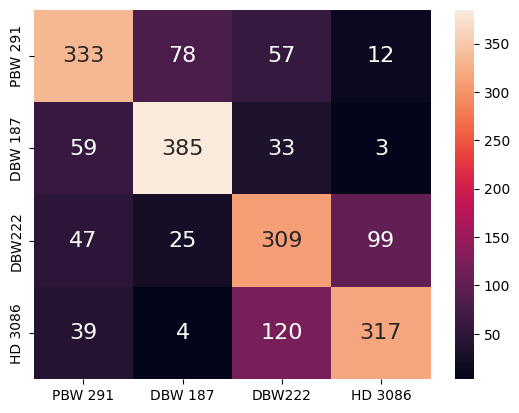

In [39]:
import seaborn as sn
import pandas as pd

df_cm = pd.DataFrame(cm,index =[i for i in VARIETIES],columns=[i for i in VARIETIES])
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='.0f') # font size

plt.show()